In [1]:
## Lesson 3 CamVid Tiramisu
%reload_ext autoreload
%autoreload 1
%matplotlib inline

from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from skimage.measure import regionprops, label

import os
cwd = os.getcwd()

path = Path(cwd + '/data/')
path.ls()

[PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/masks'),
 PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/MetalImages.txt'),
 PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/MetalImagesToDuplicate.txt'),
 PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/AdditionalNotTrustedImagesRemoved.txt'),
 PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/NoBoneImages.txt'),
 PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/images'),
 PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/codes.txt'),
 PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/NotTrusted'),
 PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/valid.txt')]

In [2]:
from fastai.utils.show_install import *
show_install()



```text
=== Software === 
python        : 3.6.8
fastai        : 1.0.51
fastprogress  : 0.1.20
torch         : 1.0.1
nvidia driver : 410.79
torch cuda    : 10.0.130 / is available
torch cudnn   : 7301 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-4.15.0-1041-azure-x86_64-with-debian-stretch-sid
distro        : #45-Ubuntu SMP Fri Mar 15 14:41:00 UTC 2019
conda env     : py35
python        : /data/anaconda/envs/py35/bin/python
sys.path      : /opt/caffe/python
/opt/caffe2/build
/data/home/thor/notebooks/sensorx-contaminant-detection
/data/anaconda/envs/py35/lib/python36.zip
/data/anaconda/envs/py35/lib/python3.6
/data/anaconda/envs/py35/lib/python3.6/lib-dynload

/data/anaconda/envs/py35/lib/python3.6/site-packages
/data/anaconda/envs/py35/lib/python3.6/site-packages/IPython/extensions
/data/home/thor/.ipython
```

Please make sure to include opening/closing ``` when you paste into foru

In [3]:
path_lbl = path/'masks'
path_img = path/'images'

In [4]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/images/MAGNA_46_83.231CL_3.48622kg.tif'),
 PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/images/MAGNA_35_83.3273CL_2.92945kg.tif'),
 PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/images/MAGNA_48_-1CL_0.0481968kg.tif')]

In [5]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/masks/MAGNA_46_83.231CL_3.48622kg.tif'),
 PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/masks/MAGNA_35_83.3273CL_2.92945kg.tif'),
 PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data/masks/MAGNA_48_-1CL_0.0481968kg.tif')]

In [6]:
# Select 10% validation images and handpicked meatl images
metal = ['MAGNA_3_86.3626CL_3.97524kg.tif',
'MAGNA_20_78.9422CL_0.960883kg.tif', 
'MAGNA_48_-1CL_0.437527kg.tif', 
'MAGNA_49_-1CL_0.440395kg.tif', 
'MAGNA_50_-1CL_0.317512kg.tif', 
'MAGNA_51_-1CL_0.453667kg.tif', 
'MAGNA_52_-1CL_0.360127kg.tif', 
'MAGNA_53_-1CL_0.446551kg.tif', 
'MAGNA_54_-1CL_0.441927kg.tif', 
'MAGNA_55_-1CL_0.454831kg.tif', 
'MAGNA_56_-1CL_0.446517kg.tif', 
'MAGNA_57_-1CL_0.442111kg.tif', 
'MAGNA_58_-1CL_0.453068kg.tif', 
'MAGNA_59_-1CL_0.328768kg.tif', 
'MAGNA_60_-1CL_0.439103kg.tif', 
'MAGNA_61_83.7706CL_3.88116kg.tif']

no_metal_names = np.array([img.name for img in fnames])
for metal_img in metal:
    no_metal_names = no_metal_names[no_metal_names != metal_img]

validation_count = len(no_metal_names) // 10 # 10% of the non-metal images
validation_files = np.random.choice(no_metal_names, size=validation_count, replace=False)
validation_metal = ['MAGNA_56_-1CL_0.446517kg.tif', 'MAGNA_61_83.7706CL_3.88116kg.tif',
                             'MAGNA_54_-1CL_0.441927kg.tif']
validation_files = np.append(validation_files, validation_metal)

outF = open("data/valid.txt", "w")
output = map(lambda x: x + '\n', validation_files)
outF.writelines(output)
outF.close()

def numb_contaminants(data):
    data = data.cpu().numpy().astype(int)
            
#     pixel_count = len(data[data == 2]) + len(data[data == 3])
#     if pixel_count > 400:
#         print(name)
#         print("Has {} contaminant pixels".format(pixel_count))
        
    data[data == 1] = 0  # Set meat as background

    labels = label(data, background=0) # same image_binary as above
    regions = regionprops(labels)
    contaminant_count = len(regions)
    return float(contaminant_count)

def numb_incorrect_contaminants(input, target):
    '''Computes the average number of incorrect number of contaminants in labeled image'''
    
    target = target.squeeze(1)
    input = input.argmax(dim=1)
    
    count_incorrect = np.abs(numb_contaminants(input) - numb_contaminants(target))
    
    ret = torch.Tensor(1)
    ret[0] = count_incorrect
    return ret

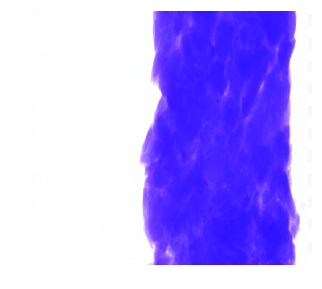

In [7]:
## Data

img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))
#plt.show()

In [8]:
img_f.parent.parent

PosixPath('/data/home/thor/notebooks/sensorx-contaminant-detection/data')

[700 768] tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])


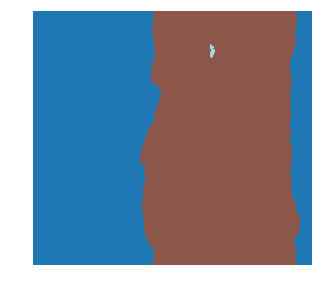

In [9]:
def get_y_fn(x):
    return Path(str(x.parent.parent)+'/masks') / x.name

codes = array(['Belt', 'Meat', 'Bone', 'Metal'])

mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

src_size = np.array(mask.shape[1:])
print(src_size, mask.data)

In [10]:
## Datasets
bs,size = 2,src_size//2
transforms = ([RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True)],
              [RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-45.0, 45.0)}, p=1.0, resolved={}, do_run=True, is_random=True)])

src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file(str(path) + '/valid.txt')
       .label_from_func(get_y_fn, classes=codes))
data = (src.transform(transforms, size=size, tfm_y=True) # tfm_y=True to apply the same transform to the mask
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [11]:
print(data.train_ds)
print()
print(data.test_ds)
print()
print(data.valid_ds)

LabelList (3453 items)
x: SegmentationItemList
Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384)
y: SegmentationLabelList
ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384)
Path: /data/home/thor/notebooks/sensorx-contaminant-detection/data/images

None

LabelList (385 items)
x: SegmentationItemList
Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384)
y: SegmentationLabelList
ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384)
Path: /data/home/thor/notebooks/sensorx-contaminant-detection/data/images


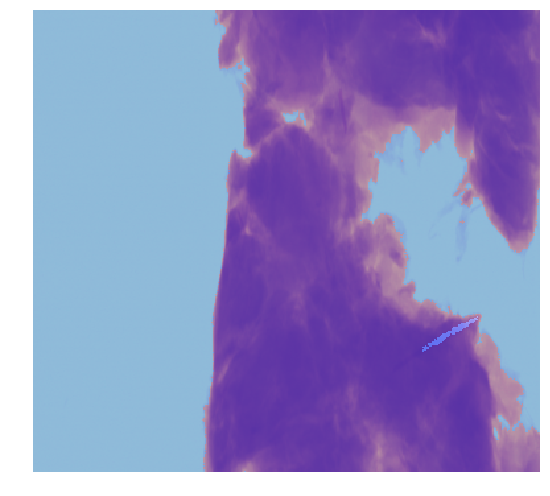

In [12]:
data.show_batch(1, figsize=(10,7))

In [13]:
# weights = torch.FloatTensor([0., 1., 10., 100.]) # ['Belt', 'Meat', 'Bone', 'Metal'])
# def forward(y_hat, y)->Rank0Tensor:  # This custom loss did not work with the backpropagation
#     y_hat = y_hat.argmax(dim=1)
#     y = y.squeeze(1)
    
#     costs = weights[y] * torch.log(y_hat.float() + 1e-16) # epsilon=1e-45
#     cost = costs.sum().double()
#     return cost

weight = torch.FloatTensor([1., 1., 1., 1.]).cuda()
def customLossFunction(input, target): # Works
    target = target.squeeze(1)
    return F.nll_loss(torch.log_softmax(input, 1), target, weight, reduction='mean')
    
# Works
class CustomLoss():
    "Weighted Cross Entropy Loss."
    
    def __init__(self):
        self.weight = torch.FloatTensor([1., 1., 1., 1.]).cuda()
        self.func = nn.CrossEntropyLoss(self.weight)
        functools.update_wrapper(self, self.func)

    def __repr__(self): return f"FlattenedLoss of {self.func}"
    @property
    def reduction(self): return self.func.reduction
    @reduction.setter
    def reduction(self, v): self.func.reduction = v

    def __call__(self, input:Tensor, target:Tensor, **kwargs)->Rank0Tensor:
        target = target.squeeze(1)        
        return self.func.__call__(input, target, **kwargs)

In [14]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()
    
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [15]:
def IoU(input:Tensor, targs:Tensor)->Rank0Tensor:
    return dice(input, targs, iou=True)

In [16]:
wd=1e-2

In [17]:
# The image is reduced by half (data.batch_stats), and has 3 chanels by default (the other two are set to 1)
def pretrained_model(pretrained=True):
    return models.resnet50(pretrained)

learn = unet_learner(data, pretrained_model, wd=wd)#, loss_func=nn.CrossEntropyLoss(weight))#, loss_func=CustomLoss()) #customLossFunction

learn.crit = FocalLoss(5.0)
learn.metrics=[dice, IoU, numb_incorrect_contaminants]

In [18]:
x, y = data.one_batch(DatasetType.Train, True, True)
data.one_batch

<bound method DataBunch.one_batch of ImageDataBunch;

Train: LabelList (3453 items)
x: SegmentationItemList
Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384)
y: SegmentationLabelList
ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384)
Path: /data/home/thor/notebooks/sensorx-contaminant-detection/data/images;

Valid: LabelList (385 items)
x: SegmentationItemList
Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384),Image (3, 350, 384)
y: SegmentationLabelList
ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384)
Path: /data/home/thor/notebooks/sensorx-contaminant-detection/data/images;

Test: None>

In [19]:
learn.loss_func, data.loss_func

(FlattenedLoss of CrossEntropyLoss(), FlattenedLoss of CrossEntropyLoss())

In [20]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


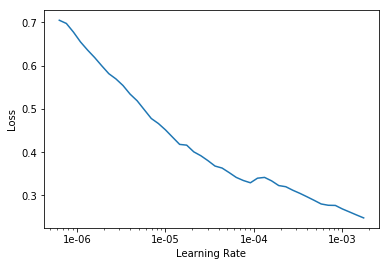

In [21]:
learn.recorder.plot()

In [20]:
lr=1e-4

In [23]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.save('stage-1-big')

In [21]:
learn.load('stage-1-big');

In [22]:
learn.unfreeze()

In [23]:
lrs = slice(1e-6,lr/10)

In [24]:
learn.fit_one_cycle(5, lrs)

In [25]:
learn.save('stage-2-big')

In [21]:
learn.load('stage-2-big');

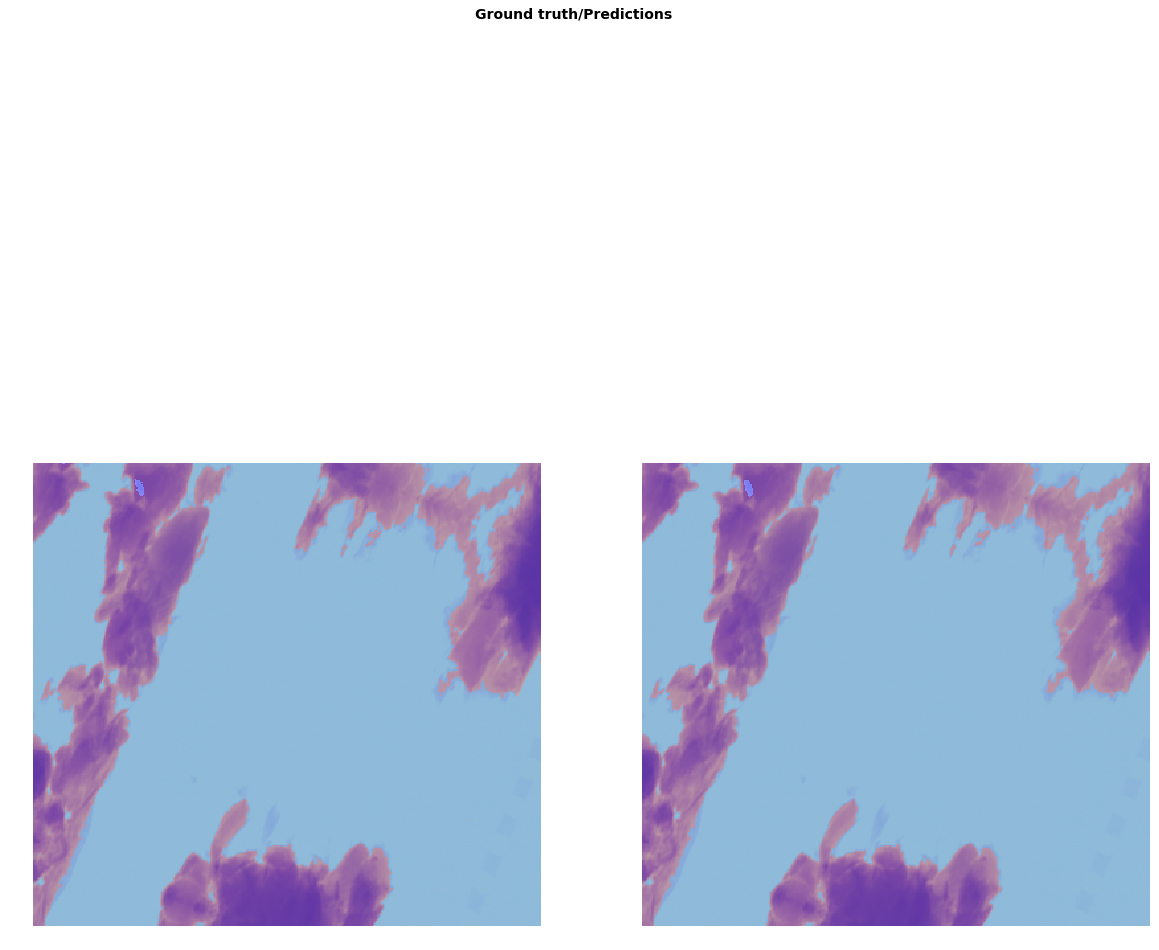

In [22]:
learn.show_results(rows=learn.data.batch_size-1, figsize=(20,20)) # This shows incorrect predictions?

In [28]:
preds,y = learn.get_preds()

In [29]:
def getContanimentInfo(prediction):
    items = prediction.unique()
    
    name2id = {v:k for k,v in enumerate(codes)}
    if name2id['Bone'] in items and name2id['Metal'] in items:
        return "Bone and Metal"
    if name2id['Metal'] in items:
        return "Metal"
    if name2id['Bone'] in items:
        return "Bone"
    if name2id['Meat'] in items:
        return "just Meat"
    else:
        return "Nothing"

########################
Ground truth / Predictions
########################
MAGNA_29_78.6686CL_3.5191kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 60, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 58, Metal: 0, Groups total: 1.0


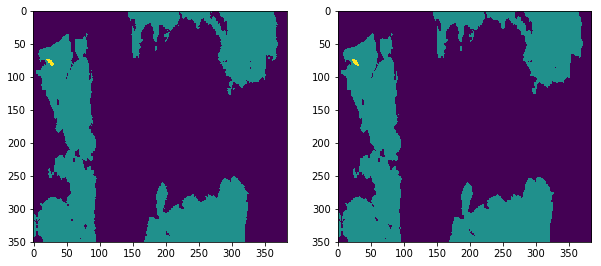

MAGNA_72_-1CL_0.0825218kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 437, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 944, Metal: 0, Groups total: 17.0


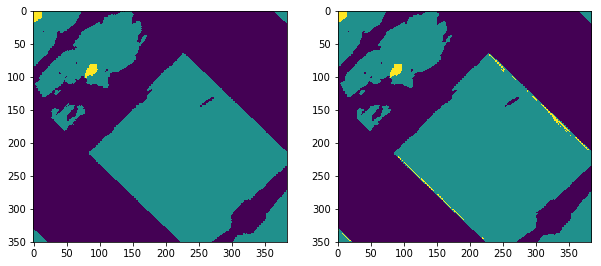

MAGNA_52_81.3933CL_3.39371kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 133, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 115, Metal: 0, Groups total: 3.0


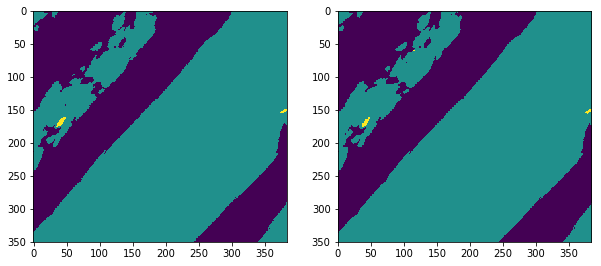

MAGNA_62_80.7711CL_3.55714kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 71, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 65, Metal: 0, Groups total: 1.0


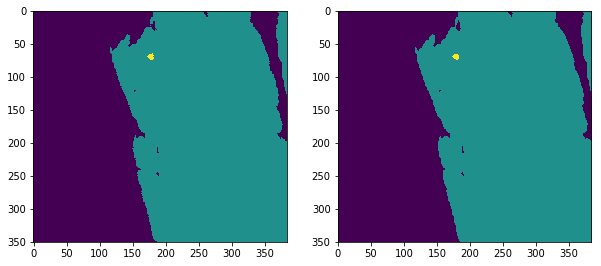

MAGNA_67_-1CL_0.0995158kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 33, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 20, Metal: 0, Groups total: 1.0


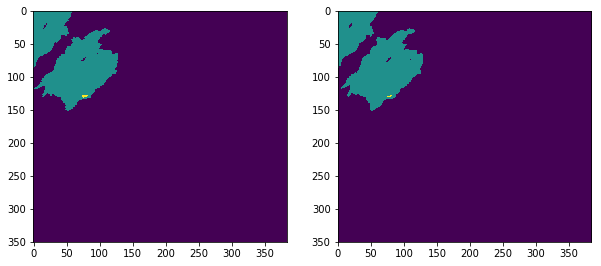

MAGNA_5_86.3265CL_2.98014kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 102, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 127, Metal: 0, Groups total: 1.0


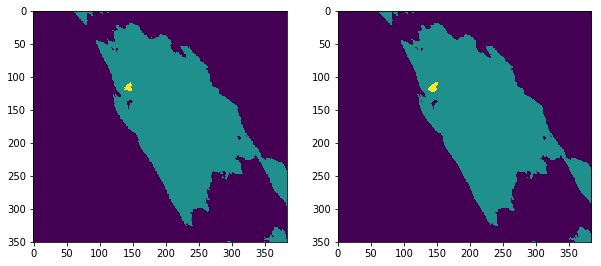

MAGNA_60_89.7556CL_2.97561kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 220, Metal: 0, Groups total: 4.0
Prediction   -> Bone: 422, Metal: 0, Groups total: 4.0


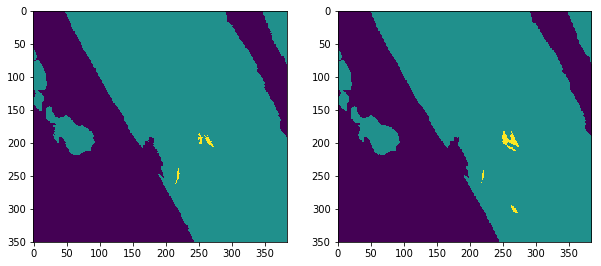

MAGNA_54_-1CL_0.273012kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 49, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 43, Metal: 0, Groups total: 1.0


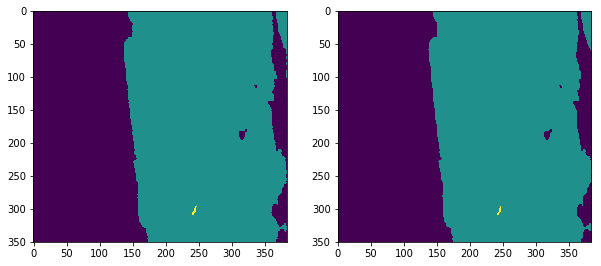

MAGNA_41_74.0919CL_3.09995kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 1189, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 1197, Metal: 0, Groups total: 2.0


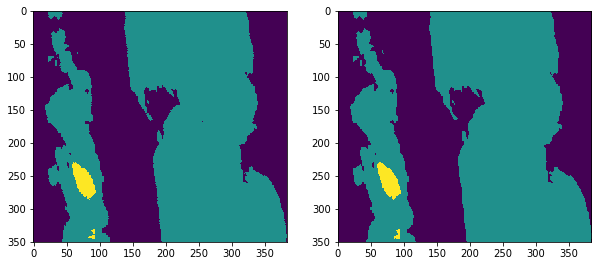

MAGNA_69_79.1459CL_3.66139kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 95, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 96, Metal: 0, Groups total: 1.0


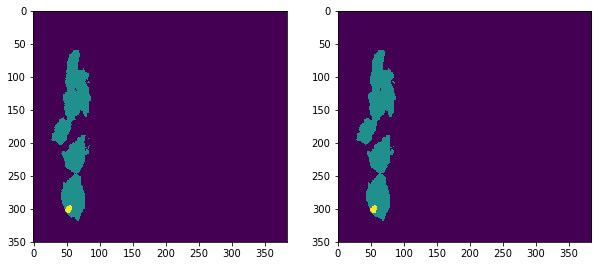

MAGNA_39_85.0753CL_3.33867kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 548, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 558, Metal: 0, Groups total: 1.0


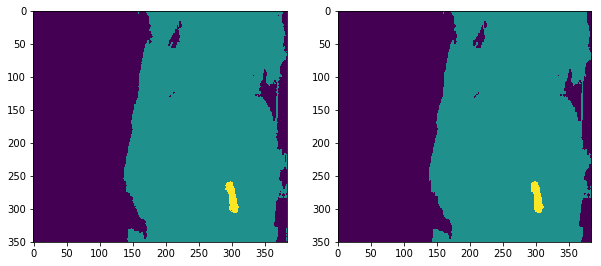

MAGNA_28_74.4163CL_3.20864kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 569, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 622, Metal: 0, Groups total: 3.0


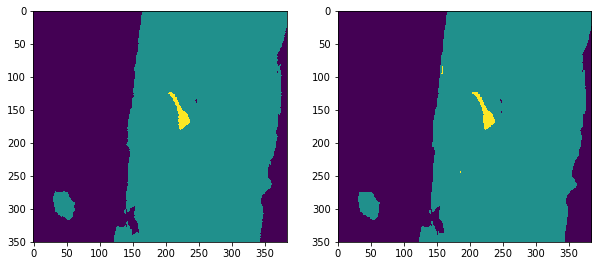

MAGNA_54_-1CL_0.362692kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 592, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 592, Metal: 0, Groups total: 1.0


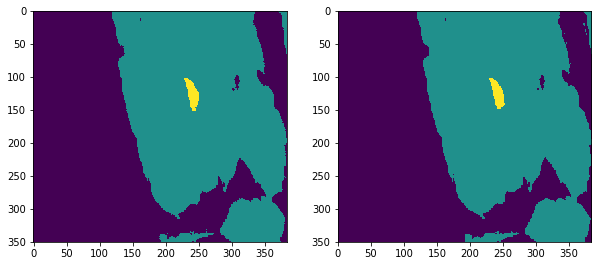

MAGNA_70_-1CL_0.826193kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 92, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 49, Metal: 0, Groups total: 1.0


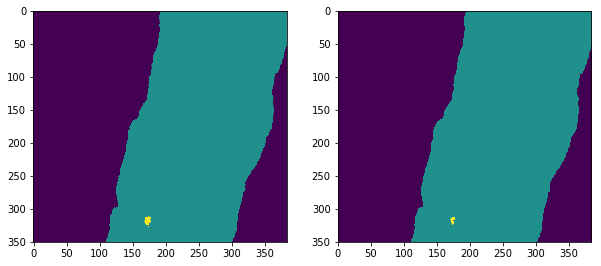

MAGNA_68_68.006CL_3.1209kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 86, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 287, Metal: 0, Groups total: 26.0


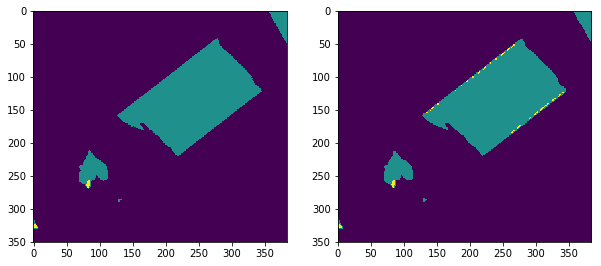

MAGNA_96_89.5988CL_2.64574kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 121, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 105, Metal: 0, Groups total: 2.0


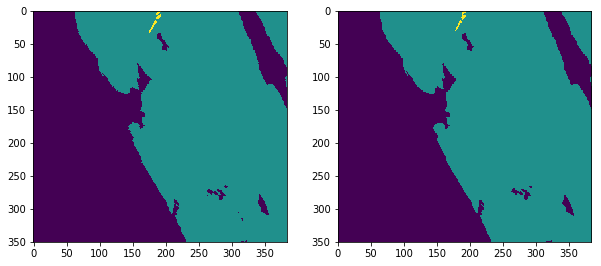

MAGNA_80_70.0527CL_3.31811kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 48, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 38, Metal: 0, Groups total: 1.0


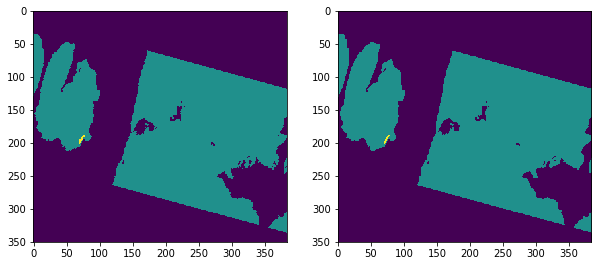

MAGNA_31_-1CL_0.0465326kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 195, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 280, Metal: 0, Groups total: 28.0


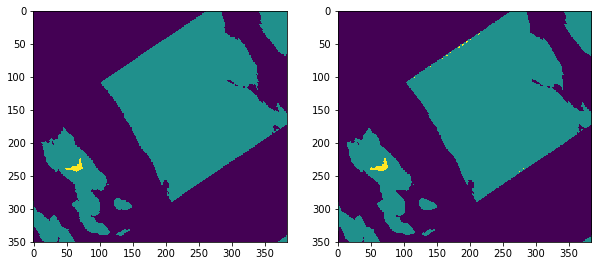

MAGNA_84_-1CL_0.136957kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 72, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 76, Metal: 0, Groups total: 1.0


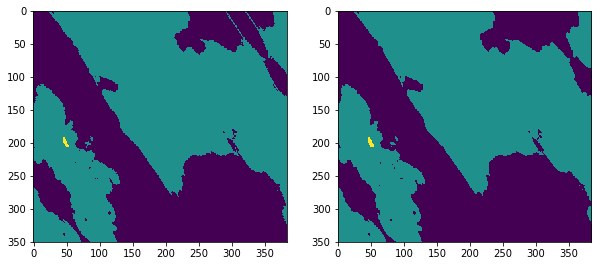

MAGNA_29_64.6885CL_2.8208kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 460, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 453, Metal: 0, Groups total: 2.0


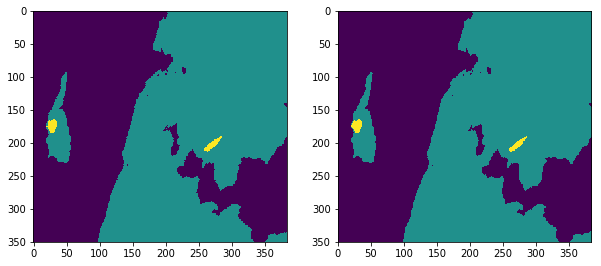

MAGNA_74_-1CL_0.675555kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 59, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 35, Metal: 0, Groups total: 1.0


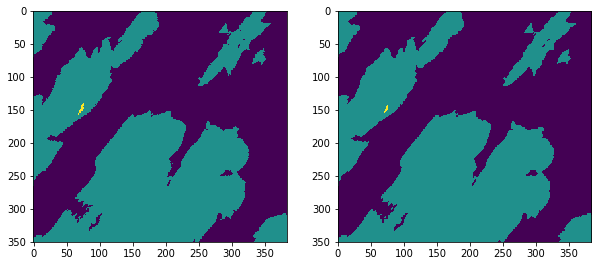

MAGNA_66_-1CL_0.304034kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 46, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 43, Metal: 0, Groups total: 1.0


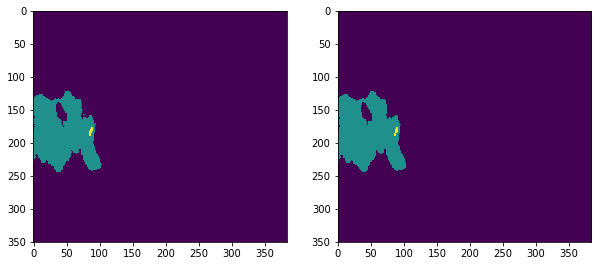

MAGNA_71_64.0011CL_3.48205kg.tif
There is just Meat / Found just Meat
Pixel count
Ground truth -> Bone: 0, Metal: 0, Groups total: 0.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


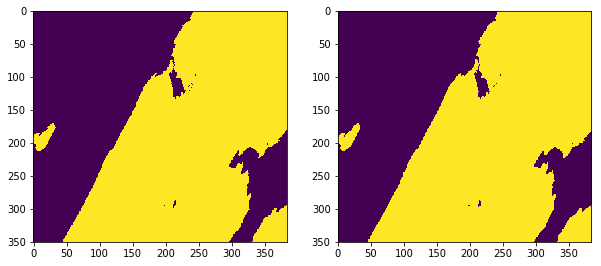

MAGNA_82_61.9102CL_3.30285kg.tif
There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 2, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


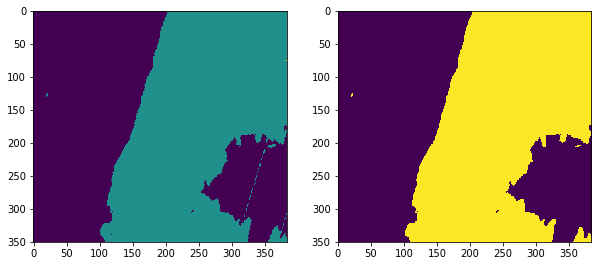

MAGNA_75_-1CL_0.0136386kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 139, Metal: 0, Groups total: 4.0
Prediction   -> Bone: 162, Metal: 0, Groups total: 3.0


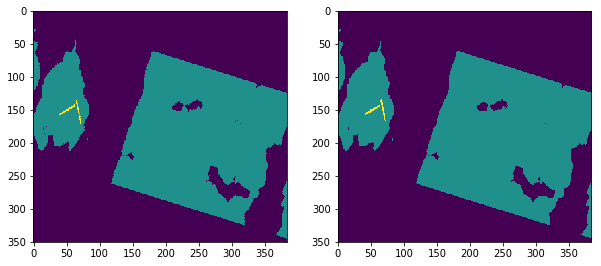

MAGNA_99_-1CL_0.00256941kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 64, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 112, Metal: 0, Groups total: 16.0


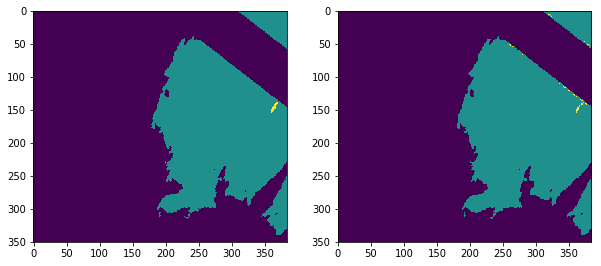

MAGNA_23_-1CL_0.367999kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 165, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 161, Metal: 0, Groups total: 2.0


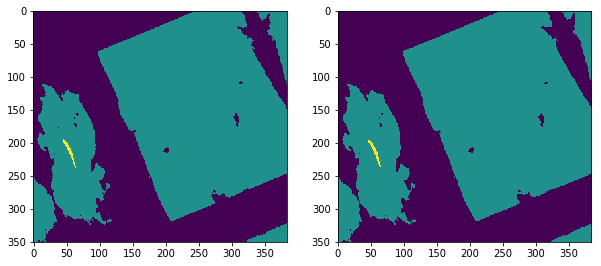

MAGNA_79_93.4312CL_2.92794kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 1151, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 1108, Metal: 0, Groups total: 2.0


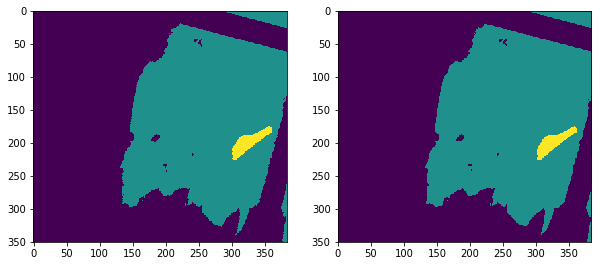

MAGNA_77_-1CL_0.161603kg.tif
There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 71, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


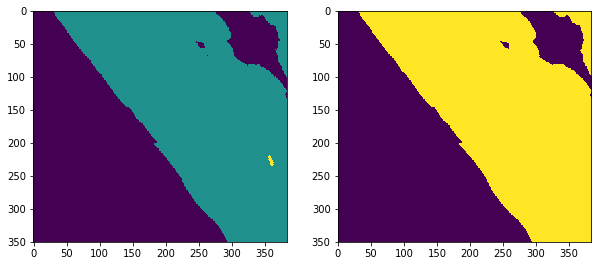

MAGNA_54_-1CL_0.0538696kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 77, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 73, Metal: 0, Groups total: 1.0


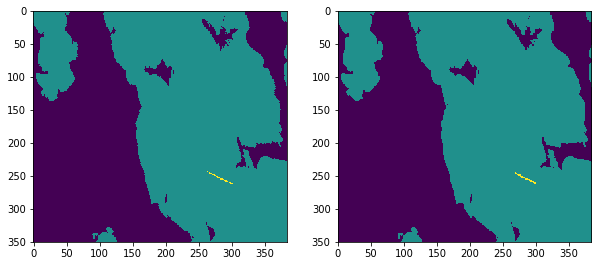

MAGNA_33_83.2897CL_3.58024kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 190, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 232, Metal: 0, Groups total: 1.0


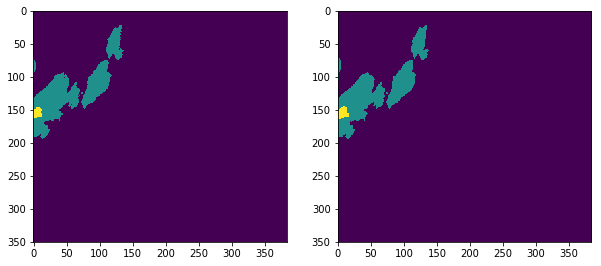

MAGNA_41_-1CL_0.00171297kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 108, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 140, Metal: 0, Groups total: 2.0


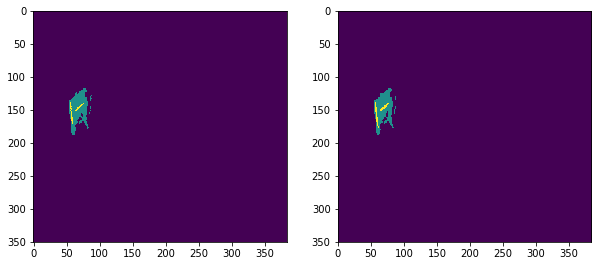

MAGNA_98_-1CL_0.328606kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 483, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 496, Metal: 0, Groups total: 2.0


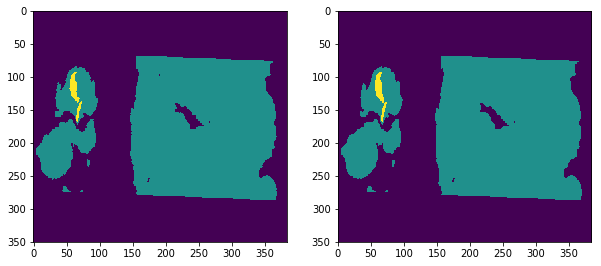

MAGNA_4_-1CL_0.0749706kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 31, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 36, Metal: 0, Groups total: 1.0


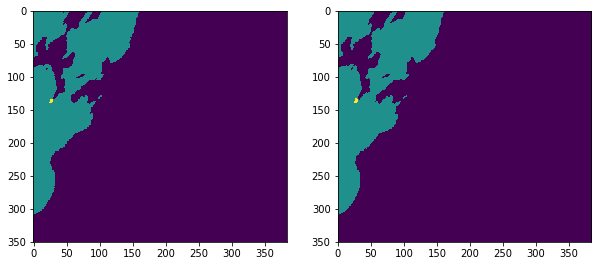

MAGNA_53_68.2652CL_3.92887kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 198, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 203, Metal: 0, Groups total: 1.0


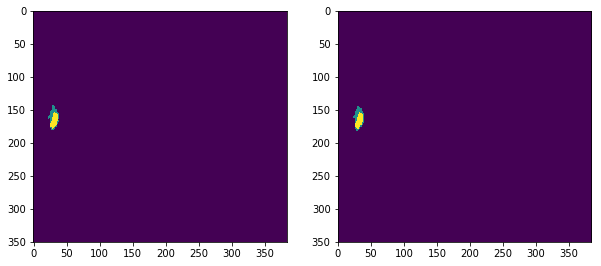

MAGNA_36_-1CL_0.123596kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 92, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 53, Metal: 0, Groups total: 1.0


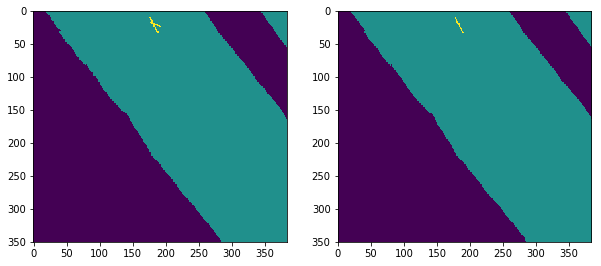

MAGNA_73_87.2518CL_3.61827kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 66, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 48, Metal: 0, Groups total: 1.0


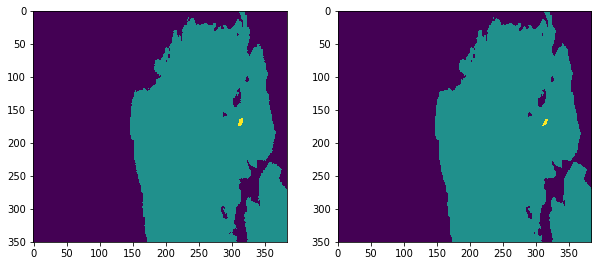

MAGNA_19_-1CL_0.316711kg.tif
There is just Meat / Found just Meat
Pixel count
Ground truth -> Bone: 0, Metal: 0, Groups total: 0.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


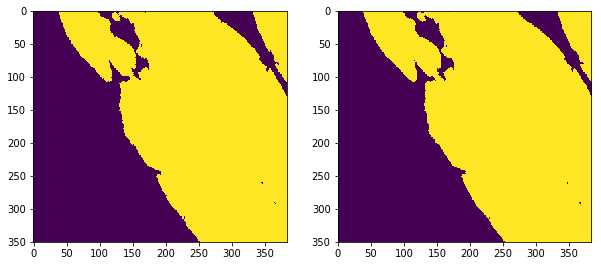

MAGNA_54_-1CL_0.174072kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 993, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 1041, Metal: 0, Groups total: 3.0


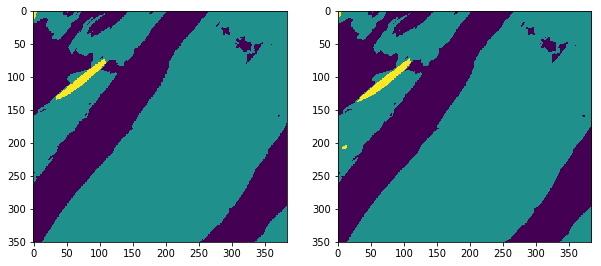

MAGNA_17_-1CL_0.523347kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 337, Metal: 0, Groups total: 5.0
Prediction   -> Bone: 315, Metal: 0, Groups total: 5.0


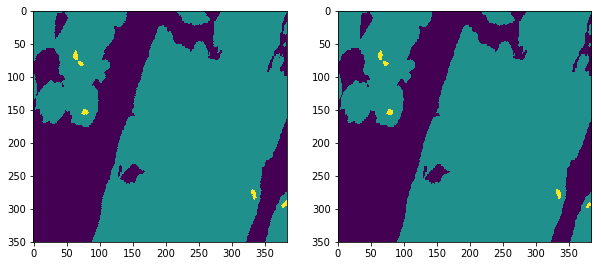

MAGNA_7_77.051CL_3.57081kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 61, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 68, Metal: 0, Groups total: 1.0


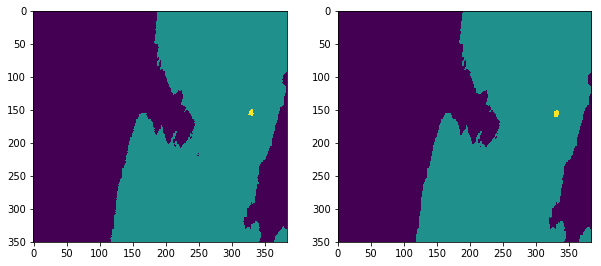

MAGNA_72_-1CL_0.36625kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 105, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 91, Metal: 0, Groups total: 2.0


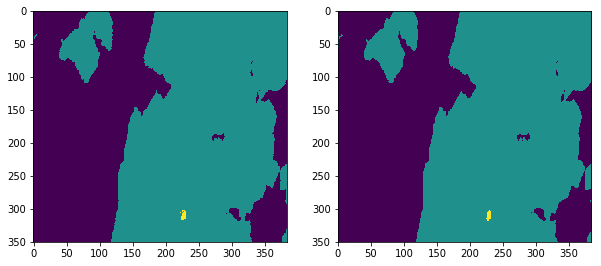

MAGNA_29_86.0562CL_3.33443kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 270, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 307, Metal: 0, Groups total: 2.0


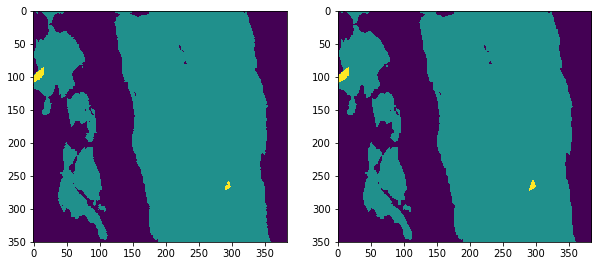

MAGNA_49_91.5474CL_3.04926kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 525, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 762, Metal: 0, Groups total: 1.0


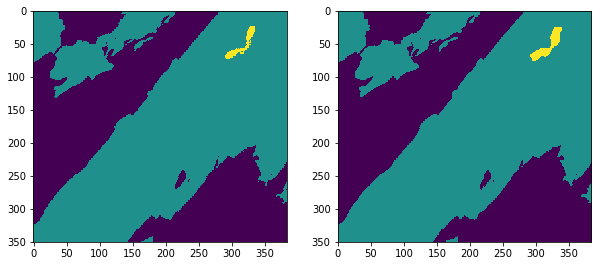

MAGNA_24_40.3941CL_2.74895kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 64, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 33, Metal: 0, Groups total: 1.0


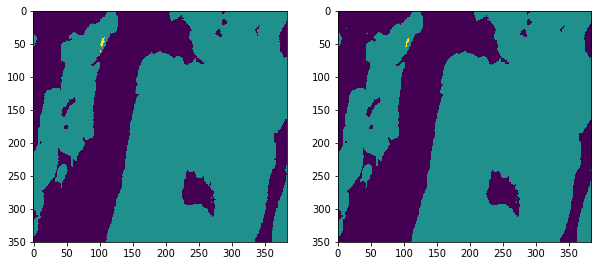

MAGNA_3_-1CL_0.36593kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 556, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 568, Metal: 0, Groups total: 3.0


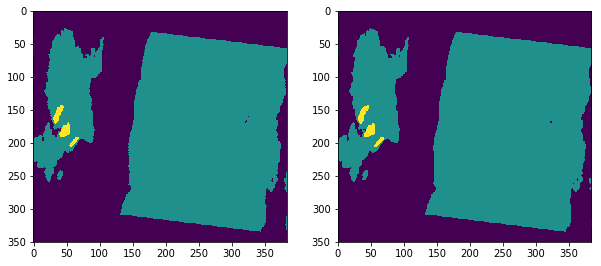

MAGNA_17_73.9539CL_3.28994kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 119, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 122, Metal: 0, Groups total: 1.0


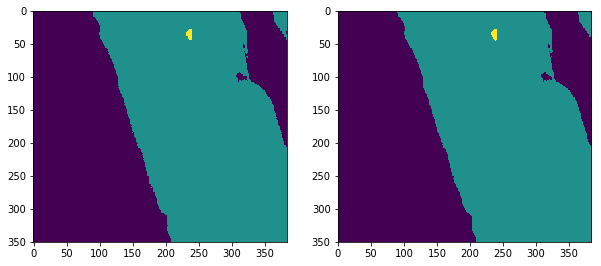

MAGNA_63_75.2948CL_2.78947kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 58, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 56, Metal: 0, Groups total: 1.0


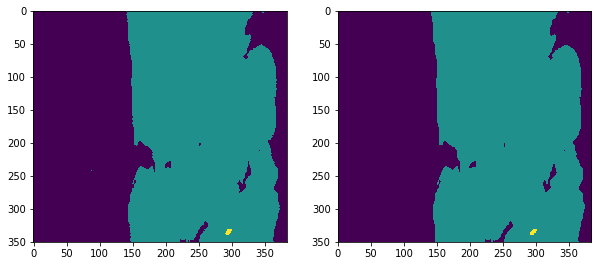

MAGNA_28_-1CL_0.306183kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 65, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 302, Metal: 0, Groups total: 38.0


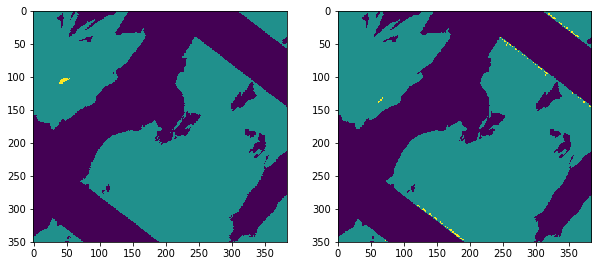

MAGNA_8_-1CL_0.276951kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 306, Metal: 0, Groups total: 4.0
Prediction   -> Bone: 266, Metal: 0, Groups total: 6.0


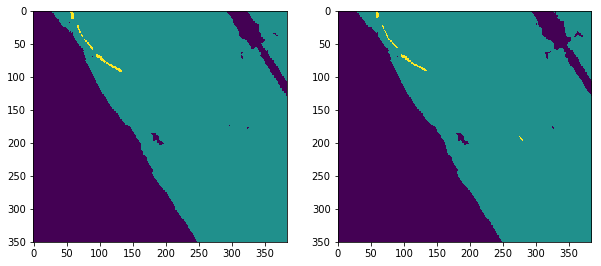

MAGNA_37_-1CL_7.21201e-06kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 199, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 204, Metal: 0, Groups total: 2.0


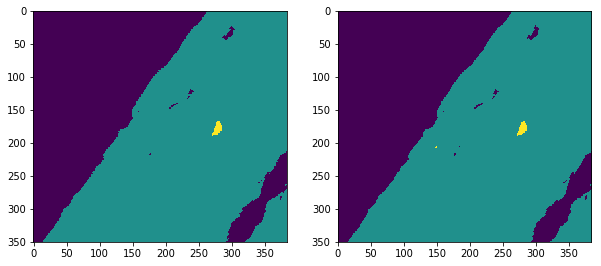

MAGNA_21_-1CL_0.320536kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 328, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 333, Metal: 0, Groups total: 1.0


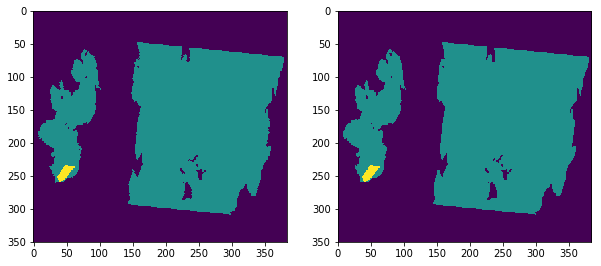

MAGNA_75_-1CL_0.197227kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 2344, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 2235, Metal: 0, Groups total: 5.0


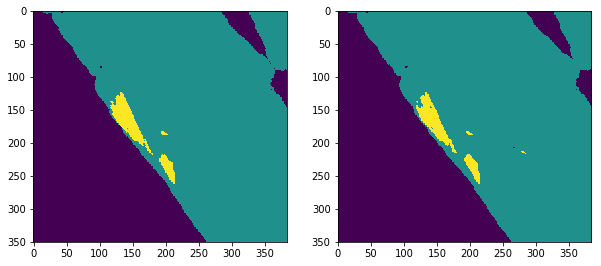

MAGNA_91_86.8476CL_2.92141kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 1293, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 1173, Metal: 0, Groups total: 2.0


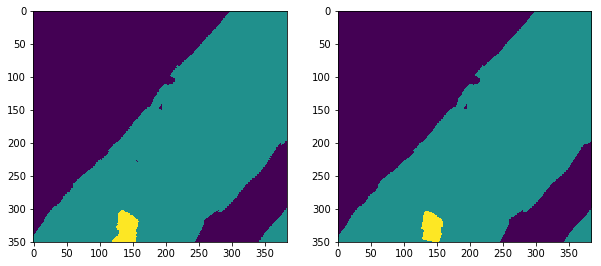

MAGNA_93_79.1209CL_3.46683kg.tif
There is Metal / Found Bone
Pixel count
Ground truth -> Bone: 0, Metal: 1, Groups total: 1.0
Prediction   -> Bone: 9, Metal: 0, Groups total: 1.0


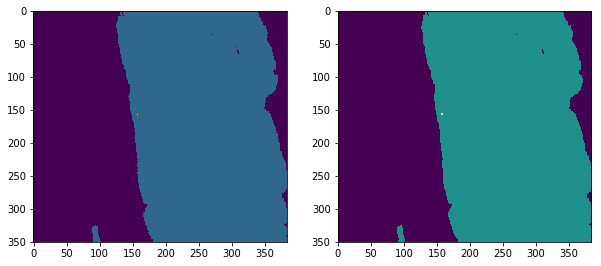

MAGNA_25_-1CL_0.205838kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 467, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 312, Metal: 0, Groups total: 2.0


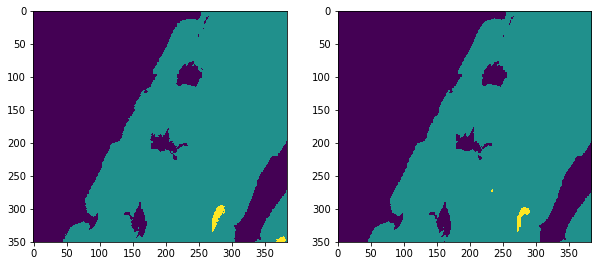

MAGNA_48_67.3407CL_3.36071kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 60, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 49, Metal: 0, Groups total: 1.0


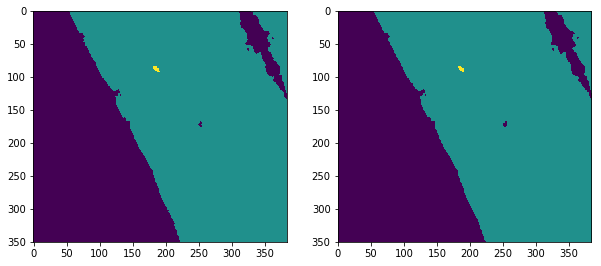

MAGNA_19_82.9374CL_3.50355kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 60, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 125, Metal: 0, Groups total: 3.0


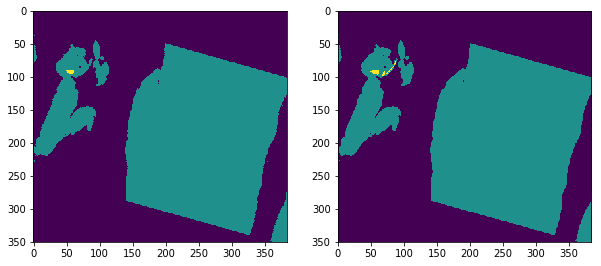

MAGNA_90_-1CL_9.3172e-05kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 180, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 156, Metal: 0, Groups total: 4.0


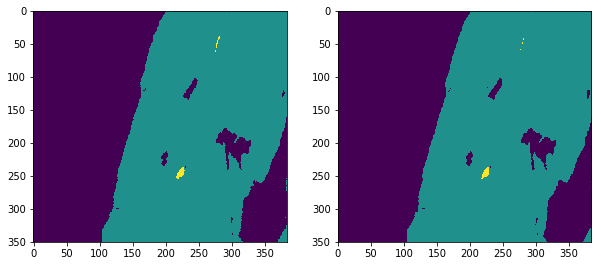

MAGNA_10_-1CL_0.00411415kg.tif
There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 94, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


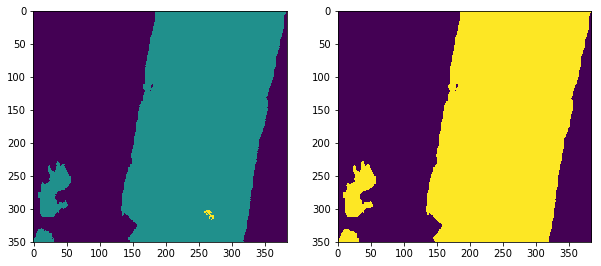

MAGNA_72_81.5461CL_3.16589kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 122, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 90, Metal: 0, Groups total: 1.0


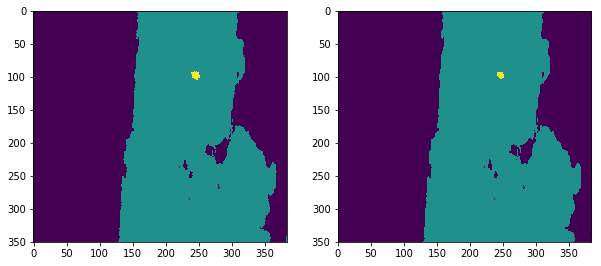

MAGNA_43_-1CL_0.229201kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 59, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 57, Metal: 0, Groups total: 1.0


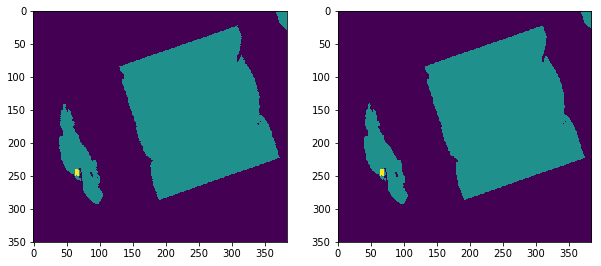

MAGNA_76_76.8536CL_2.9024kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 47, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 126, Metal: 0, Groups total: 5.0


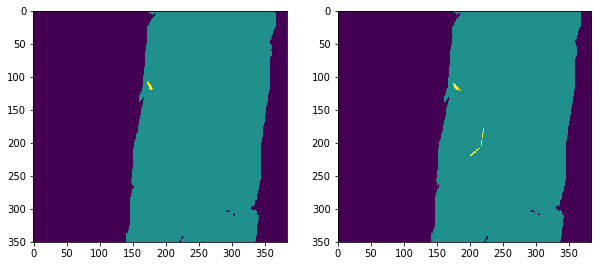

MAGNA_2_67.4631CL_3.84472kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 88, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 261, Metal: 0, Groups total: 43.0


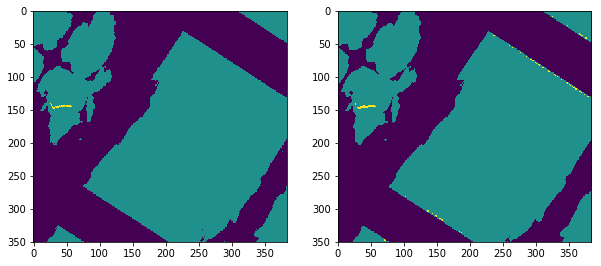

MAGNA_77_-1CL_0.206199kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 151, Metal: 0, Groups total: 4.0
Prediction   -> Bone: 129, Metal: 0, Groups total: 2.0


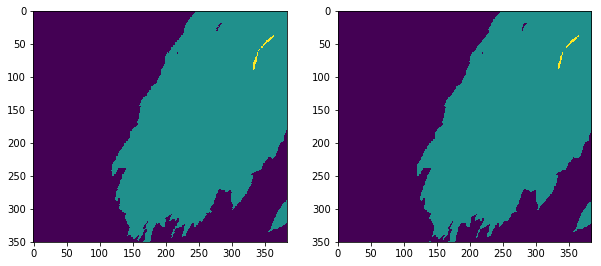

MAGNA_12_76.0034CL_3.63193kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 315, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 319, Metal: 0, Groups total: 2.0


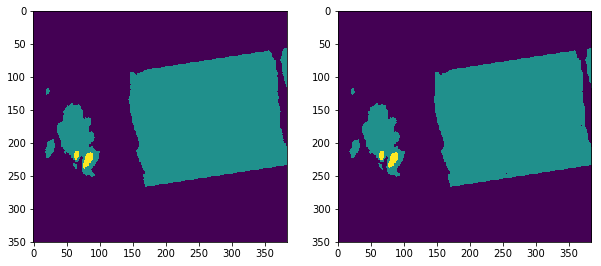

MAGNA_4_-1CL_0.0730513kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 75, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 66, Metal: 0, Groups total: 1.0


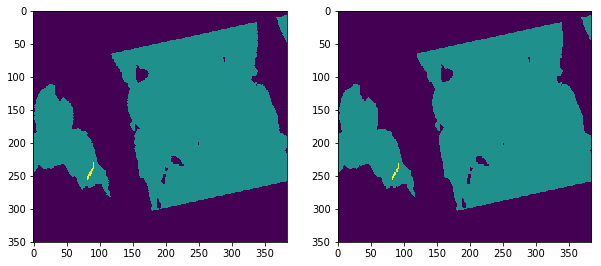

MAGNA_42_76.5286CL_3.60263kg.tif
There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 50, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


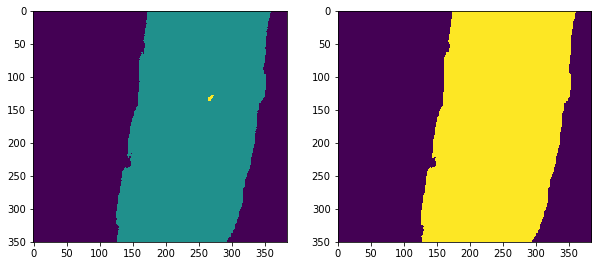

MAGNA_5_-1CL_0.366347kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 205, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 251, Metal: 0, Groups total: 2.0


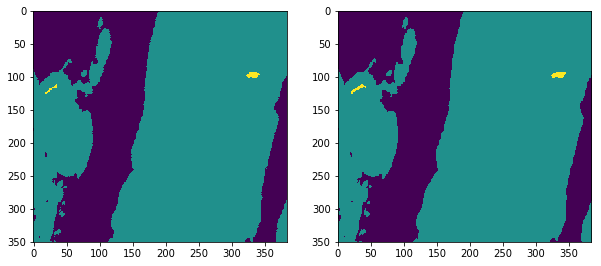

MAGNA_77_75.3566CL_2.89992kg.tif
There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 28, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


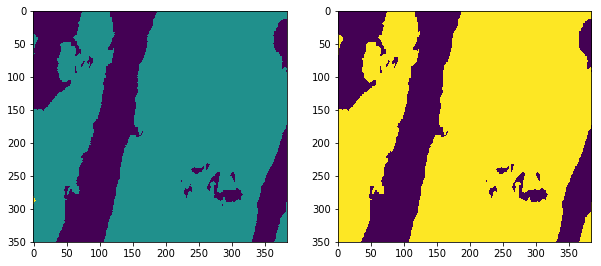

MAGNA_57_83.0319CL_3.47298kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 916, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 871, Metal: 0, Groups total: 3.0


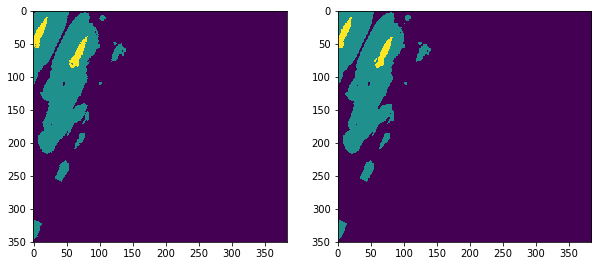

MAGNA_89_-1CL_0.0346226kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 205, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 152, Metal: 0, Groups total: 1.0


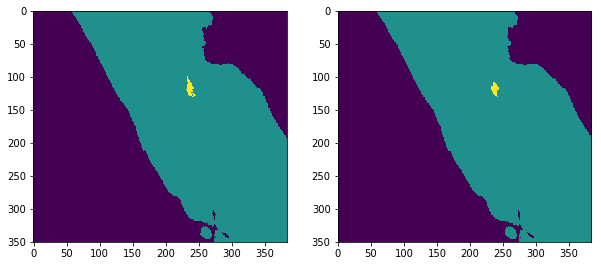

MAGNA_46_-1CL_0.361872kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 564, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 541, Metal: 0, Groups total: 1.0


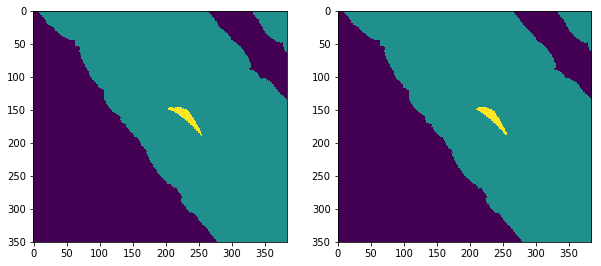

MAGNA_61_-1CL_0.280561kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 444, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 434, Metal: 0, Groups total: 3.0


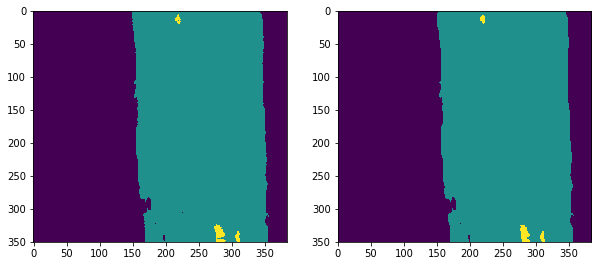

MAGNA_89_-1CL_0.015531kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 97, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 131, Metal: 0, Groups total: 1.0


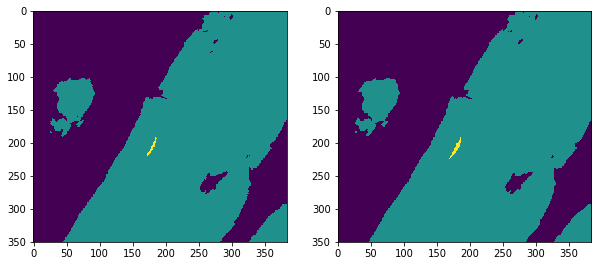

MAGNA_36_-1CL_0.0286535kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 137, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 131, Metal: 0, Groups total: 2.0


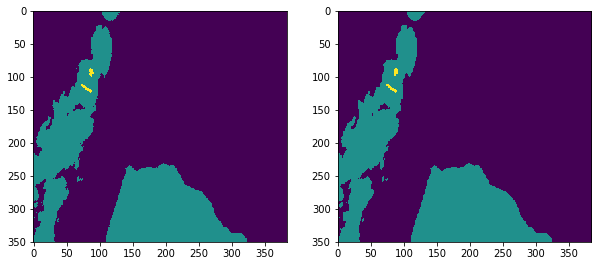

MAGNA_93_45.3925CL_2.78753kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 427, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 399, Metal: 0, Groups total: 1.0


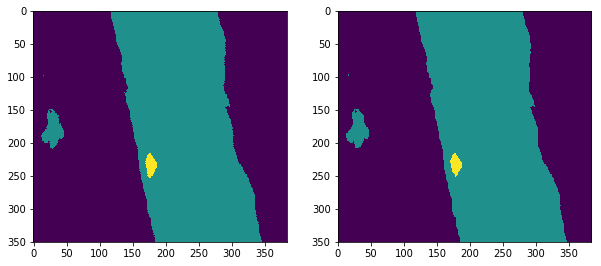

MAGNA_67_81.811CL_3.58783kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 173, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 100, Metal: 0, Groups total: 3.0


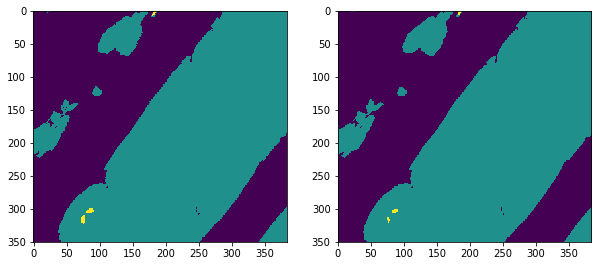

MAGNA_8_-1CL_0.227627kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 281, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 238, Metal: 0, Groups total: 1.0


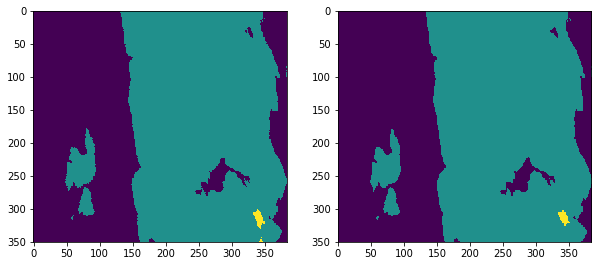

MAGNA_18_79.2287CL_3.06917kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 160, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 164, Metal: 0, Groups total: 1.0


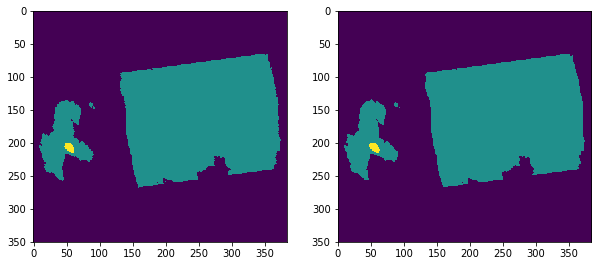

MAGNA_60_75.8294CL_3.18201kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 310, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 298, Metal: 0, Groups total: 1.0


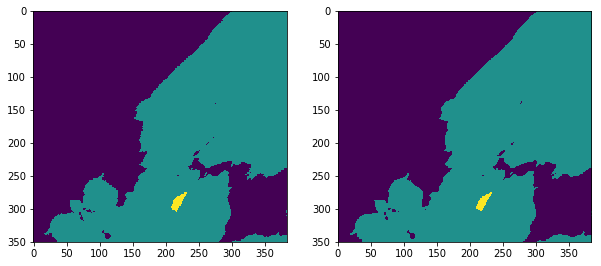

MAGNA_52_67.1918CL_3.24737kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 1013, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 986, Metal: 0, Groups total: 1.0


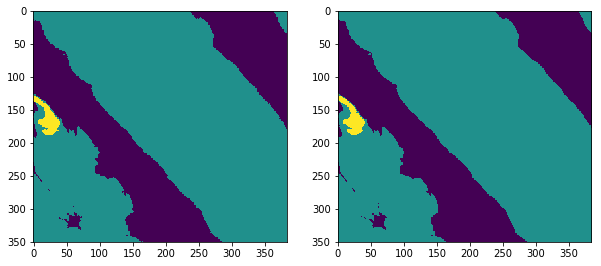

MAGNA_30_87.7279CL_3.58385kg.tif
There is just Meat / Found just Meat
Pixel count
Ground truth -> Bone: 0, Metal: 0, Groups total: 0.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


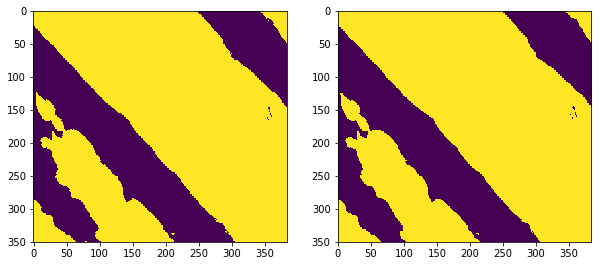

MAGNA_69_88.5073CL_3.14916kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 6065, Metal: 0, Groups total: 7.0
Prediction   -> Bone: 5684, Metal: 0, Groups total: 11.0


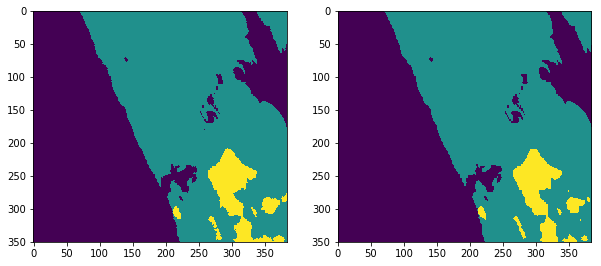

MAGNA_33_63.7318CL_3.55894kg.tif
There is just Meat / Found just Meat
Pixel count
Ground truth -> Bone: 0, Metal: 0, Groups total: 0.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


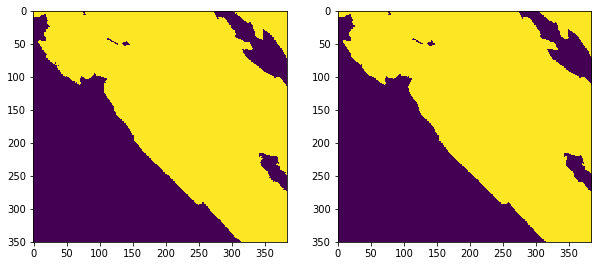

MAGNA_25_-1CL_0.0221874kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 706, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 693, Metal: 0, Groups total: 1.0


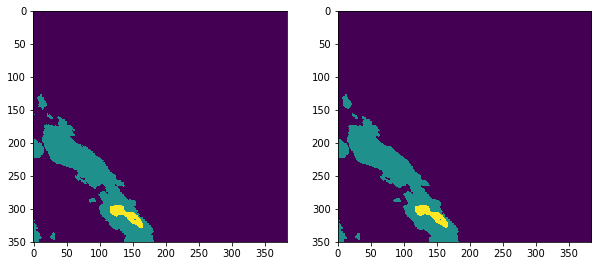

MAGNA_52_-1CL_0.211891kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 232, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 230, Metal: 0, Groups total: 1.0


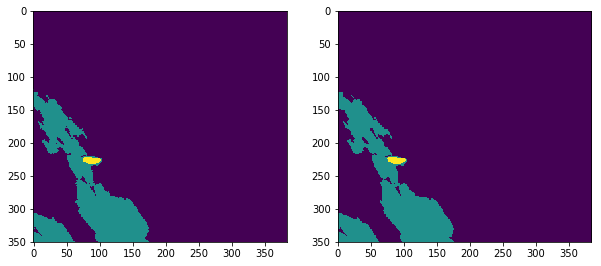

MAGNA_36_61.3811CL_2.88365kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 200, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 230, Metal: 0, Groups total: 2.0


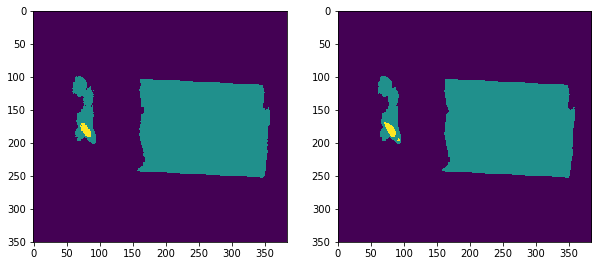

MAGNA_68_-1CL_0.0067699kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 1081, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 1066, Metal: 0, Groups total: 1.0


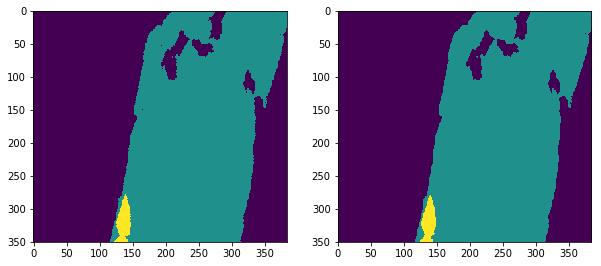

MAGNA_37_-1CL_0.28983kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 212, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 180, Metal: 0, Groups total: 1.0


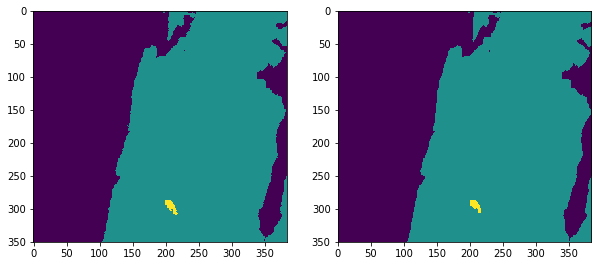

MAGNA_38_-1CL_0.677844kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 87, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 66, Metal: 0, Groups total: 2.0


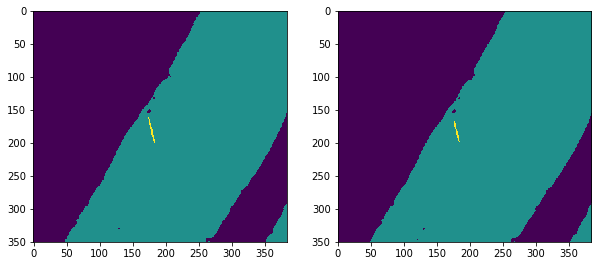

MAGNA_76_80.226CL_2.64297kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 222, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 207, Metal: 0, Groups total: 1.0


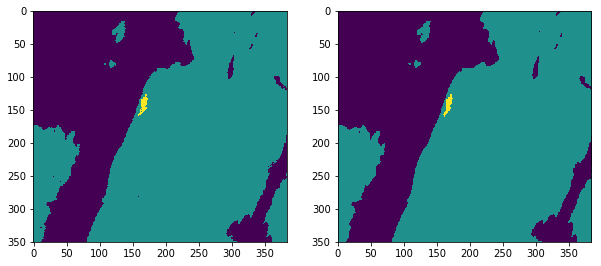

MAGNA_42_73.8784CL_3.57063kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 276, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 402, Metal: 0, Groups total: 2.0


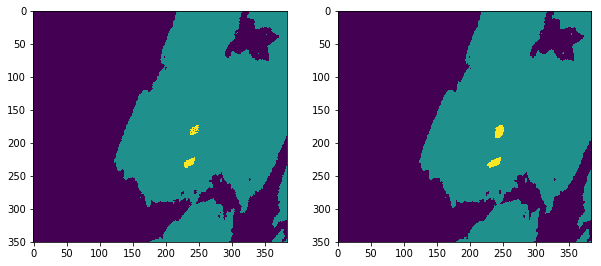

MAGNA_1_-1CL_0.0168483kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 78, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 89, Metal: 0, Groups total: 1.0


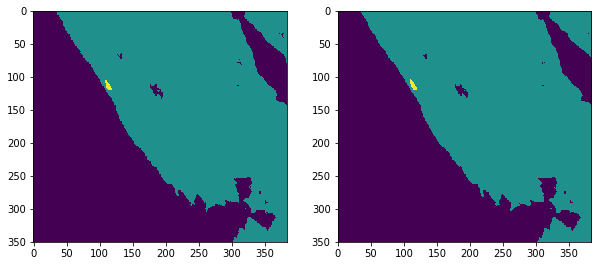

MAGNA_10_63.8818CL_3.07671kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 141, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 166, Metal: 0, Groups total: 2.0


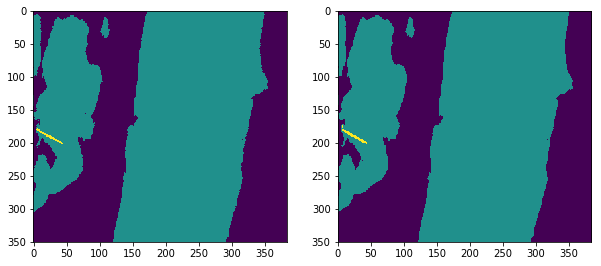

MAGNA_27_73.8257CL_3.06248kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 113, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 139, Metal: 0, Groups total: 1.0


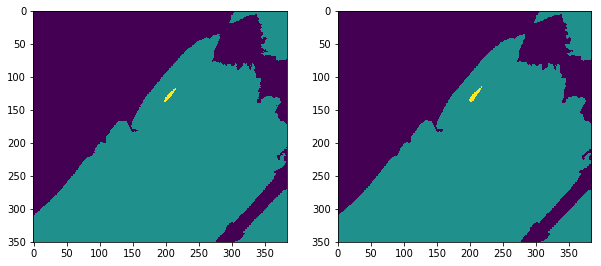

MAGNA_37_-1CL_0.000614579kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 278, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 266, Metal: 0, Groups total: 1.0


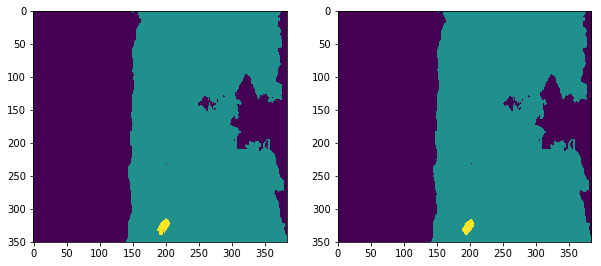

MAGNA_19_74.438CL_3.37482kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 40, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 74, Metal: 0, Groups total: 2.0


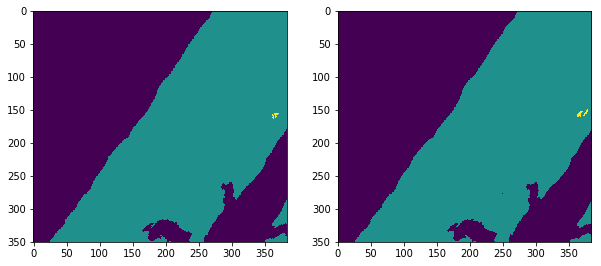

MAGNA_21_-1CL_0.00816612kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 128, Metal: 0, Groups total: 4.0
Prediction   -> Bone: 472, Metal: 0, Groups total: 50.0


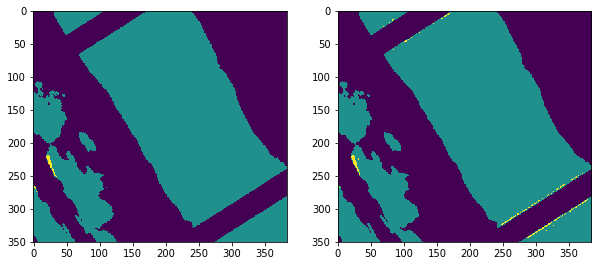

MAGNA_53_-1CL_0.205998kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 36, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 70, Metal: 0, Groups total: 2.0


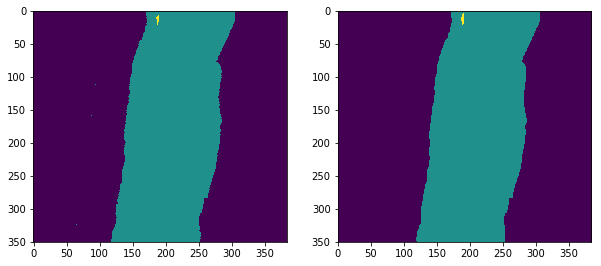

MAGNA_12_-1CL_0.422618kg.tif
There is Metal / Found Bone
Pixel count
Ground truth -> Bone: 0, Metal: 3, Groups total: 1.0
Prediction   -> Bone: 1, Metal: 0, Groups total: 1.0


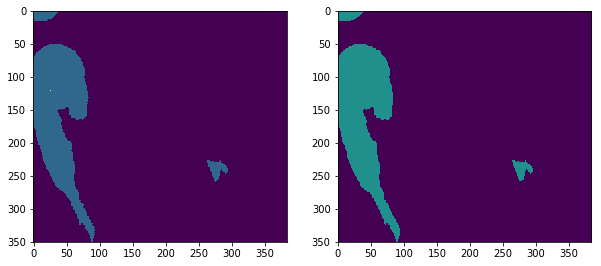

MAGNA_38_80.6132CL_3.72059kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 43, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 39, Metal: 0, Groups total: 1.0


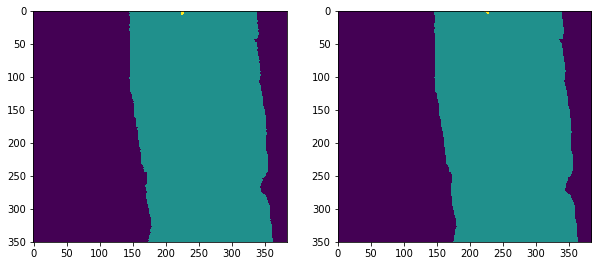

MAGNA_4_-1CL_0.315993kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 108, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 80, Metal: 0, Groups total: 1.0


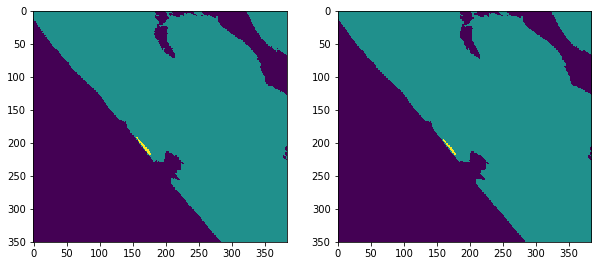

MAGNA_10_-1CL_0.251441kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 445, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 215, Metal: 0, Groups total: 1.0


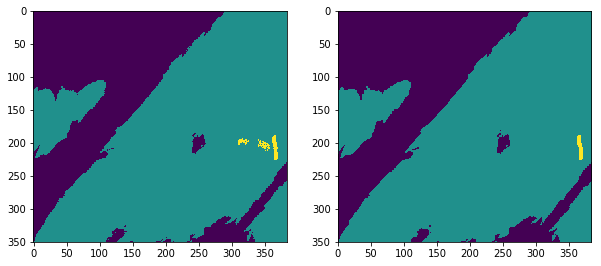

MAGNA_40_-1CL_0.312238kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 314, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 362, Metal: 0, Groups total: 1.0


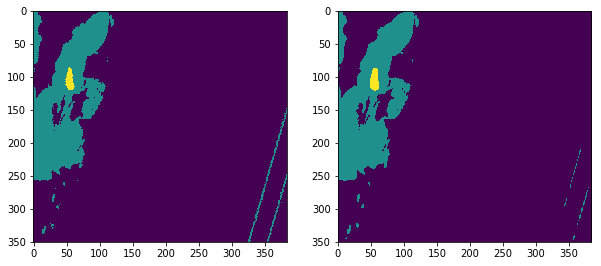

MAGNA_59_-1CL_0.290884kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 208, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 382, Metal: 0, Groups total: 12.0


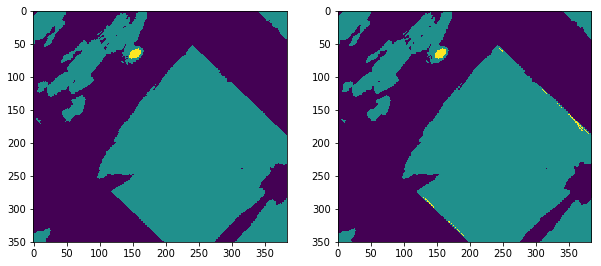

MAGNA_7_-1CL_0.135283kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 62, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 61, Metal: 0, Groups total: 1.0


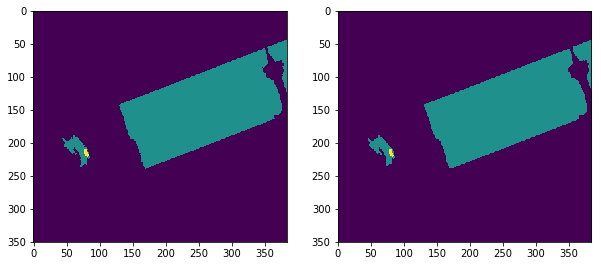

MAGNA_49_88.8754CL_3.53209kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 123, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 133, Metal: 0, Groups total: 1.0


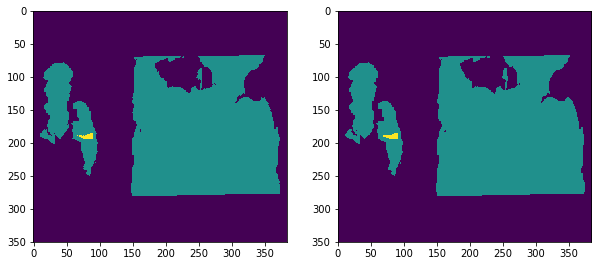

MAGNA_18_-1CL_0.0650088kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 36, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 32, Metal: 0, Groups total: 1.0


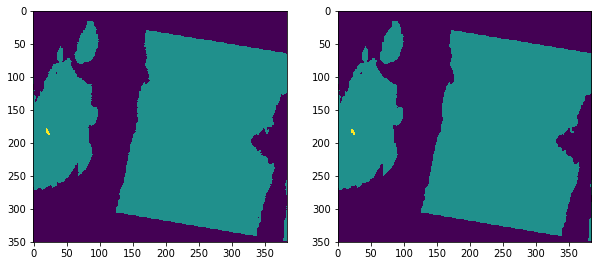

MAGNA_5_76.9901CL_3.38279kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 86, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 75, Metal: 0, Groups total: 1.0


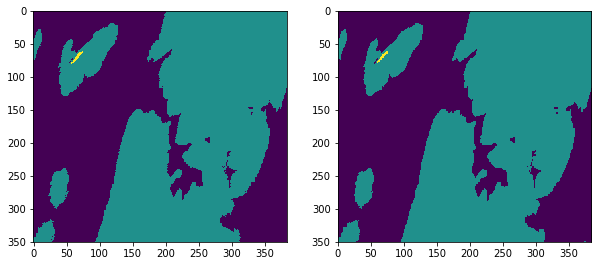

MAGNA_6_85.1364CL_2.91929kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 361, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 592, Metal: 0, Groups total: 52.0


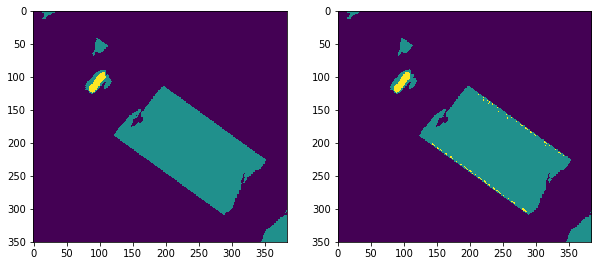

MAGNA_79_70.1523CL_3.06429kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 57, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 54, Metal: 0, Groups total: 1.0


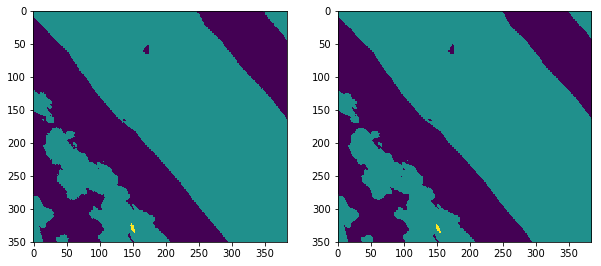

MAGNA_28_-1CL_0.484416kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 119, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 157, Metal: 0, Groups total: 5.0


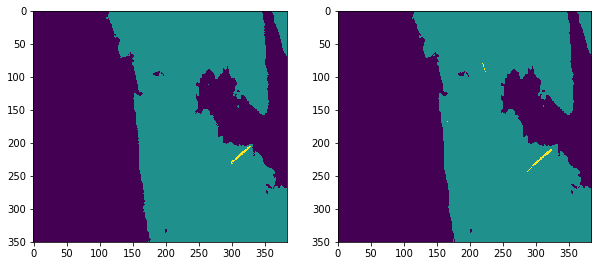

MAGNA_85_70.5928CL_2.38264kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 69, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 90, Metal: 0, Groups total: 15.0


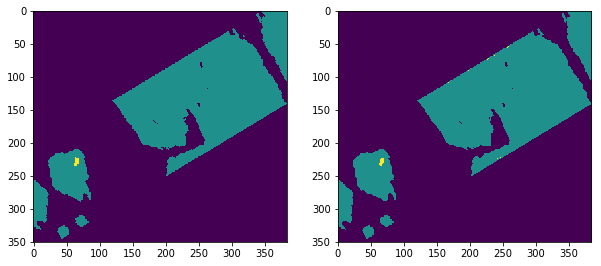

MAGNA_55_-1CL_0.00330277kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 501, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 521, Metal: 0, Groups total: 4.0


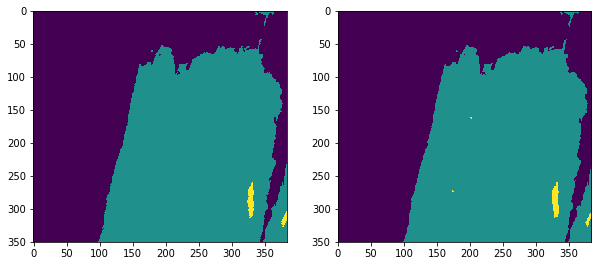

MAGNA_16_-1CL_0.00975507kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 128, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 230, Metal: 0, Groups total: 31.0


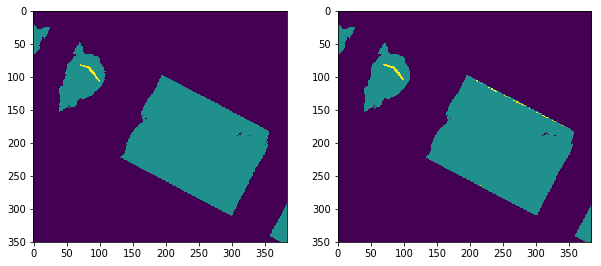

MAGNA_57_56.8038CL_3.75796kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 61, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 10, Metal: 0, Groups total: 1.0


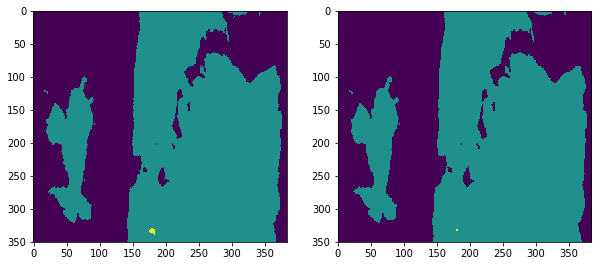

MAGNA_25_90.4453CL_3.13352kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 69, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 63, Metal: 0, Groups total: 1.0


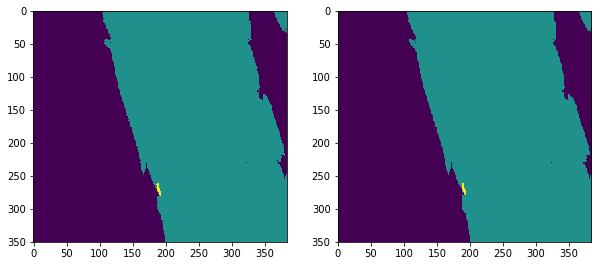

MAGNA_53_79.4309CL_3.42407kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 115, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 127, Metal: 0, Groups total: 1.0


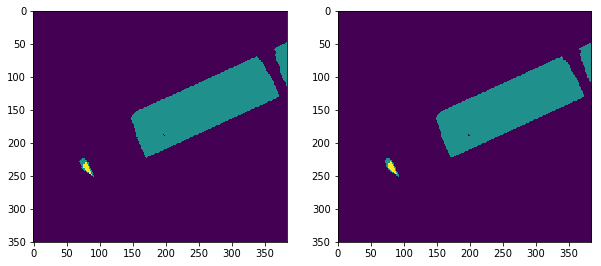

MAGNA_54_-1CL_0.0648253kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 55, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 191, Metal: 0, Groups total: 35.0


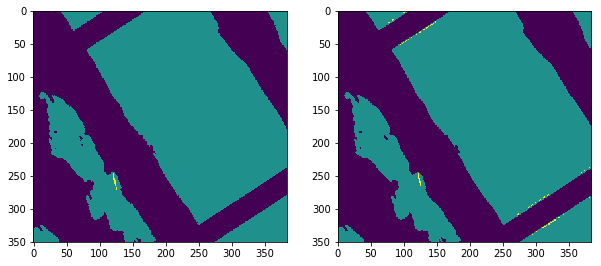

MAGNA_56_82.6415CL_3.68767kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 216, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 201, Metal: 0, Groups total: 1.0


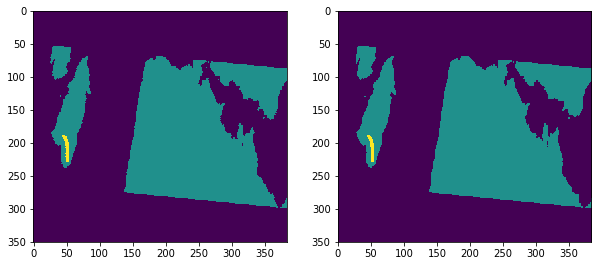

MAGNA_98_89.7745CL_3.48544kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 66, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 60, Metal: 0, Groups total: 2.0


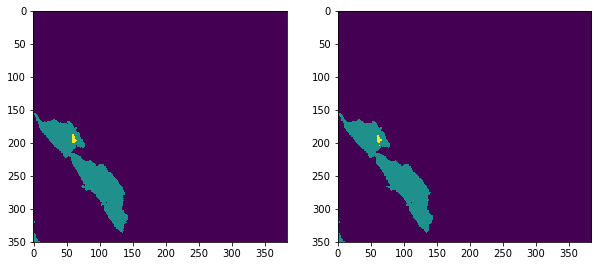

MAGNA_39_63.9493CL_2.97004kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 390, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 389, Metal: 0, Groups total: 3.0


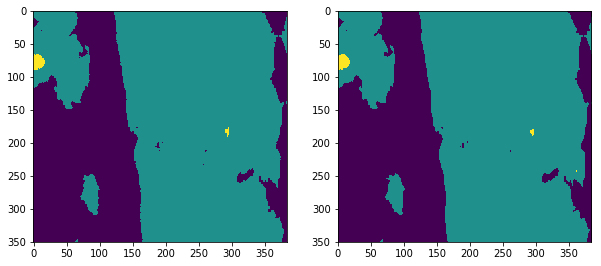

MAGNA_82_87.044CL_3.63926kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 102, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 100, Metal: 0, Groups total: 1.0


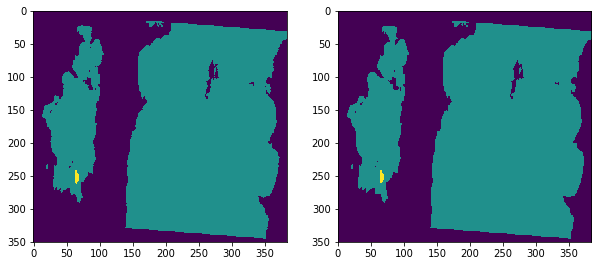

MAGNA_48_79.1419CL_3.25121kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 63, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 58, Metal: 0, Groups total: 1.0


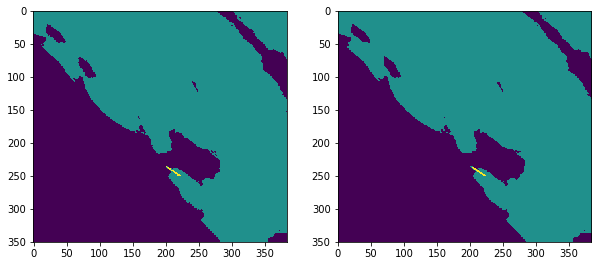

MAGNA_81_-1CL_0.18207kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 79, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 16, Metal: 0, Groups total: 2.0


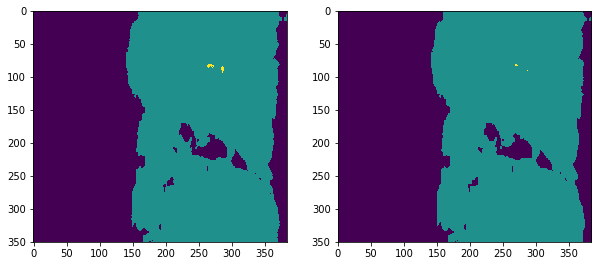

MAGNA_81_80.8616CL_2.68983kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 56, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 49, Metal: 0, Groups total: 1.0


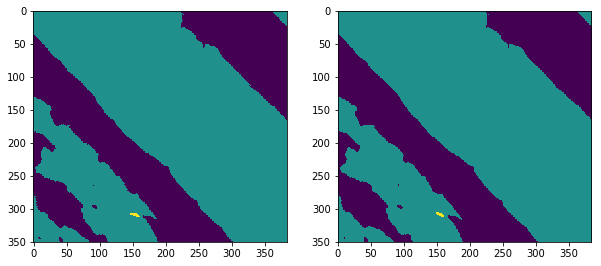

MAGNA_24_-1CL_0.155018kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 190, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 188, Metal: 0, Groups total: 1.0


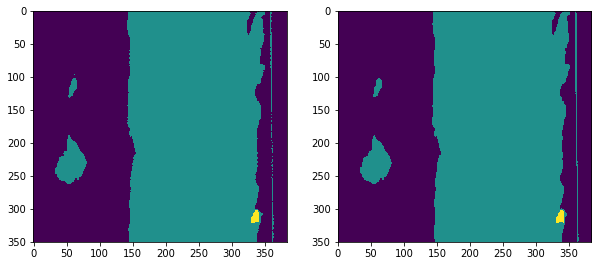

MAGNA_24_79.5085CL_3.74293kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 641, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 602, Metal: 0, Groups total: 1.0


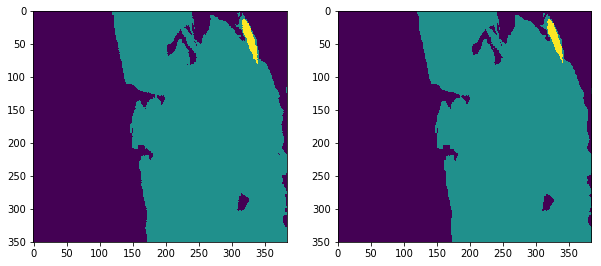

MAGNA_26_81.9243CL_2.95353kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 549, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 570, Metal: 0, Groups total: 1.0


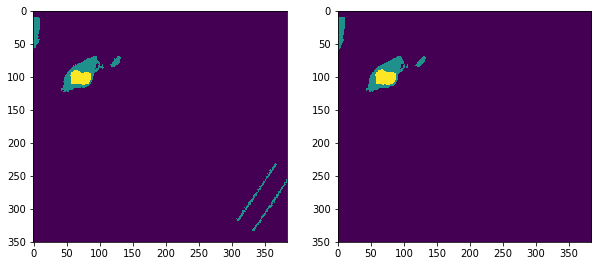

MAGNA_24_-1CL_0.00106925kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 110, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 128, Metal: 0, Groups total: 1.0


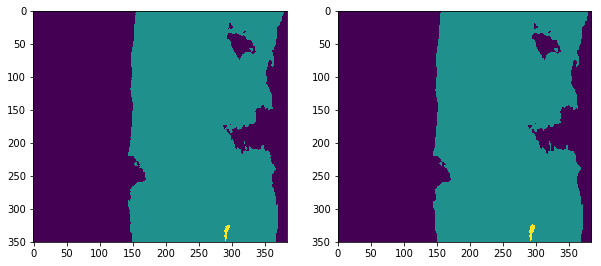

MAGNA_78_86.8299CL_3.16613kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 128, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 117, Metal: 0, Groups total: 1.0


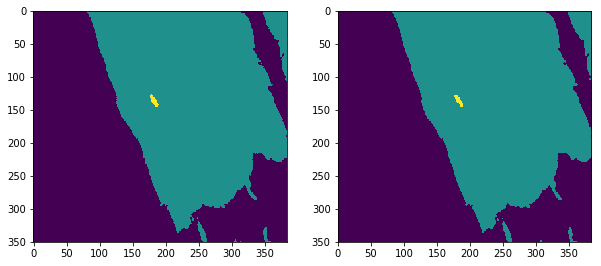

MAGNA_79_-1CL_0.143869kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 61, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 41, Metal: 0, Groups total: 1.0


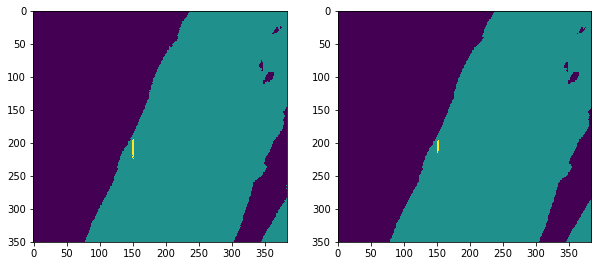

MAGNA_77_-1CL_0.0822478kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 108, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 403, Metal: 0, Groups total: 19.0


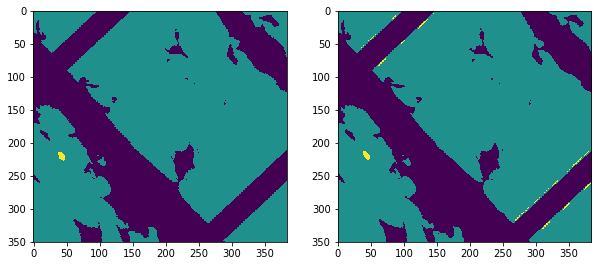

MAGNA_17_-1CL_0.00418111kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 303, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 294, Metal: 0, Groups total: 1.0


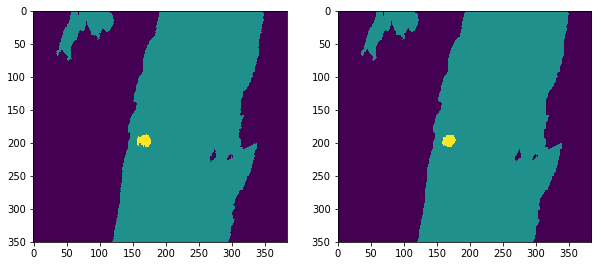

MAGNA_10_86.3651CL_3.75059kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 191, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 173, Metal: 0, Groups total: 2.0


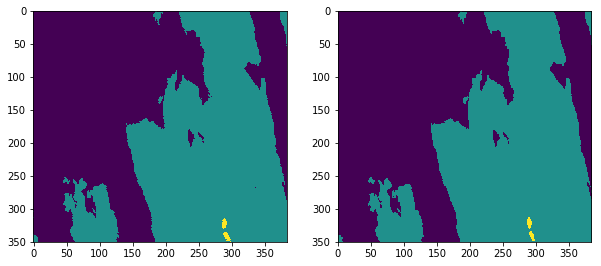

MAGNA_95_85.7897CL_4.09785kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 367, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 366, Metal: 0, Groups total: 2.0


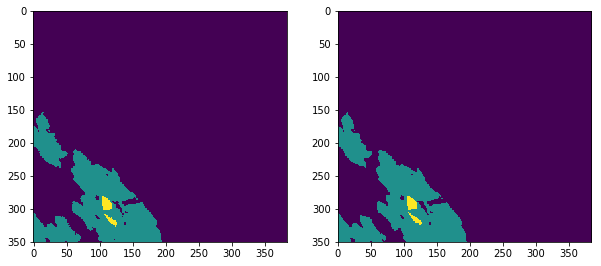

MAGNA_0_-1CL_0.721276kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 124, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 109, Metal: 0, Groups total: 2.0


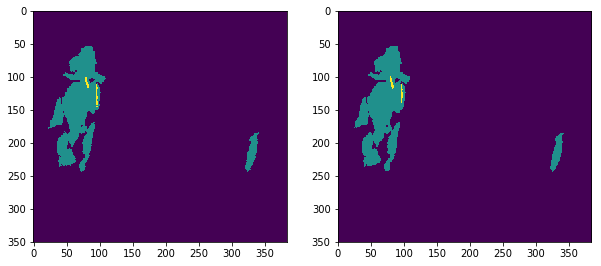

MAGNA_27_-1CL_0.306616kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 124, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 91, Metal: 0, Groups total: 3.0


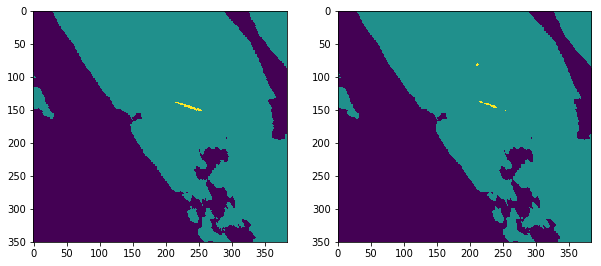

MAGNA_3_-1CL_0.587087kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 146, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 114, Metal: 0, Groups total: 1.0


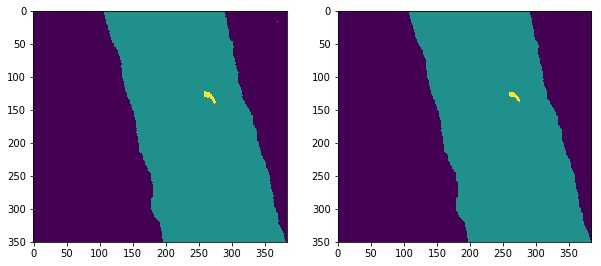

MAGNA_52_66.5655CL_1.48704kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 366, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 399, Metal: 0, Groups total: 6.0


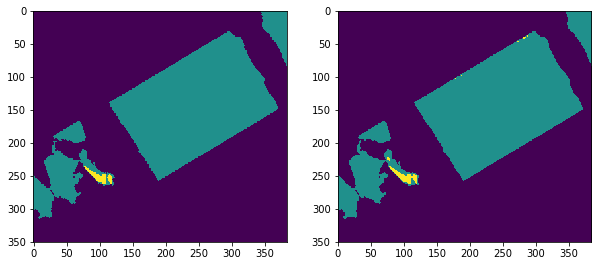

MAGNA_53_-1CL_0.166595kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 58, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 91, Metal: 0, Groups total: 1.0


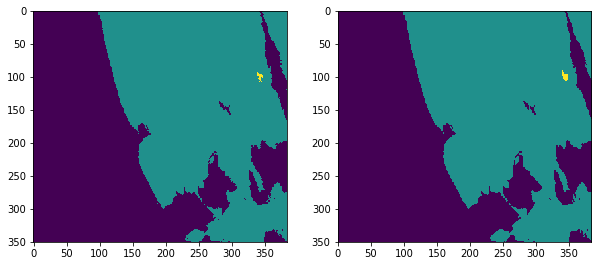

MAGNA_14_79.8359CL_3.52469kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 42, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 18, Metal: 0, Groups total: 1.0


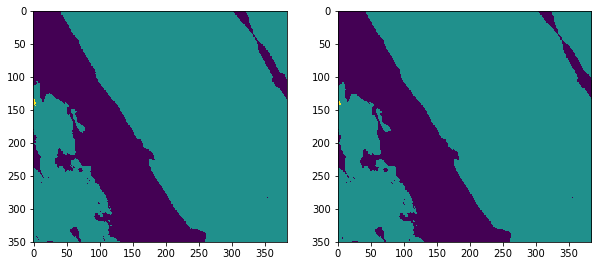

MAGNA_42_79.0224CL_1.34626kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 296, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 267, Metal: 0, Groups total: 1.0


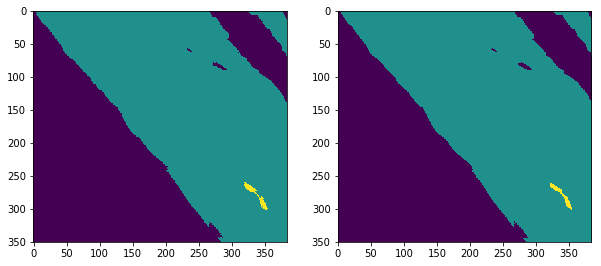

MAGNA_31_-1CL_0.0816763kg.tif
There is just Meat / Found just Meat
Pixel count
Ground truth -> Bone: 0, Metal: 0, Groups total: 0.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


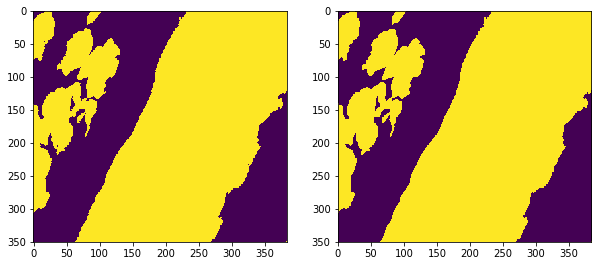

MAGNA_45_-1CL_0.0493642kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 61, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 343, Metal: 0, Groups total: 43.0


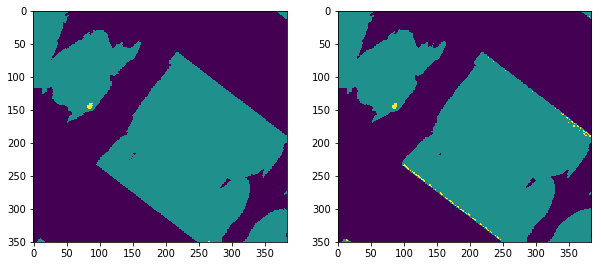

MAGNA_24_39.8052CL_2.86218kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 134, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 136, Metal: 0, Groups total: 1.0


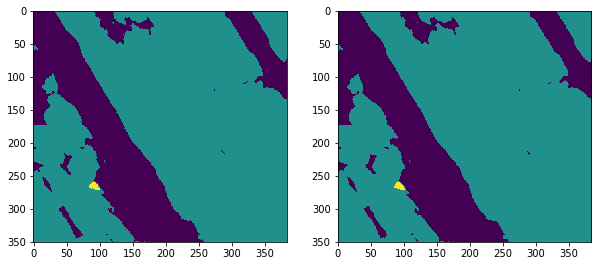

MAGNA_82_79.2874CL_3.25479kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 128, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 68, Metal: 0, Groups total: 2.0


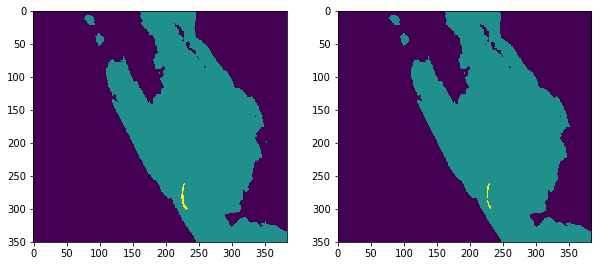

MAGNA_86_86.886CL_0.925006kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 110, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 124, Metal: 0, Groups total: 2.0


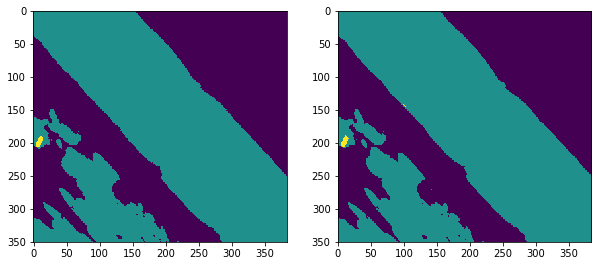

MAGNA_64_-1CL_0.186191kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 455, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 430, Metal: 0, Groups total: 2.0


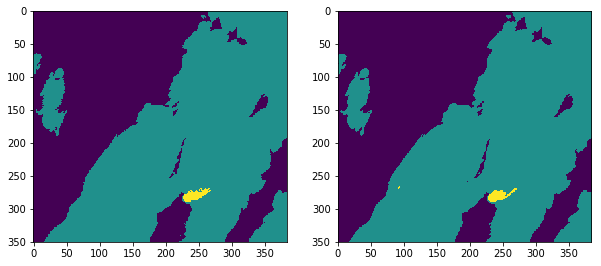

MAGNA_16_71.2603CL_3.08121kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 120, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 406, Metal: 0, Groups total: 57.0


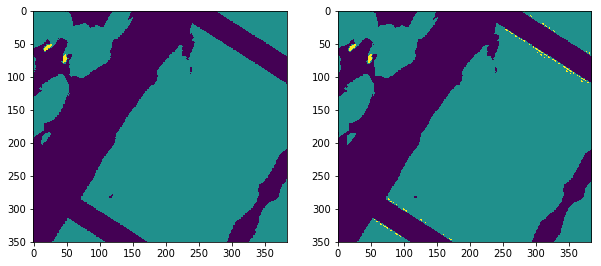

MAGNA_71_80.2131CL_3.8155kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 76, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 102, Metal: 0, Groups total: 2.0


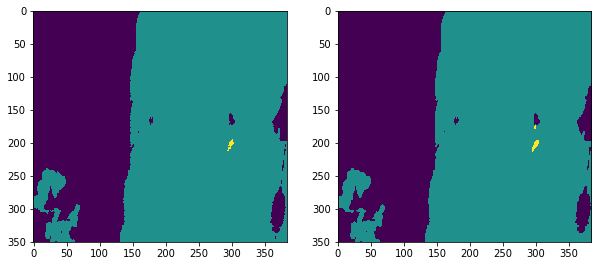

MAGNA_36_90.1525CL_2.10734kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 111, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 86, Metal: 0, Groups total: 3.0


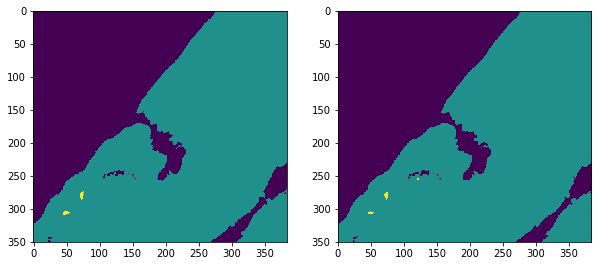

MAGNA_33_-1CL_6.59823e-05kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 147, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 124, Metal: 0, Groups total: 2.0


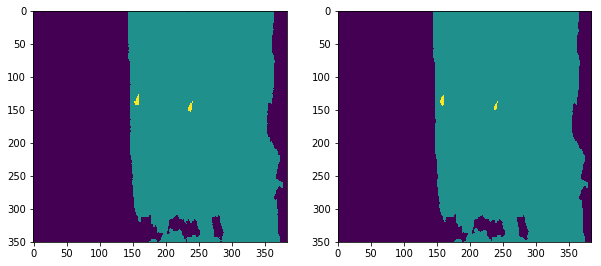

MAGNA_27_81.7682CL_3.27239kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 496, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 475, Metal: 0, Groups total: 8.0


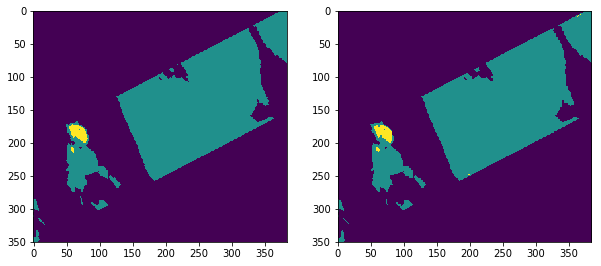

MAGNA_83_88.4856CL_3.33778kg.tif
There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 1, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


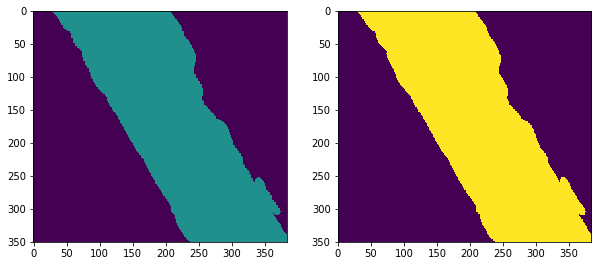

MAGNA_79_62.306CL_3.20773kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 69, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 88, Metal: 0, Groups total: 1.0


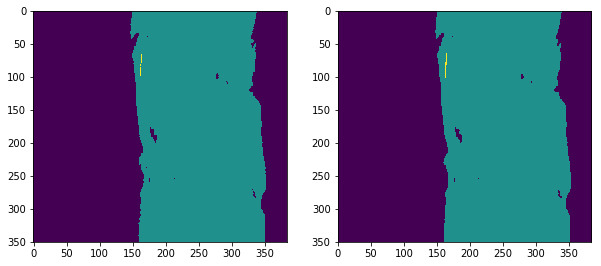

MAGNA_85_-1CL_0.000410071kg.tif
There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 115, Metal: 0, Groups total: 4.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


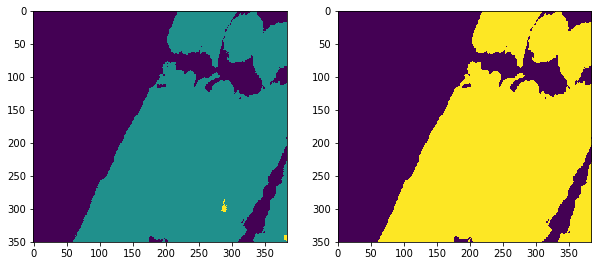

MAGNA_20_-1CL_0.0529042kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 265, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 337, Metal: 0, Groups total: 14.0


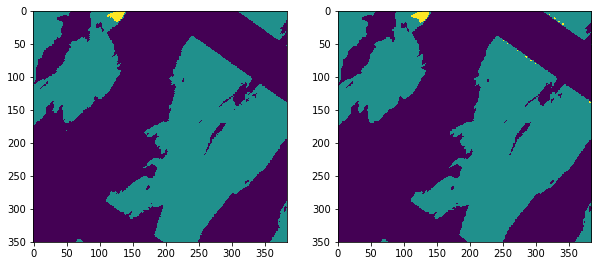

MAGNA_80_-1CL_0.357393kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 294, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 297, Metal: 0, Groups total: 1.0


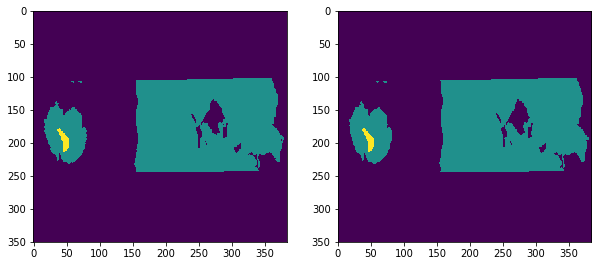

MAGNA_47_68.0581CL_3.03663kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 63, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 55, Metal: 0, Groups total: 1.0


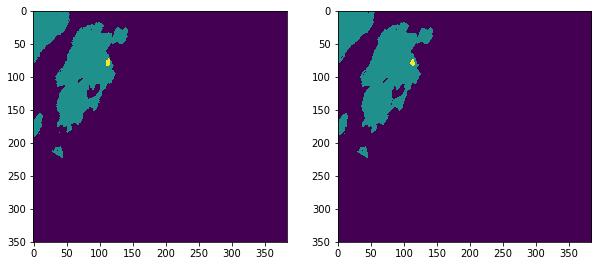

MAGNA_92_81.0269CL_3.30326kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 745, Metal: 0, Groups total: 7.0
Prediction   -> Bone: 763, Metal: 0, Groups total: 6.0


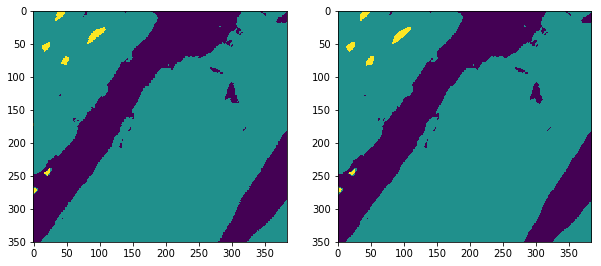

MAGNA_61_-1CL_0.445751kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 48, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 49, Metal: 0, Groups total: 1.0


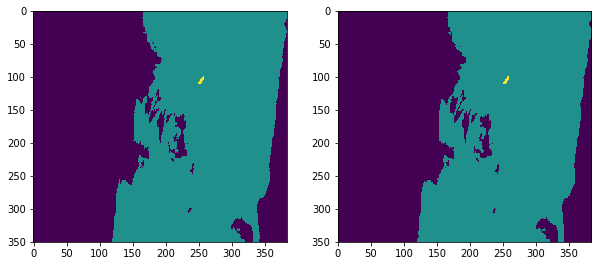

MAGNA_41_-1CL_0.0323025kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 130, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 135, Metal: 0, Groups total: 1.0


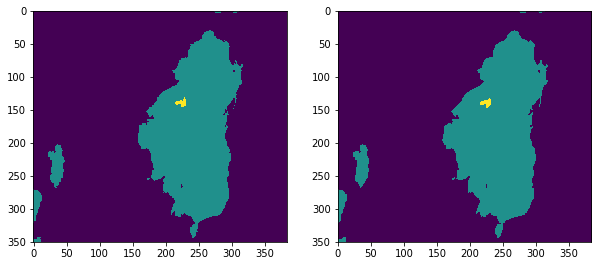

MAGNA_93_84.2319CL_3.50867kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 278, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 300, Metal: 0, Groups total: 2.0


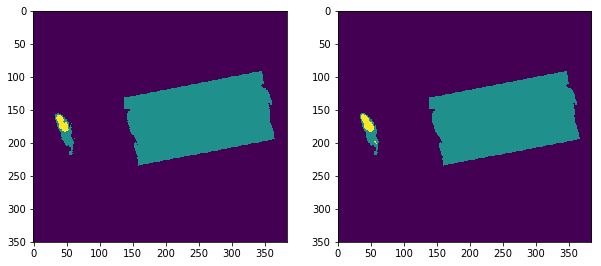

MAGNA_12_-1CL_1.10823kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 258, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 252, Metal: 0, Groups total: 1.0


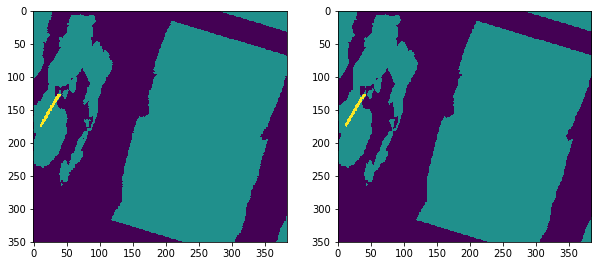

MAGNA_44_80.5775CL_3.35666kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 70, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 69, Metal: 0, Groups total: 2.0


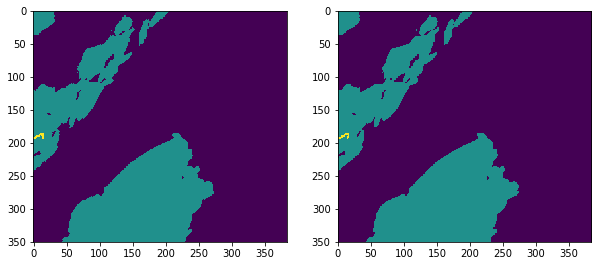

MAGNA_30_-1CL_0.00454832kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 1053, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 1060, Metal: 0, Groups total: 1.0


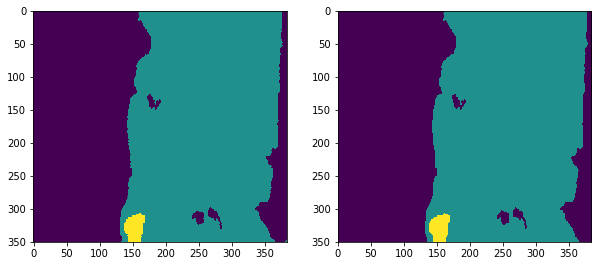

MAGNA_47_75.661CL_3.27193kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 2382, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 2341, Metal: 0, Groups total: 1.0


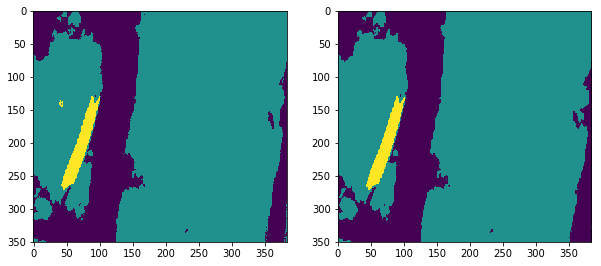

MAGNA_83_-1CL_0.402621kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 86, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 115, Metal: 0, Groups total: 1.0


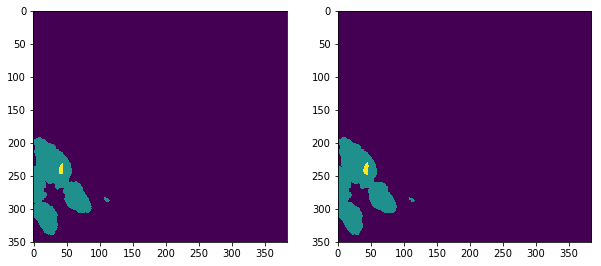

MAGNA_15_77.8942CL_3.45943kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 139, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 153, Metal: 0, Groups total: 9.0


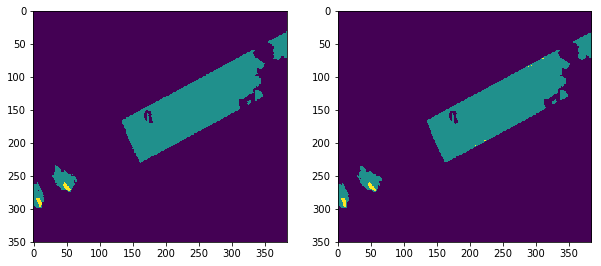

MAGNA_92_-1CL_0.00238437kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 35, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 36, Metal: 0, Groups total: 1.0


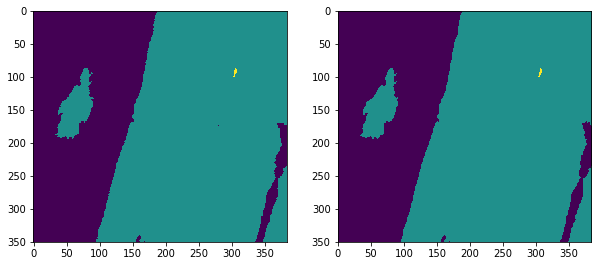

MAGNA_25_69.1448CL_3.30388kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 892, Metal: 0, Groups total: 10.0
Prediction   -> Bone: 758, Metal: 0, Groups total: 12.0


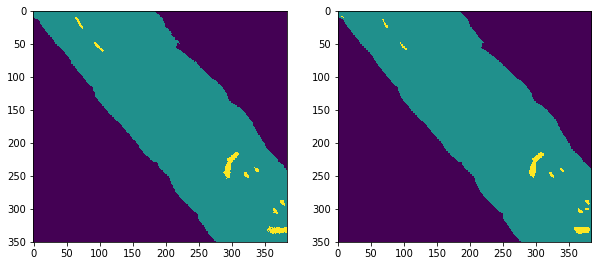

MAGNA_55_90.8834CL_3.16415kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 201, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 188, Metal: 0, Groups total: 3.0


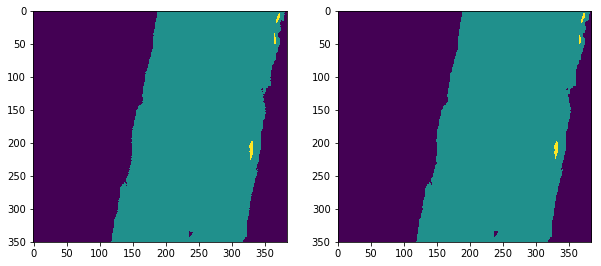

MAGNA_91_-1CL_0.677009kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 147, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 153, Metal: 0, Groups total: 1.0


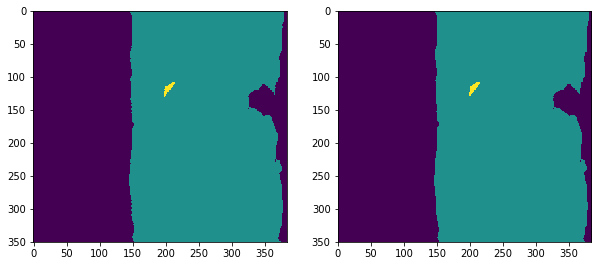

MAGNA_82_72.1316CL_3.28561kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 48, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 38, Metal: 0, Groups total: 1.0


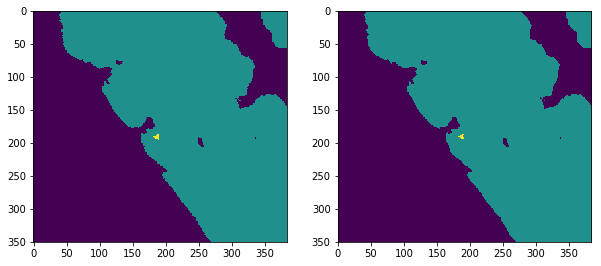

MAGNA_1_74.4595CL_1.99998kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 68, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 44, Metal: 0, Groups total: 1.0


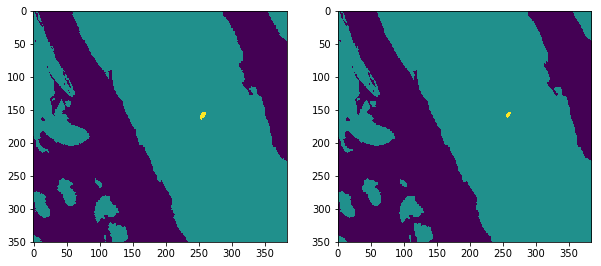

MAGNA_3_65.46CL_3.45164kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 83, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 82, Metal: 0, Groups total: 1.0


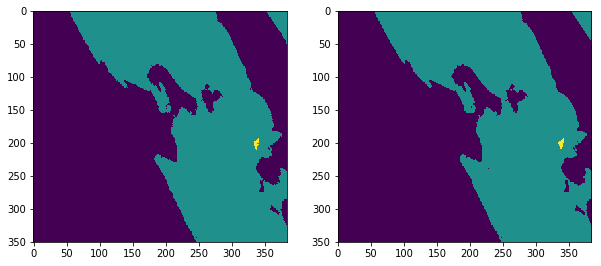

MAGNA_14_84.8098CL_3.43754kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 54, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 23, Metal: 0, Groups total: 1.0


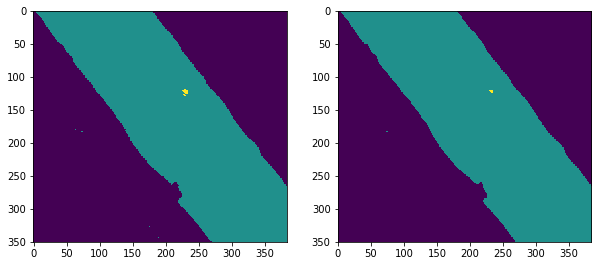

MAGNA_29_60.1052CL_3.2912kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 1741, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 1705, Metal: 0, Groups total: 3.0


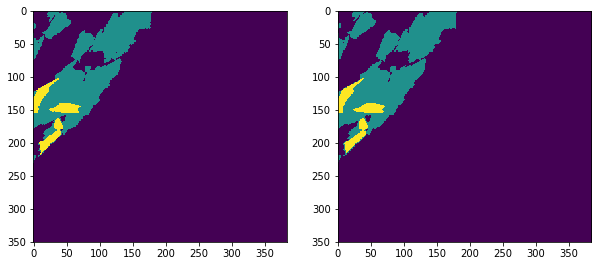

MAGNA_6_85.9111CL_2.85779kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 1574, Metal: 0, Groups total: 4.0
Prediction   -> Bone: 1539, Metal: 0, Groups total: 3.0


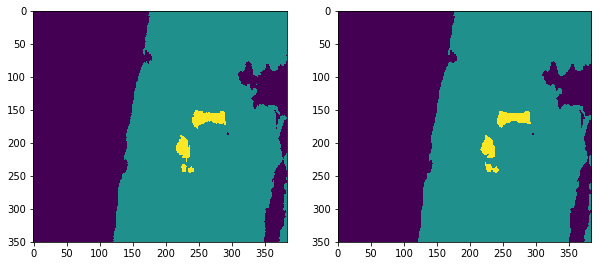

MAGNA_31_86.5054CL_3.46323kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 466, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 363, Metal: 0, Groups total: 2.0


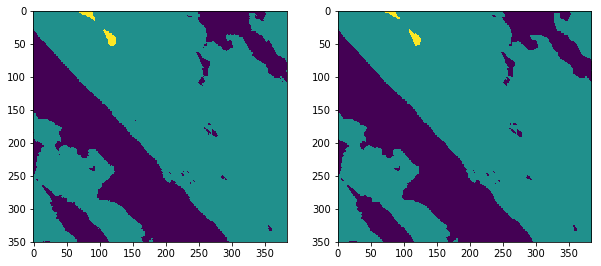

MAGNA_44_-1CL_0.118486kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 106, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 126, Metal: 0, Groups total: 1.0


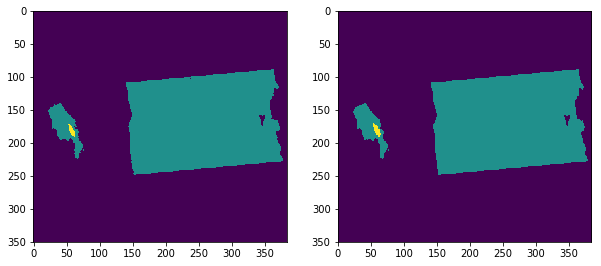

MAGNA_69_78.9739CL_3.37924kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 168, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 371, Metal: 0, Groups total: 39.0


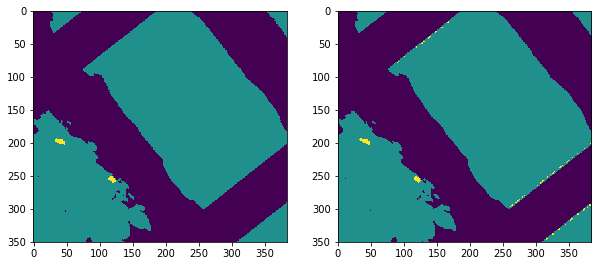

MAGNA_91_-1CL_0.0161502kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 1581, Metal: 0, Groups total: 4.0
Prediction   -> Bone: 1660, Metal: 0, Groups total: 11.0


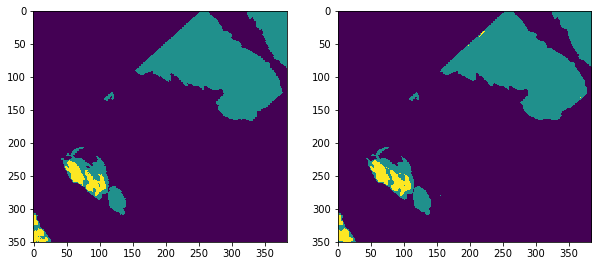

MAGNA_79_79.6367CL_3.61192kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 233, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 219, Metal: 0, Groups total: 1.0


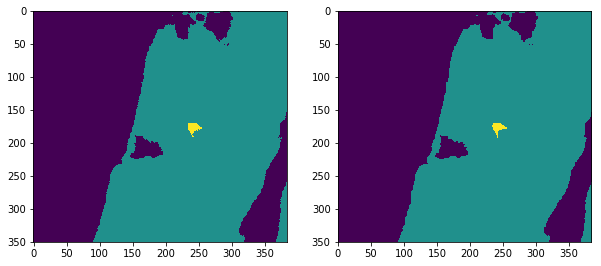

MAGNA_85_-1CL_0.399708kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 105, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 80, Metal: 0, Groups total: 2.0


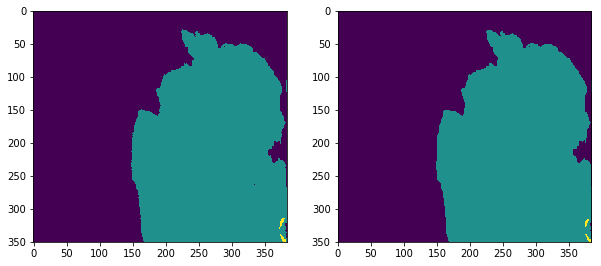

MAGNA_72_57.7391CL_2.68171kg.tif
There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 59, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


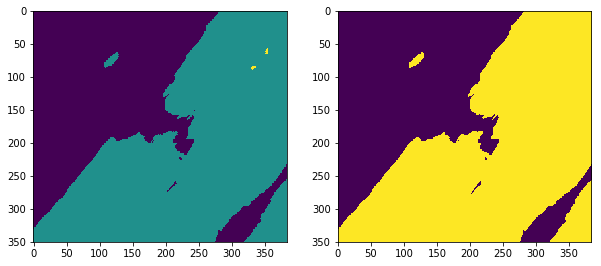

MAGNA_7_-1CL_0.248778kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 436, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 452, Metal: 0, Groups total: 3.0


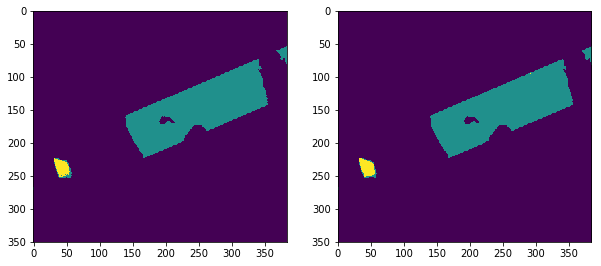

MAGNA_34_75.8324CL_3.68237kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 159, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 98, Metal: 0, Groups total: 3.0


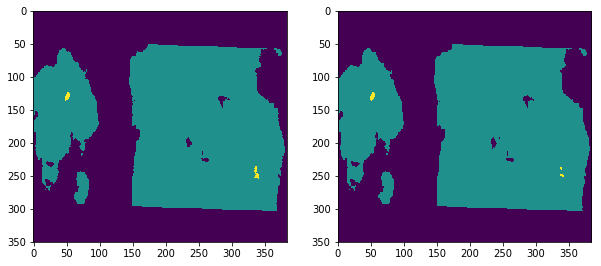

MAGNA_44_78.9465CL_3.33958kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 251, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 391, Metal: 0, Groups total: 36.0


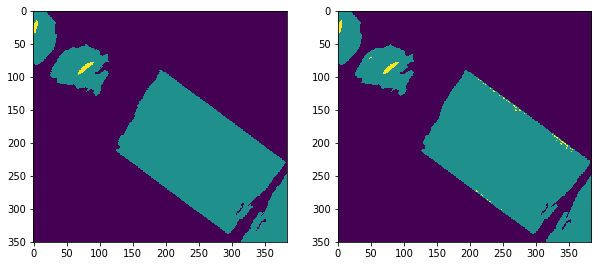

MAGNA_45_-1CL_0.0285345kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 238, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 234, Metal: 0, Groups total: 1.0


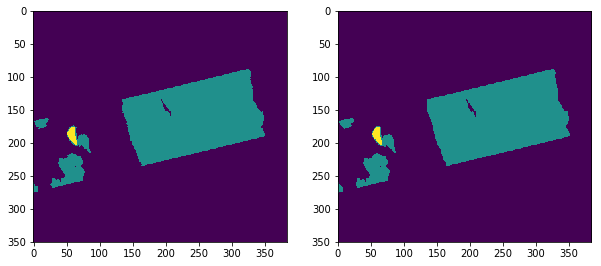

MAGNA_29_66.0971CL_2.8944kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 326, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 332, Metal: 0, Groups total: 3.0


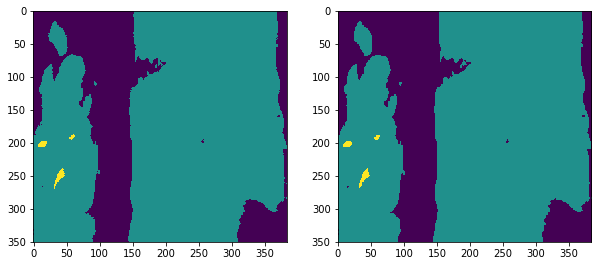

MAGNA_68_-1CL_0.0934954kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 273, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 240, Metal: 0, Groups total: 1.0


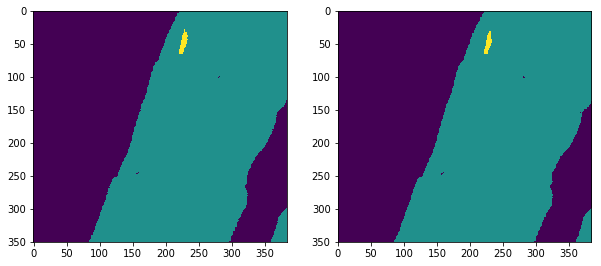

MAGNA_34_-1CL_0.00373579kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 73, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 126, Metal: 0, Groups total: 31.0


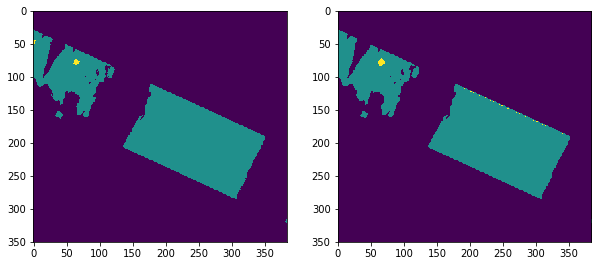

MAGNA_81_78.2427CL_3.75075kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 116, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 162, Metal: 0, Groups total: 3.0


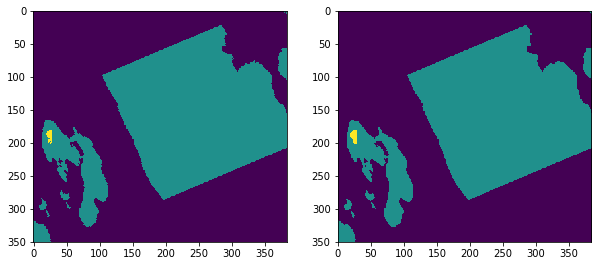

MAGNA_9_-1CL_0.432979kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 128, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 113, Metal: 0, Groups total: 1.0


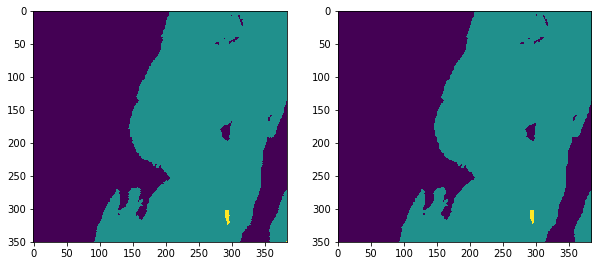

MAGNA_69_82.9344CL_3.54349kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 98, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 99, Metal: 0, Groups total: 1.0


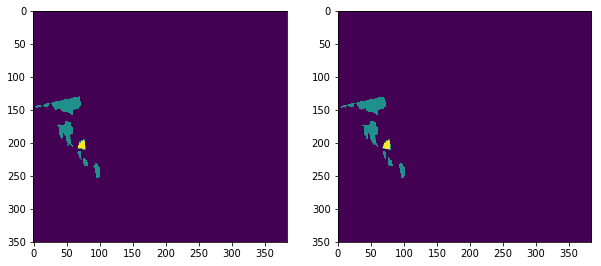

MAGNA_34_-1CL_0.0076272kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 140, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 135, Metal: 0, Groups total: 1.0


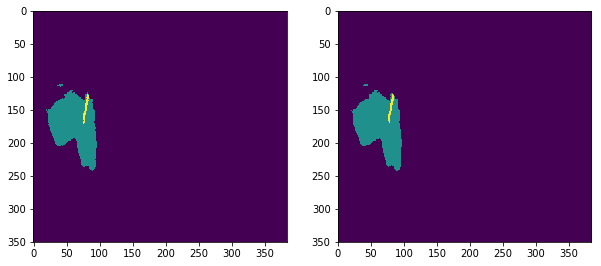

MAGNA_41_81.9042CL_2.8871kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 285, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 281, Metal: 0, Groups total: 1.0


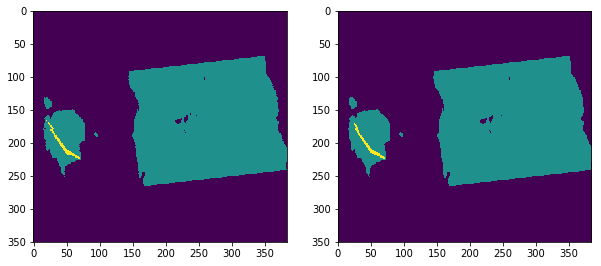

MAGNA_59_77.2952CL_3.97632kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 154, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 94, Metal: 0, Groups total: 2.0


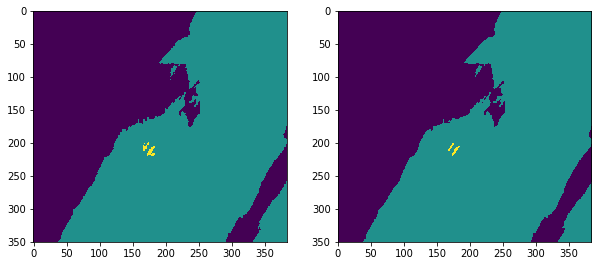

MAGNA_2_80.2708CL_3.43794kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 18, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 2, Metal: 0, Groups total: 1.0


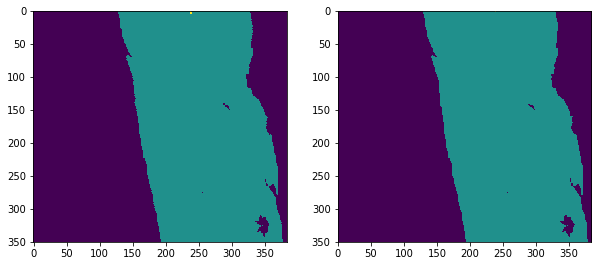

MAGNA_13_88.3047CL_2.54409kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 112, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 83, Metal: 0, Groups total: 2.0


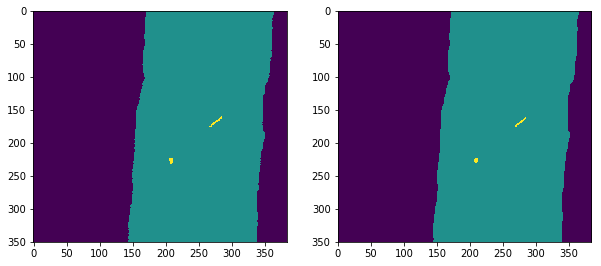

MAGNA_63_84.0101CL_2.96566kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 342, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 332, Metal: 0, Groups total: 1.0


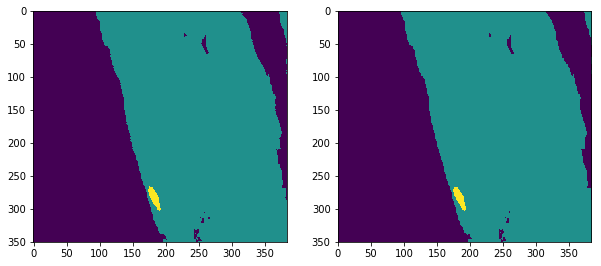

MAGNA_66_-1CL_0.194726kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 96, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 107, Metal: 0, Groups total: 14.0


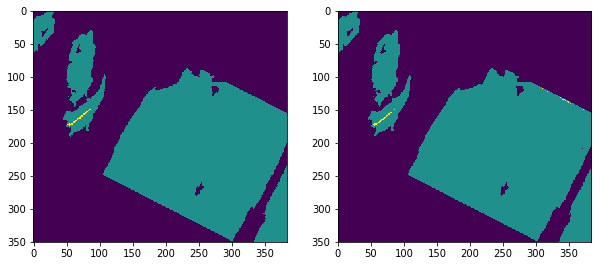

MAGNA_66_-1CL_0.160457kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 242, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 323, Metal: 0, Groups total: 1.0


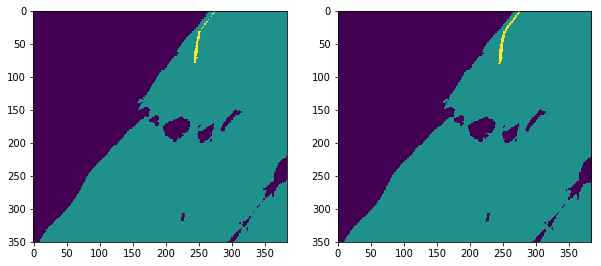

MAGNA_93_-1CL_0.144413kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 112, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 500, Metal: 0, Groups total: 29.0


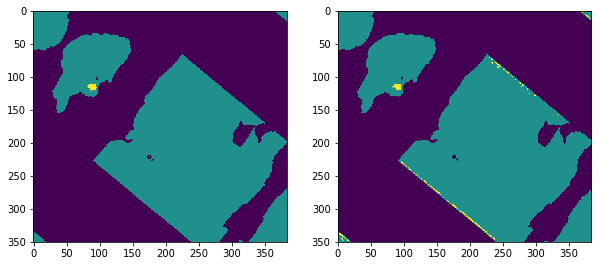

MAGNA_86_84.5379CL_3.34605kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 224, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 213, Metal: 0, Groups total: 1.0


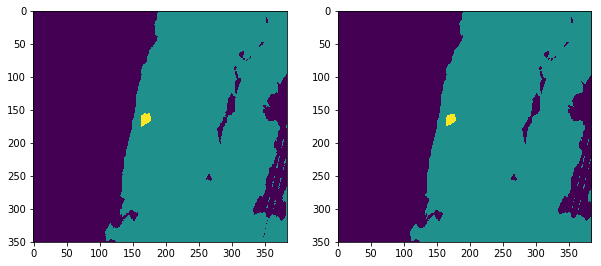

MAGNA_3_-1CL_0.0212994kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 395, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 348, Metal: 0, Groups total: 1.0


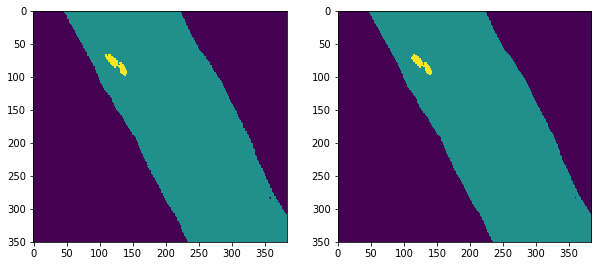

MAGNA_22_56.9273CL_3.53529kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 132, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 126, Metal: 0, Groups total: 1.0


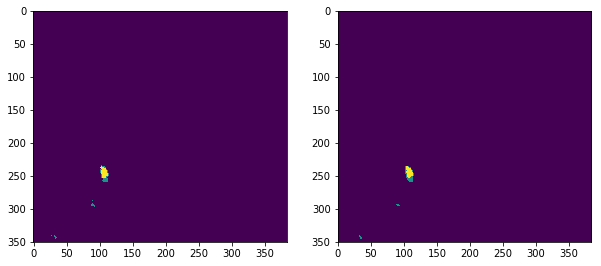

MAGNA_67_51.2585CL_3.09606kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 523, Metal: 0, Groups total: 4.0
Prediction   -> Bone: 463, Metal: 0, Groups total: 5.0


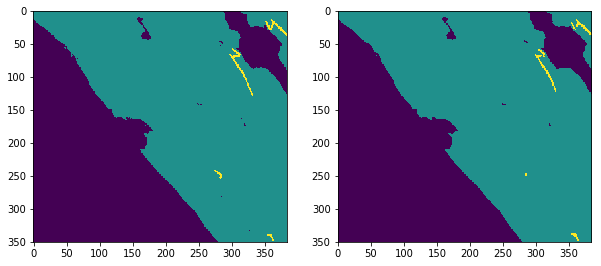

MAGNA_58_-1CL_1.15471e-05kg.tif
There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 109, Metal: 0, Groups total: 4.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


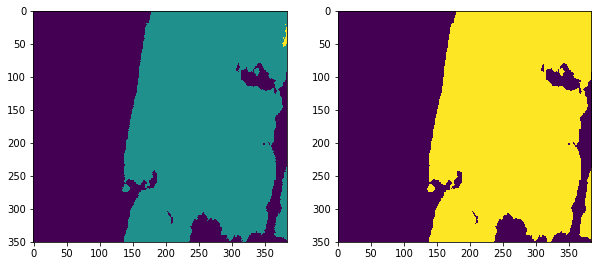

MAGNA_97_88.6432CL_3.52477kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 519, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 610, Metal: 0, Groups total: 12.0


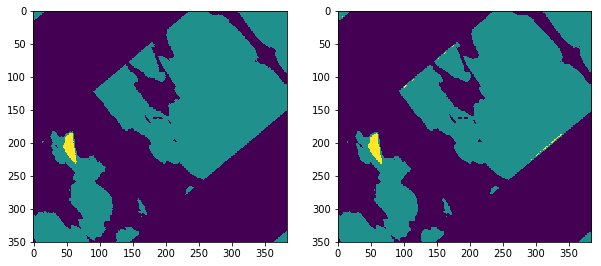

MAGNA_6_87.6822CL_3.11912kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 270, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 283, Metal: 0, Groups total: 2.0


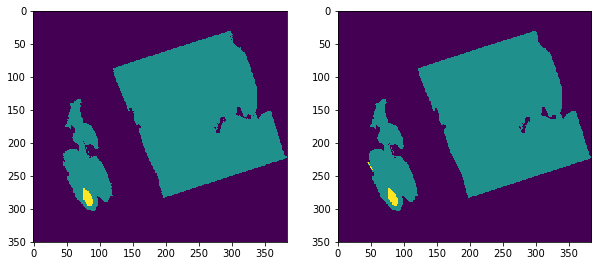

MAGNA_72_-1CL_0.551044kg.tif
There is Metal / Found Bone
Pixel count
Ground truth -> Bone: 0, Metal: 2, Groups total: 1.0
Prediction   -> Bone: 1, Metal: 0, Groups total: 1.0


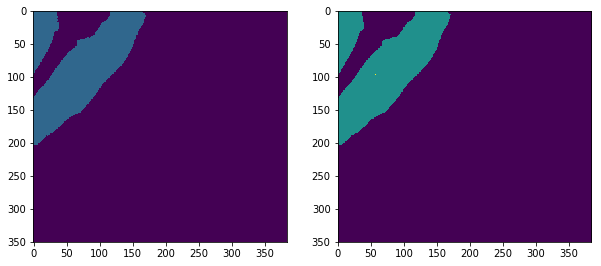

MAGNA_6_72.5699CL_3.88919kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 291, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 315, Metal: 0, Groups total: 18.0


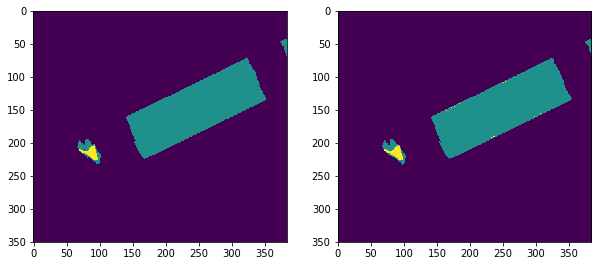

MAGNA_36_80.4522CL_3.42404kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 59, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 64, Metal: 0, Groups total: 1.0


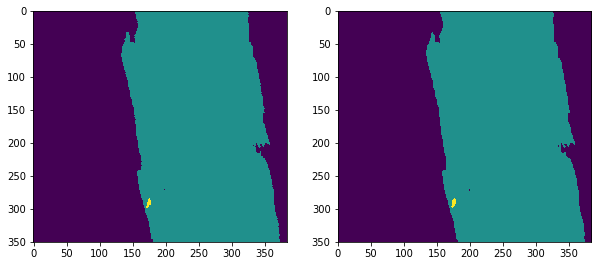

MAGNA_49_-1CL_0.344889kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 715, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 715, Metal: 0, Groups total: 3.0


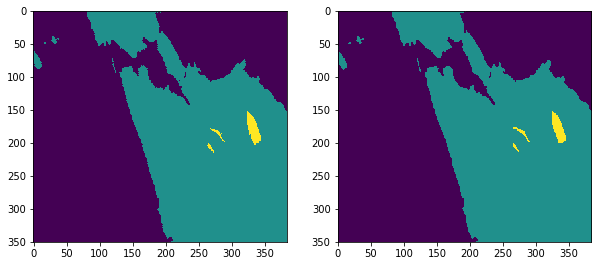

MAGNA_79_86.0572CL_3.53474kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 71, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 435, Metal: 0, Groups total: 56.0


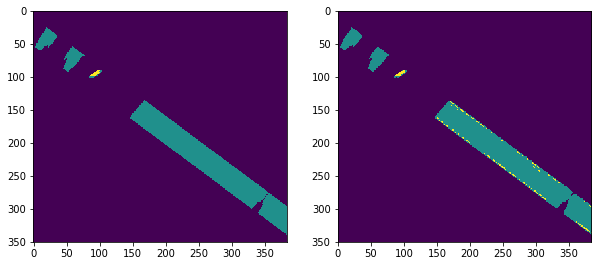

MAGNA_63_-1CL_0.186964kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 4247, Metal: 0, Groups total: 8.0
Prediction   -> Bone: 4160, Metal: 0, Groups total: 9.0


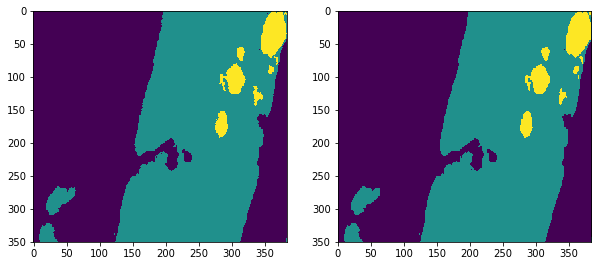

MAGNA_8_82.3632CL_2.78678kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 322, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 385, Metal: 0, Groups total: 20.0


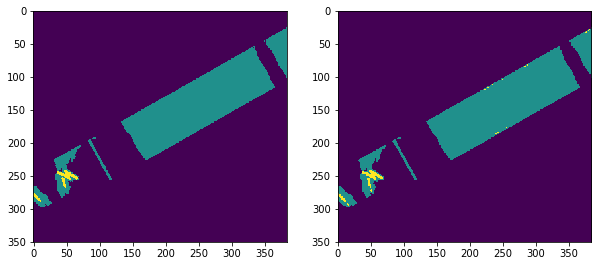

MAGNA_48_68.8851CL_3.3717kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 94, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 77, Metal: 0, Groups total: 3.0


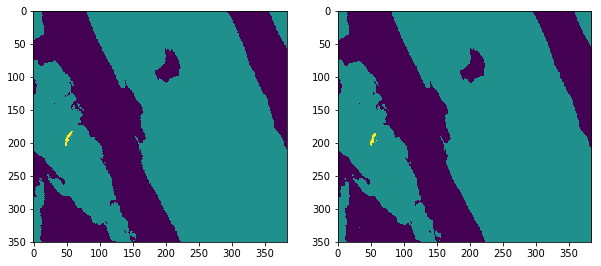

MAGNA_1_66.4419CL_1.45449kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 93, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 107, Metal: 0, Groups total: 2.0


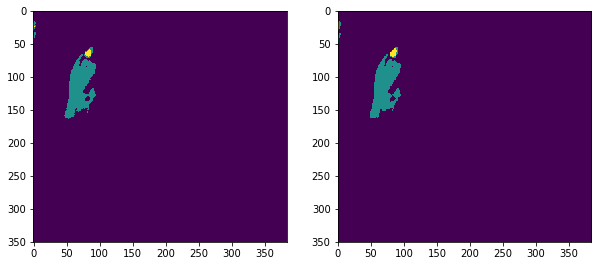

MAGNA_1_-1CL_0.289403kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 69, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 65, Metal: 0, Groups total: 3.0


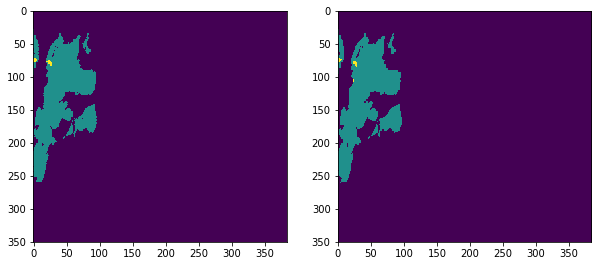

MAGNA_73_86.5606CL_3.53733kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 234, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 232, Metal: 0, Groups total: 1.0


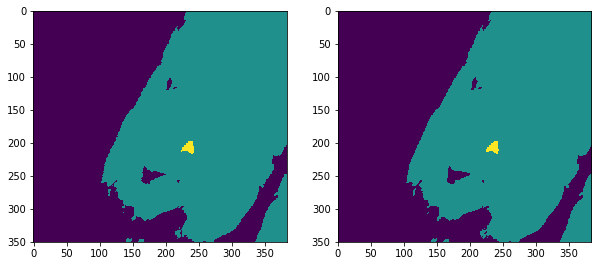

MAGNA_43_50.1599CL_2.17335kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 45, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 31, Metal: 0, Groups total: 1.0


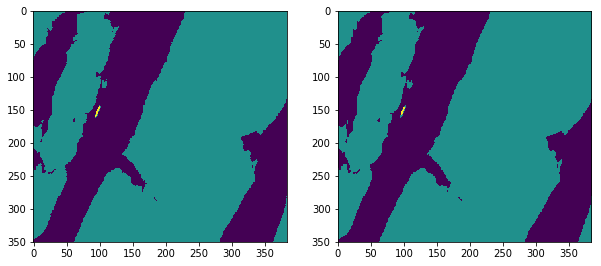

MAGNA_57_59.7945CL_4.32295kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 619, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 616, Metal: 0, Groups total: 2.0


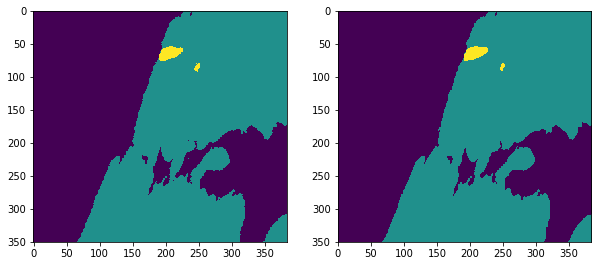

MAGNA_99_81.5435CL_3.26536kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 82, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 84, Metal: 0, Groups total: 1.0


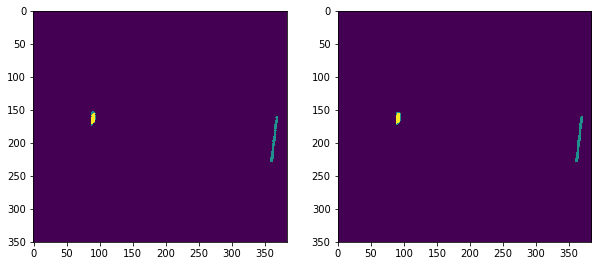

MAGNA_60_79.7683CL_3.488kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 146, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 107, Metal: 0, Groups total: 5.0


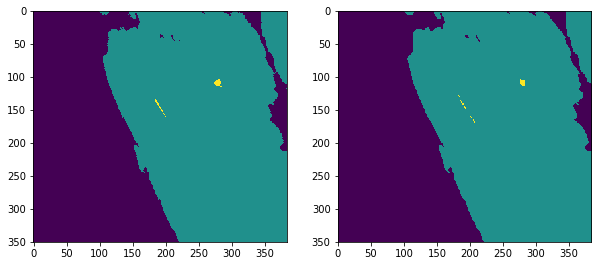

MAGNA_92_-1CL_0.252966kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 67, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 73, Metal: 0, Groups total: 1.0


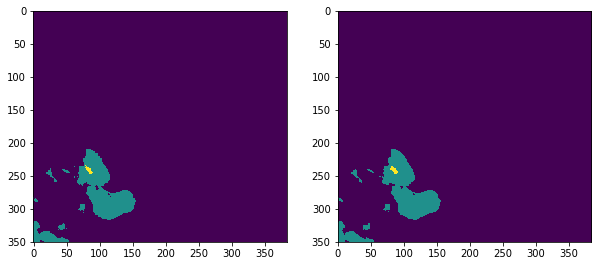

MAGNA_32_-1CL_0.0434373kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 570, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 572, Metal: 0, Groups total: 2.0


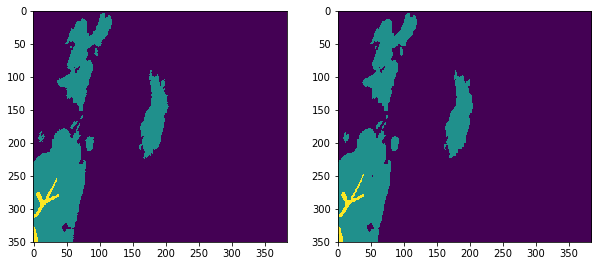

MAGNA_46_-1CL_0.0103788kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 293, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 305, Metal: 0, Groups total: 3.0


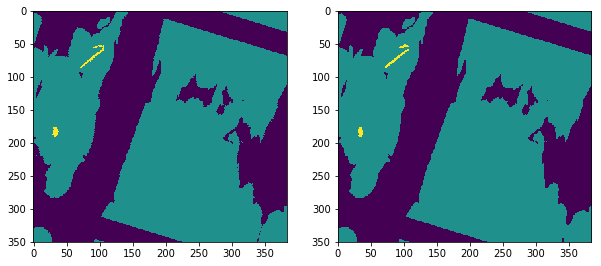

MAGNA_36_85.6874CL_3.40443kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 180, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 172, Metal: 0, Groups total: 1.0


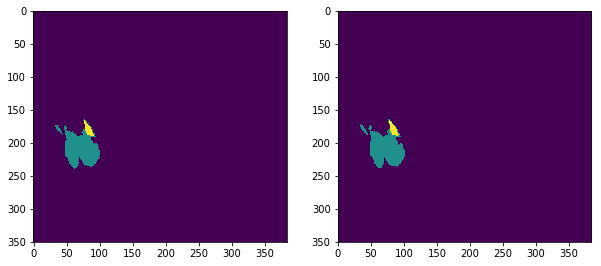

MAGNA_44_-1CL_0.389536kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 238, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 252, Metal: 0, Groups total: 1.0


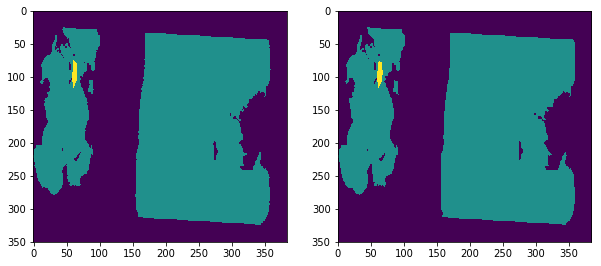

MAGNA_15_-1CL_0.482093kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 689, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 734, Metal: 0, Groups total: 20.0


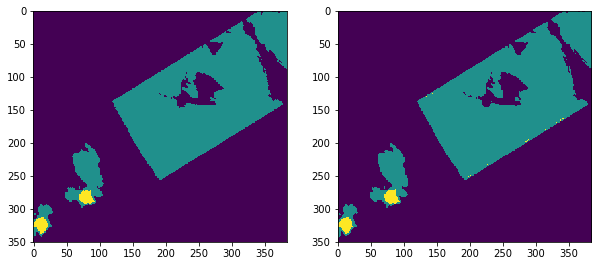

MAGNA_25_82.4591CL_3.51874kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 226, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 216, Metal: 0, Groups total: 1.0


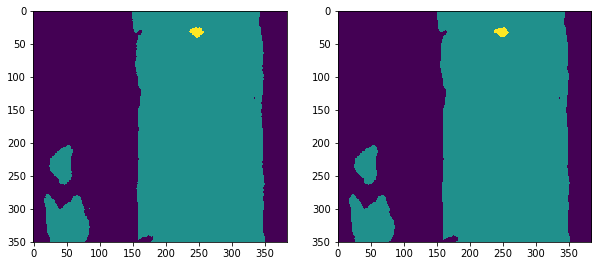

MAGNA_86_-1CL_0.443087kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 763, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 695, Metal: 0, Groups total: 3.0


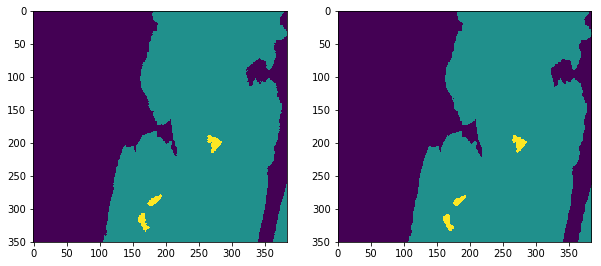

MAGNA_15_-1CL_0.392633kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 82, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 2, Metal: 0, Groups total: 1.0


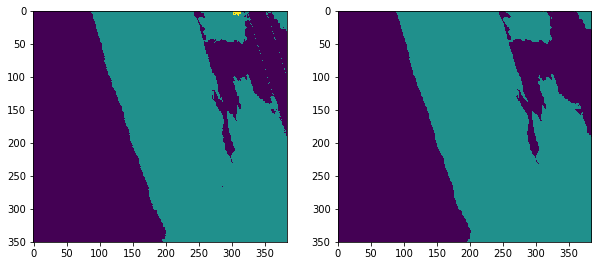

MAGNA_94_-1CL_0.168604kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 200, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 234, Metal: 0, Groups total: 1.0


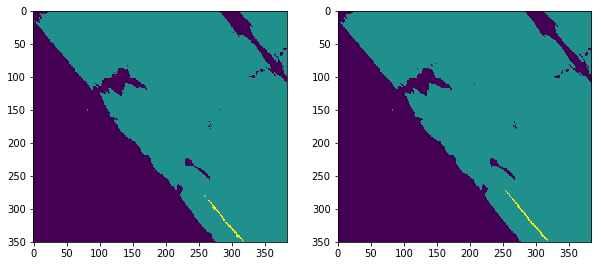

MAGNA_81_84.4873CL_3.66978kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 90, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 56, Metal: 0, Groups total: 1.0


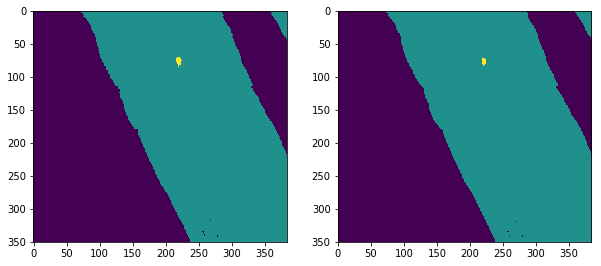

MAGNA_63_-1CL_0.108554kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 380, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 383, Metal: 0, Groups total: 6.0


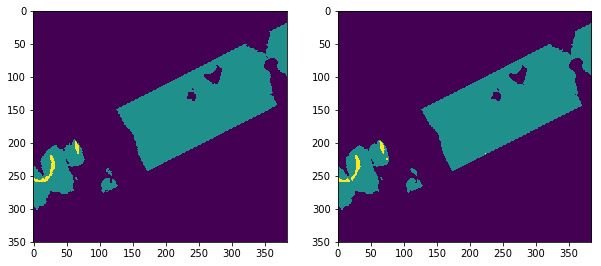

MAGNA_67_86.3736CL_3.47733kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 73, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 253, Metal: 0, Groups total: 44.0


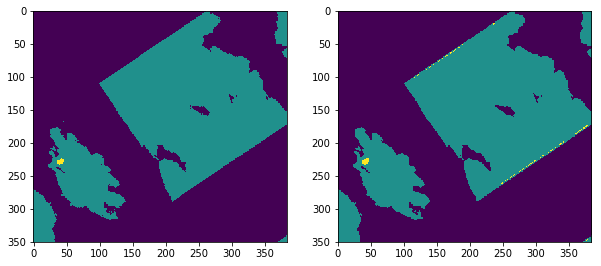

MAGNA_59_87.1681CL_3.21736kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 53, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 46, Metal: 0, Groups total: 1.0


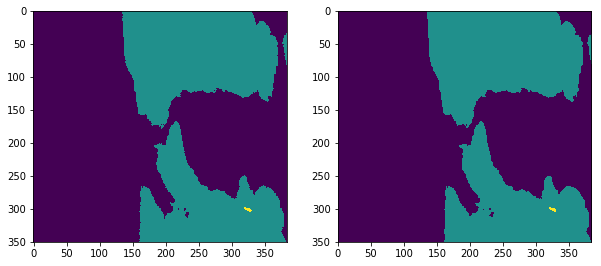

MAGNA_86_69.9138CL_2.39074kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 46, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 54, Metal: 0, Groups total: 2.0


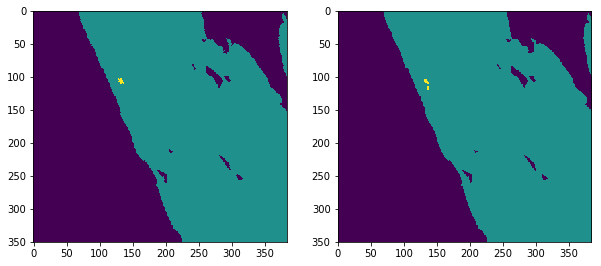

MAGNA_2_73.6009CL_2.582kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 120, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 128, Metal: 0, Groups total: 1.0


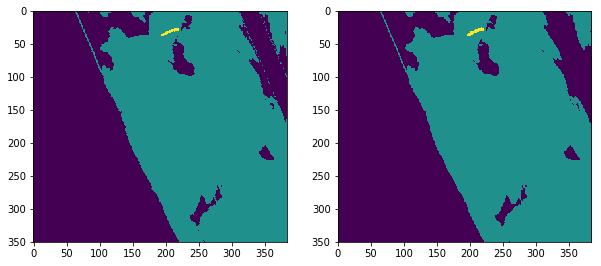

MAGNA_99_-1CL_0.0186911kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 41, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 42, Metal: 0, Groups total: 1.0


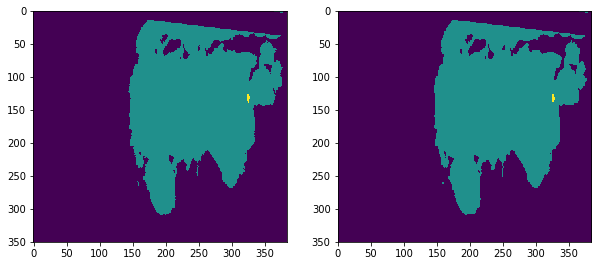

MAGNA_38_72.4827CL_2.36659kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 41, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 199, Metal: 0, Groups total: 30.0


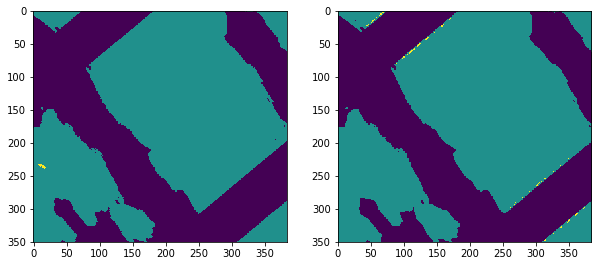

MAGNA_46_-1CL_0.586659kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 252, Metal: 0, Groups total: 4.0
Prediction   -> Bone: 244, Metal: 0, Groups total: 4.0


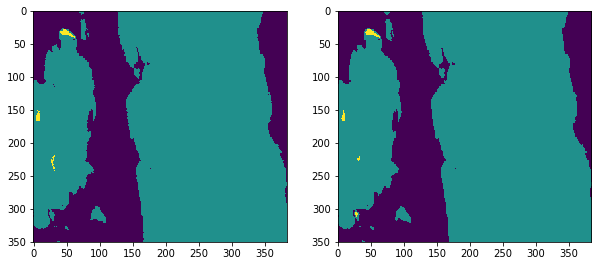

MAGNA_98_-1CL_0.0569169kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 699, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 679, Metal: 0, Groups total: 2.0


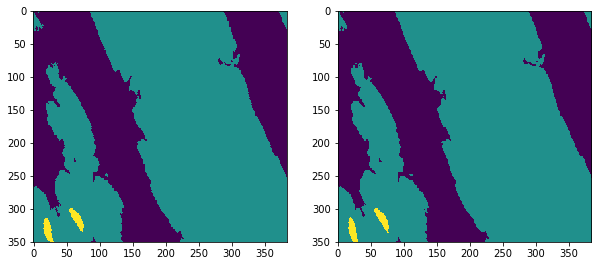

MAGNA_41_56.1737CL_3.31147kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 159, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 200, Metal: 0, Groups total: 15.0


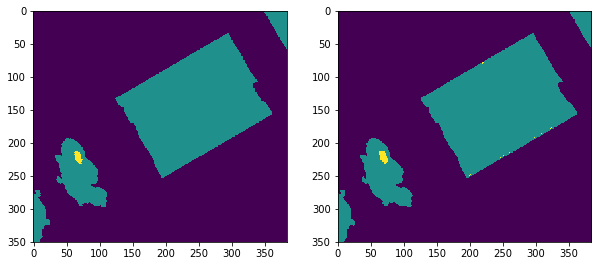

MAGNA_21_78.2945CL_3.28716kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 180, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 120, Metal: 0, Groups total: 1.0


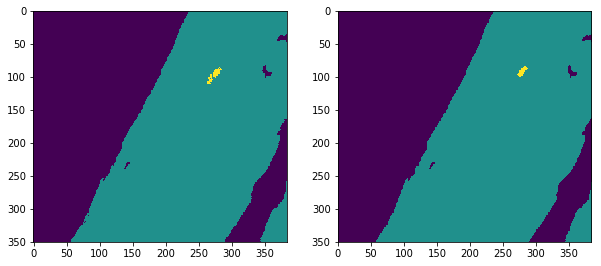

MAGNA_25_-1CL_0.0752486kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 195, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 156, Metal: 0, Groups total: 2.0


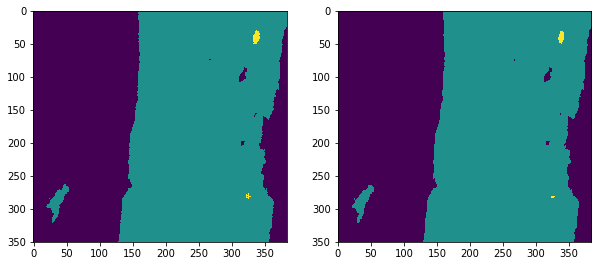

MAGNA_14_83.668CL_3.59192kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 95, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 84, Metal: 0, Groups total: 1.0


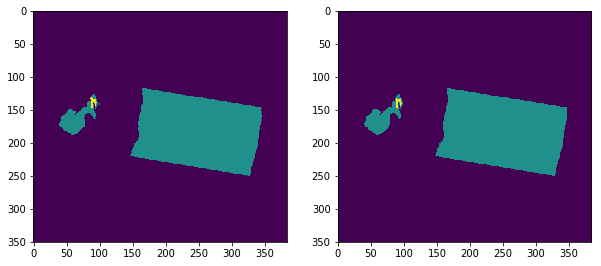

MAGNA_50_-1CL_0.0831383kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 83, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 82, Metal: 0, Groups total: 1.0


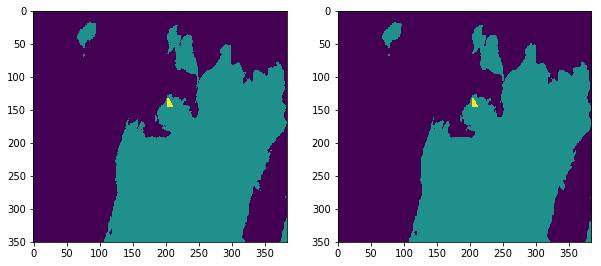

MAGNA_0_86.66CL_3.51478kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 158, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 156, Metal: 0, Groups total: 1.0


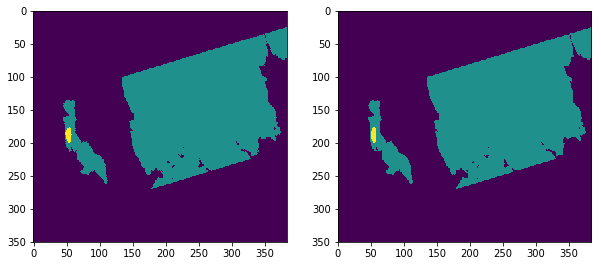

MAGNA_39_-1CL_0.550654kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 43, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 48, Metal: 0, Groups total: 1.0


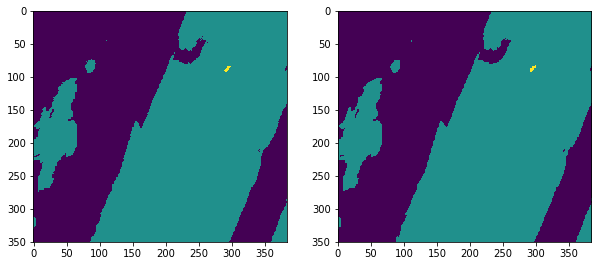

MAGNA_63_-1CL_0.366077kg.tif
There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 44, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


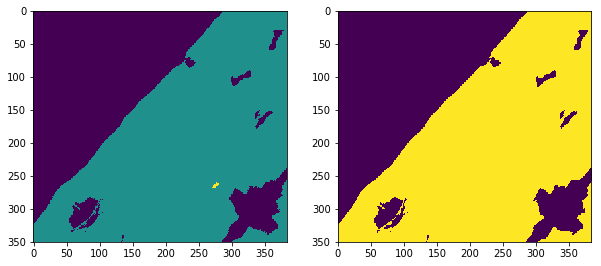

MAGNA_48_92.7203CL_3.62864kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 714, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 718, Metal: 0, Groups total: 1.0


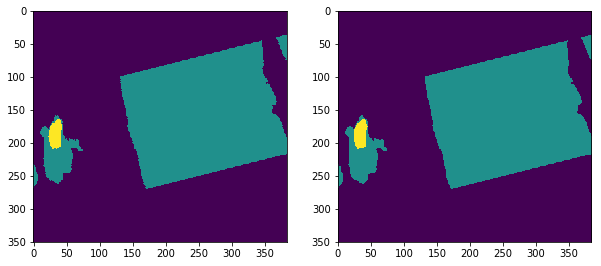

MAGNA_65_90.6329CL_3.29406kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 99, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 80, Metal: 0, Groups total: 1.0


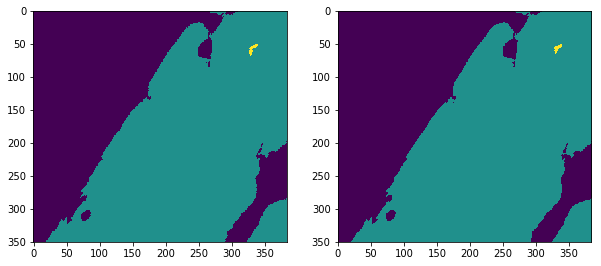

MAGNA_34_72.1981CL_1.41007kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 369, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 386, Metal: 0, Groups total: 2.0


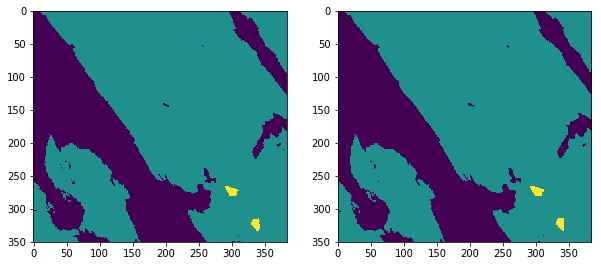

MAGNA_32_89.919CL_3.52122kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 162, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 155, Metal: 0, Groups total: 1.0


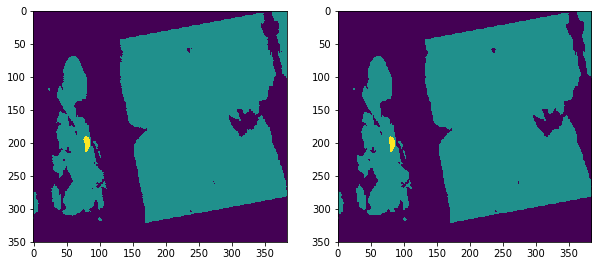

MAGNA_3_-1CL_0.23236kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 82, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 84, Metal: 0, Groups total: 1.0


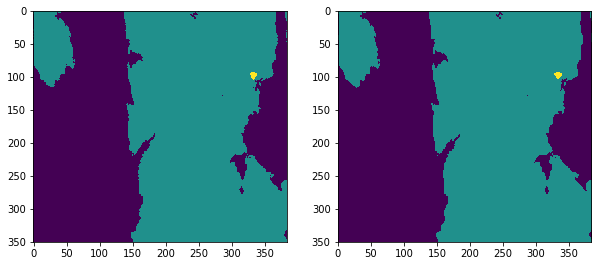

MAGNA_74_44.8574CL_3.06838kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 1564, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 1617, Metal: 0, Groups total: 4.0


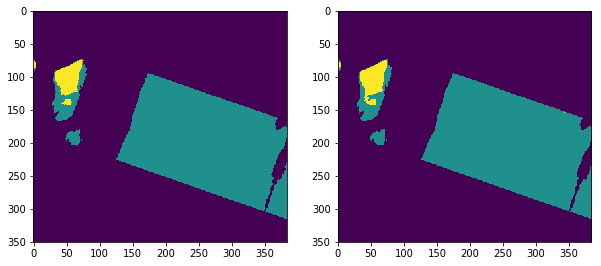

MAGNA_8_85.0527CL_3.22866kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 117, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 118, Metal: 0, Groups total: 1.0


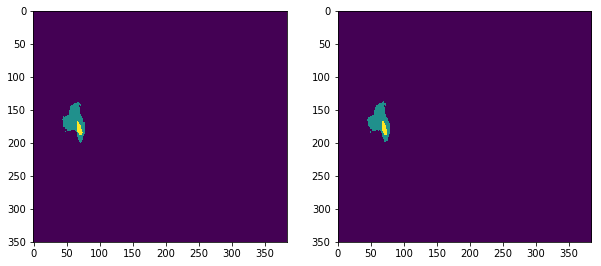

MAGNA_11_87.2996CL_3.4098kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 76, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 3, Metal: 0, Groups total: 1.0


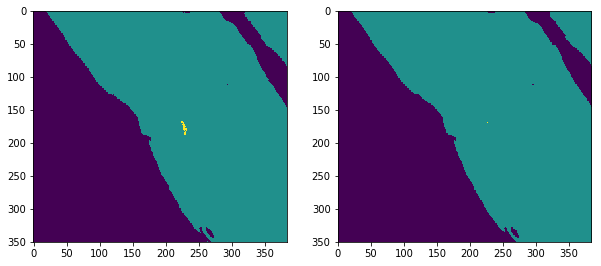

MAGNA_54_80.9176CL_3.55052kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 120, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 18, Metal: 0, Groups total: 1.0


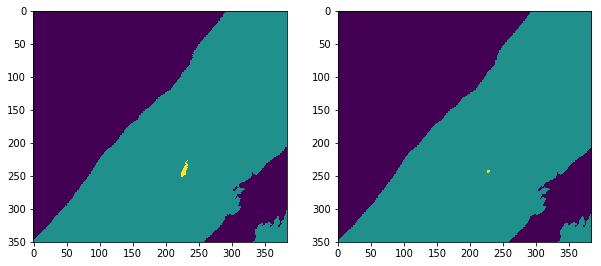

MAGNA_81_-1CL_0.126241kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 102, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 209, Metal: 0, Groups total: 36.0


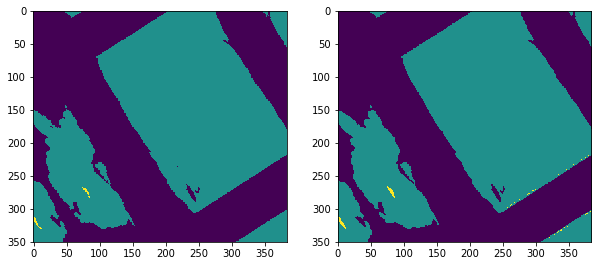

MAGNA_55_78.2309CL_3.01072kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 30, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 25, Metal: 0, Groups total: 1.0


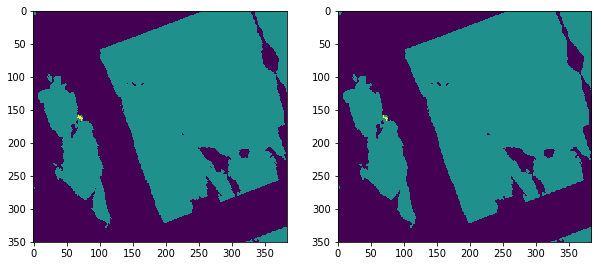

MAGNA_9_75.379CL_0.995336kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 46, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 31, Metal: 0, Groups total: 1.0


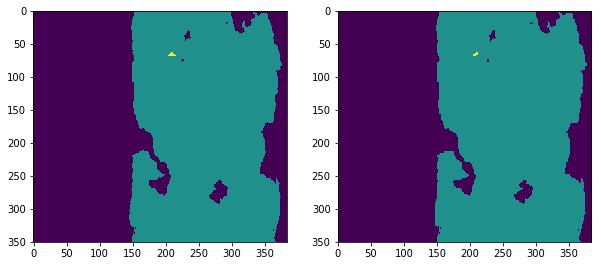

MAGNA_13_-1CL_0.0944208kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 64, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 17, Metal: 0, Groups total: 1.0


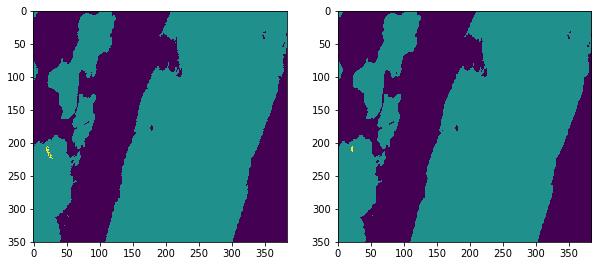

MAGNA_78_87.1515CL_3.08468kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 132, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 10, Metal: 0, Groups total: 1.0


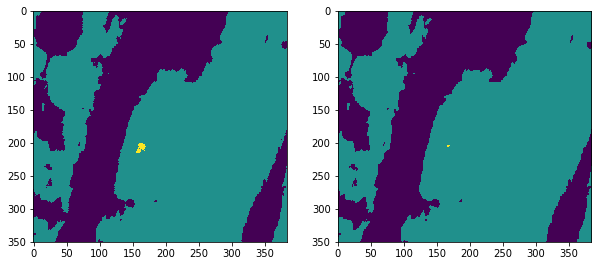

MAGNA_20_-1CL_0.0498074kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 291, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 136, Metal: 0, Groups total: 1.0


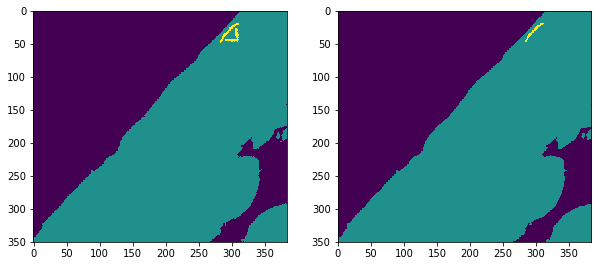

MAGNA_91_80.2473CL_3.60343kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 1162, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 1164, Metal: 0, Groups total: 1.0


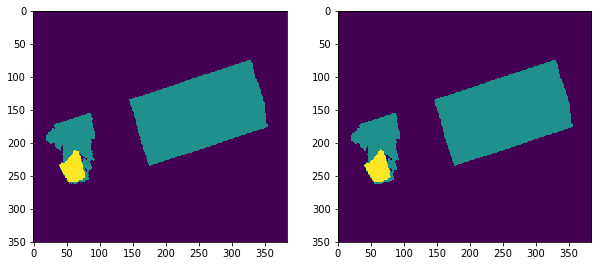

MAGNA_51_-1CL_0.439528kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 298, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 272, Metal: 0, Groups total: 2.0


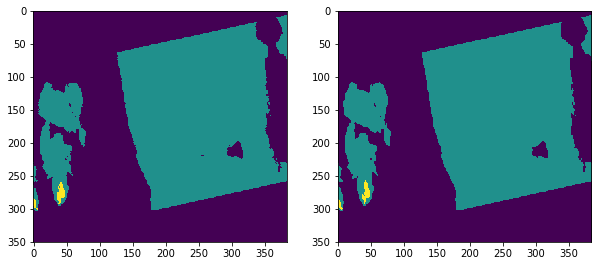

MAGNA_4_-1CL_0.402531kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 136, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 170, Metal: 0, Groups total: 1.0


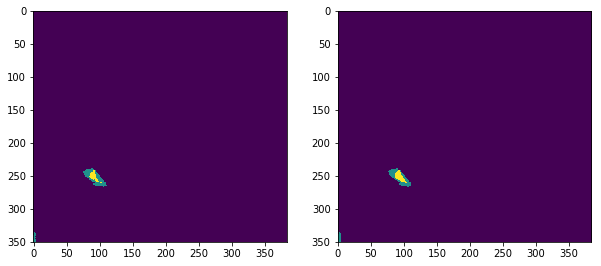

MAGNA_49_69.7262CL_3.01703kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 73, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 58, Metal: 0, Groups total: 2.0


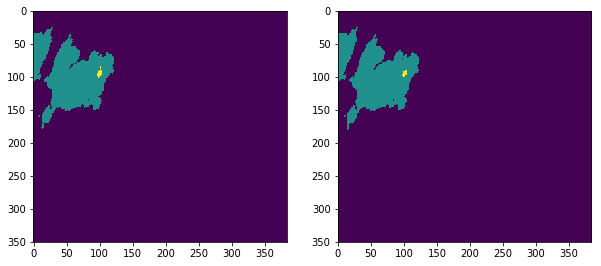

MAGNA_5_-1CL_0.0500007kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 369, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 352, Metal: 0, Groups total: 2.0


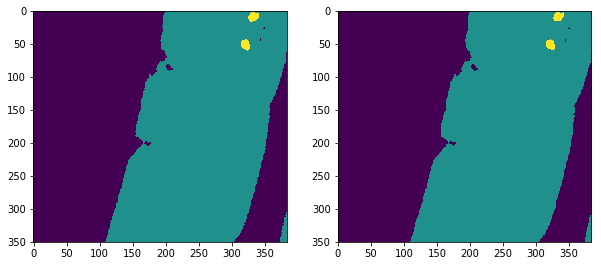

MAGNA_21_82.237CL_3.45164kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 110, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 157, Metal: 0, Groups total: 25.0


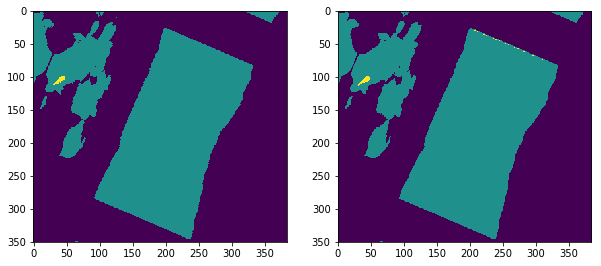

MAGNA_54_86.6833CL_3.42599kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 55, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 54, Metal: 0, Groups total: 1.0


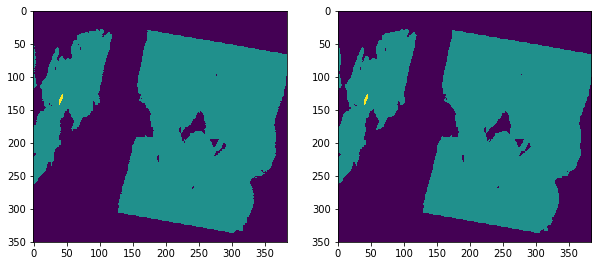

MAGNA_83_-1CL_0.265669kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 295, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 267, Metal: 0, Groups total: 1.0


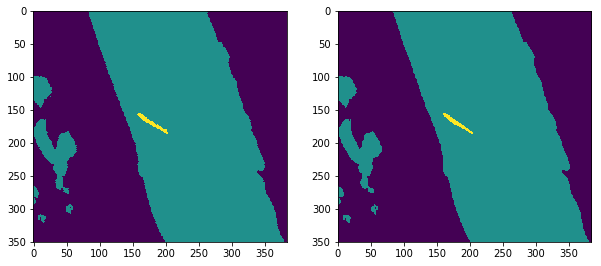

MAGNA_92_-1CL_0.174769kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 197, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 210, Metal: 0, Groups total: 1.0


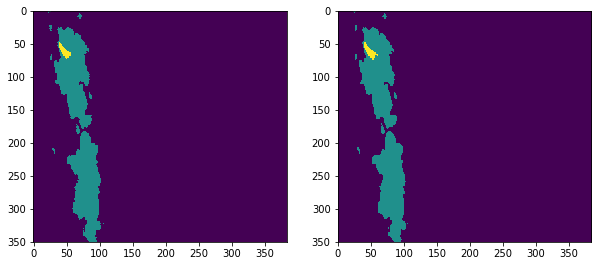

MAGNA_67_-1CL_0.0105861kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 281, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 313, Metal: 0, Groups total: 4.0


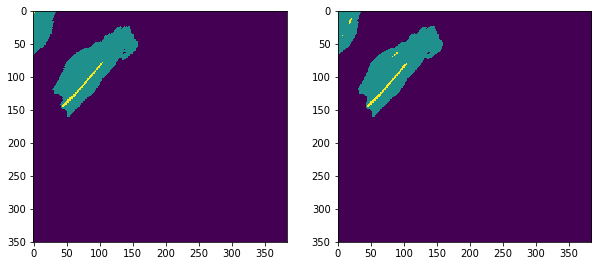

MAGNA_8_81.5638CL_3.9198kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 141, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 161, Metal: 0, Groups total: 1.0


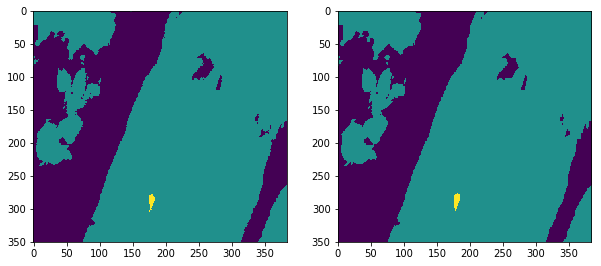

MAGNA_29_80.2607CL_3.4196kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 49, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 2, Metal: 0, Groups total: 1.0


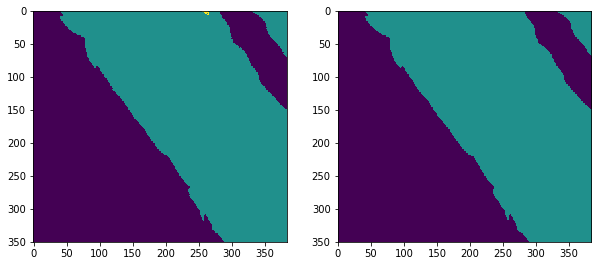

MAGNA_10_65.8423CL_3.13651kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 82, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 78, Metal: 0, Groups total: 1.0


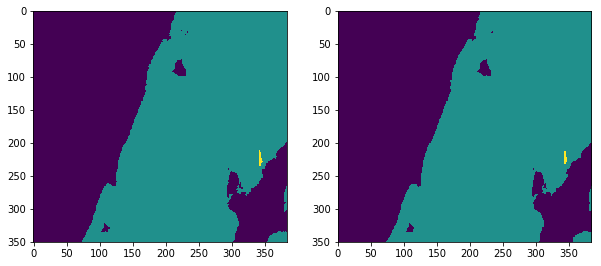

MAGNA_72_85.4336CL_3.48104kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 8264, Metal: 0, Groups total: 12.0
Prediction   -> Bone: 8107, Metal: 0, Groups total: 14.0


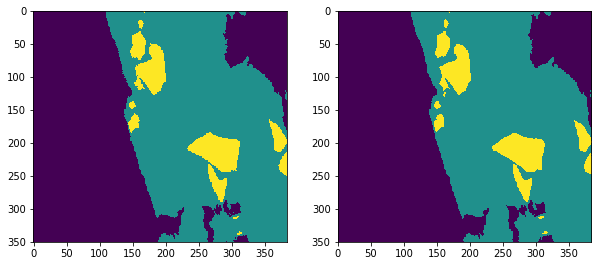

MAGNA_27_83.3064CL_3.34484kg.tif
There is just Meat / Found just Meat
Pixel count
Ground truth -> Bone: 0, Metal: 0, Groups total: 0.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


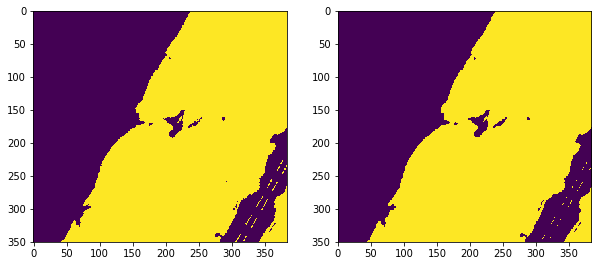

MAGNA_91_-1CL_0.377516kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 252, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 261, Metal: 0, Groups total: 1.0


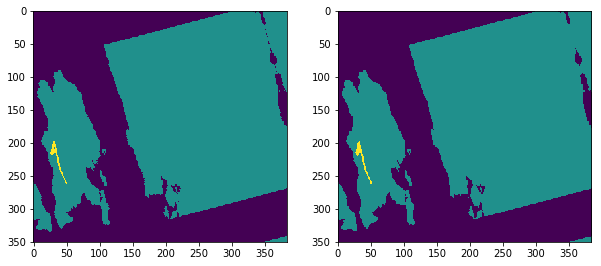

MAGNA_3_-1CL_0.31416kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 61, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 101, Metal: 0, Groups total: 2.0


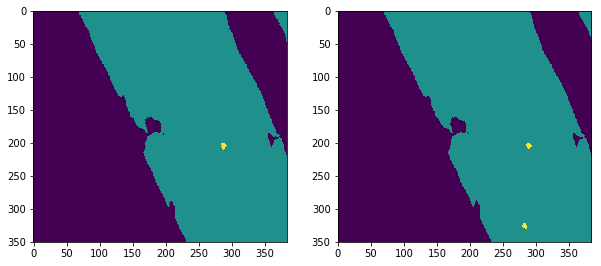

MAGNA_44_-1CL_0.108247kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 110, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 185, Metal: 0, Groups total: 2.0


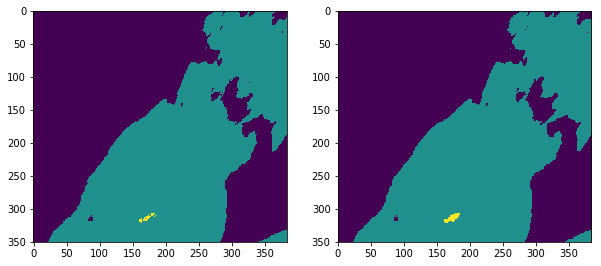

MAGNA_9_-1CL_0.0427606kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 82, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 114, Metal: 0, Groups total: 1.0


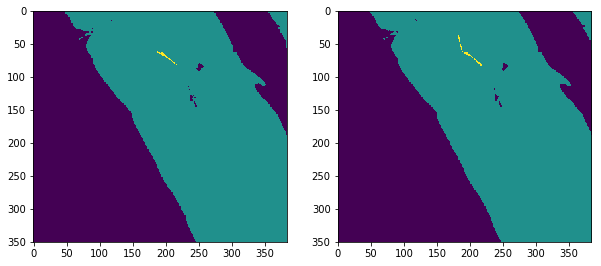

MAGNA_35_-1CL_0.120132kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 251, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 267, Metal: 0, Groups total: 1.0


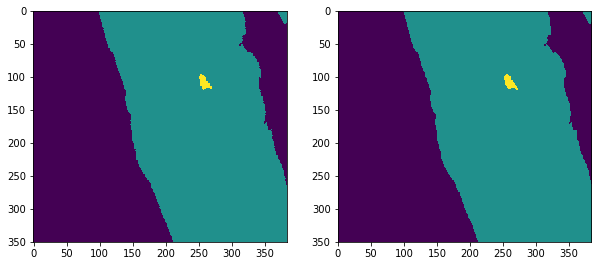

MAGNA_30_-1CL_0.00636415kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 1528, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 1509, Metal: 0, Groups total: 6.0


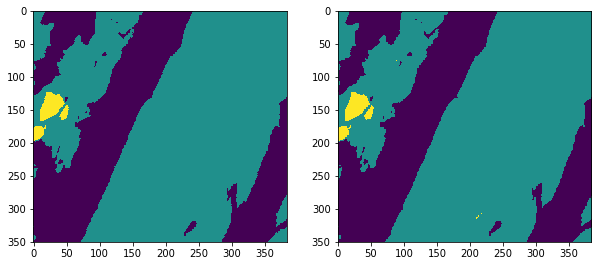

MAGNA_80_-1CL_0.0959034kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 611, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 620, Metal: 0, Groups total: 1.0


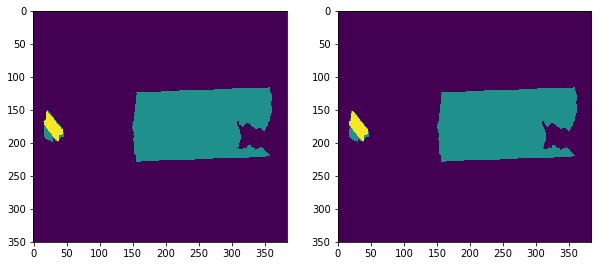

MAGNA_83_91.196CL_0.337915kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 808, Metal: 0, Groups total: 4.0
Prediction   -> Bone: 731, Metal: 0, Groups total: 4.0


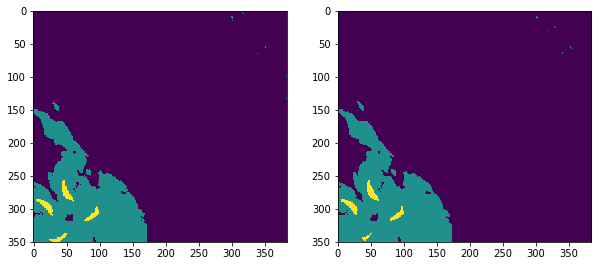

MAGNA_76_-1CL_0.289474kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 119, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 116, Metal: 0, Groups total: 1.0


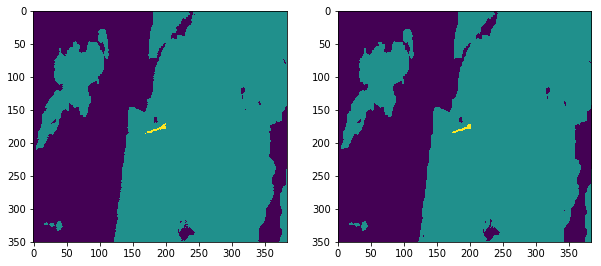

MAGNA_93_66.1024CL_3.97892kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 44, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 51, Metal: 0, Groups total: 10.0


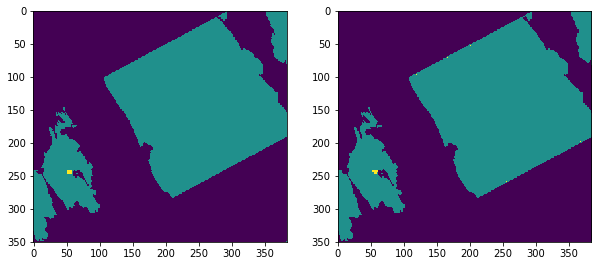

MAGNA_97_84.2047CL_3.47187kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 432, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 582, Metal: 0, Groups total: 33.0


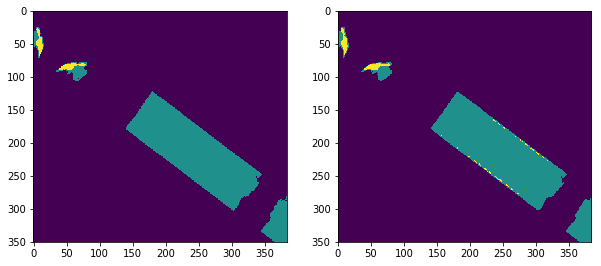

MAGNA_6_-1CL_0.463288kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 356, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 357, Metal: 0, Groups total: 2.0


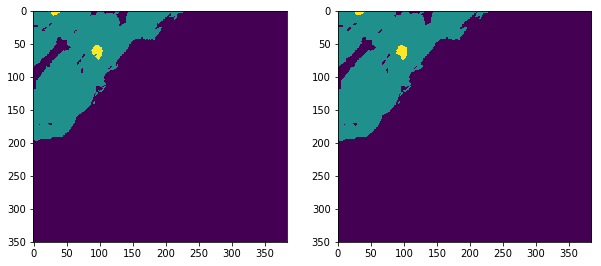

MAGNA_73_-1CL_0.372527kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 449, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 447, Metal: 0, Groups total: 1.0


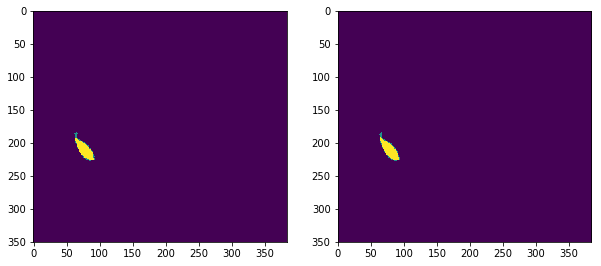

MAGNA_83_84.9141CL_2.968kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 230, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 264, Metal: 0, Groups total: 26.0


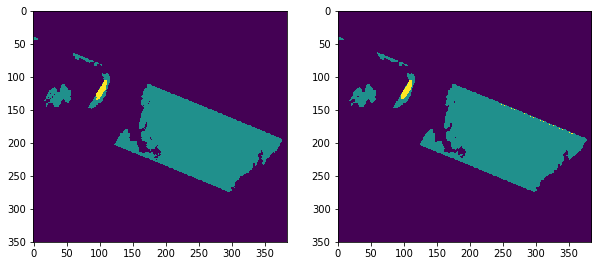

MAGNA_3_-1CL_0.0338865kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 226, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 292, Metal: 0, Groups total: 27.0


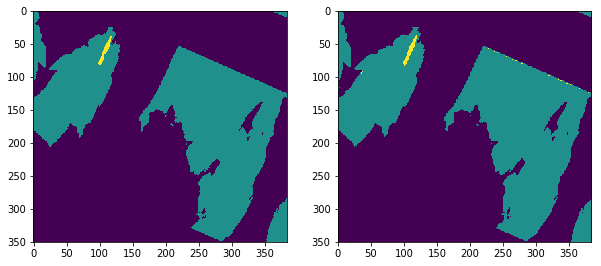

MAGNA_57_81.5654CL_2.93396kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 142, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 145, Metal: 0, Groups total: 1.0


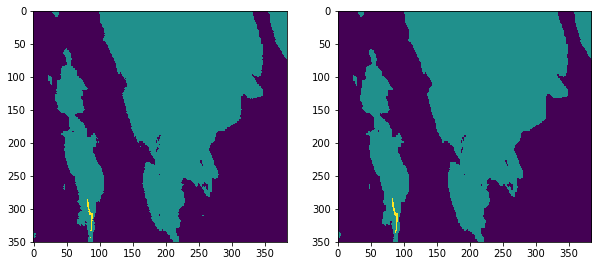

MAGNA_77_82.3391CL_2.26192kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 86, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 80, Metal: 0, Groups total: 2.0


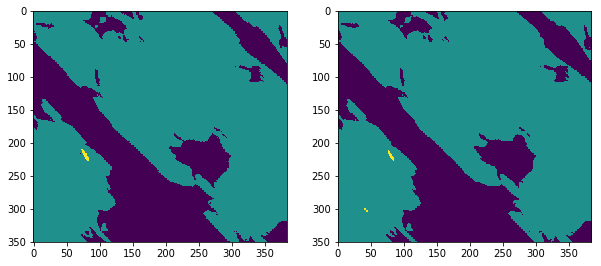

MAGNA_99_66.1292CL_3.52498kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 132, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 73, Metal: 0, Groups total: 1.0


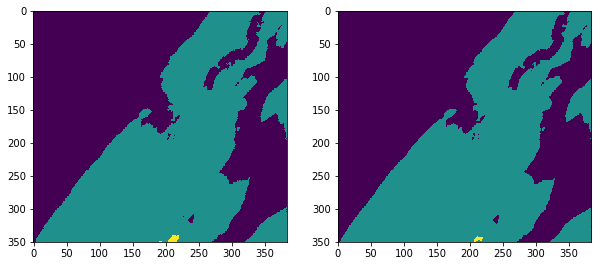

MAGNA_15_-1CL_0.0117723kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 159, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 190, Metal: 0, Groups total: 2.0


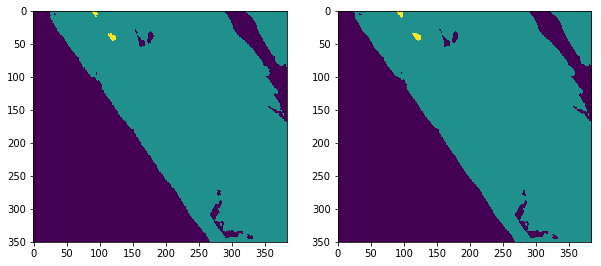

MAGNA_6_83.7672CL_3.4214kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 171, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 41, Metal: 0, Groups total: 1.0


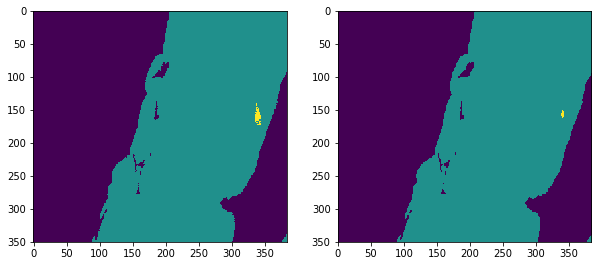

MAGNA_87_77.6461CL_3.5813kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 357, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 320, Metal: 0, Groups total: 2.0


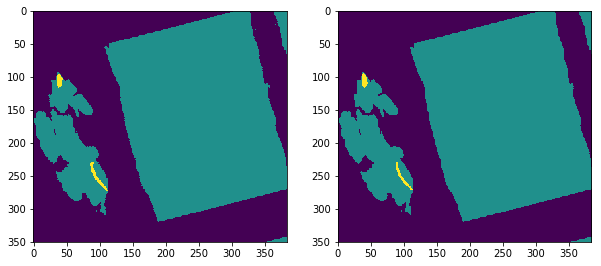

MAGNA_8_78.0621CL_3.14646kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 44, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 35, Metal: 0, Groups total: 1.0


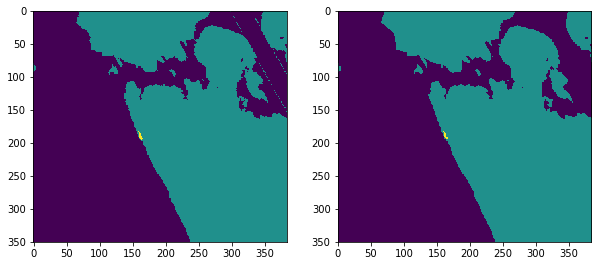

MAGNA_84_-1CL_0.25132kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 225, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 239, Metal: 0, Groups total: 3.0


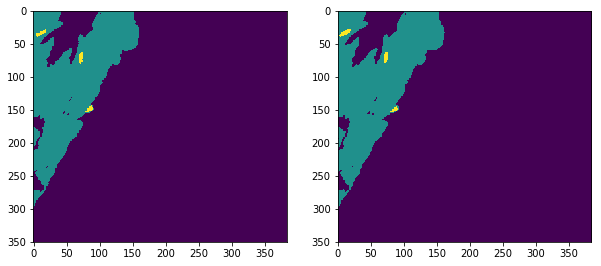

MAGNA_22_86.0346CL_3.72206kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 189, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 193, Metal: 0, Groups total: 3.0


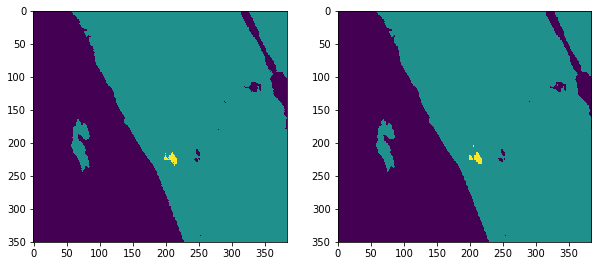

MAGNA_11_78.9437CL_3.36472kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 76, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 25, Metal: 0, Groups total: 1.0


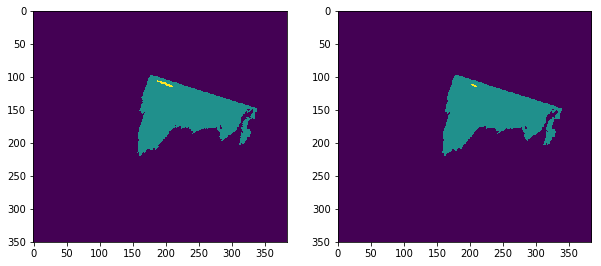

MAGNA_90_-1CL_0.0352327kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 246, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 223, Metal: 0, Groups total: 1.0


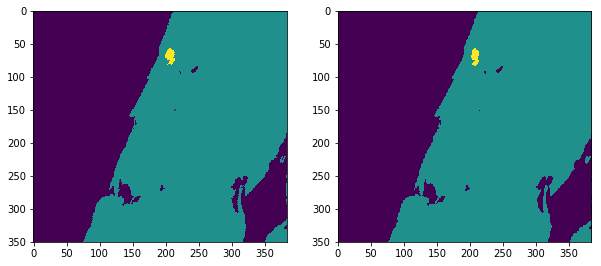

MAGNA_66_84.8755CL_3.12514kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 312, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 313, Metal: 0, Groups total: 1.0


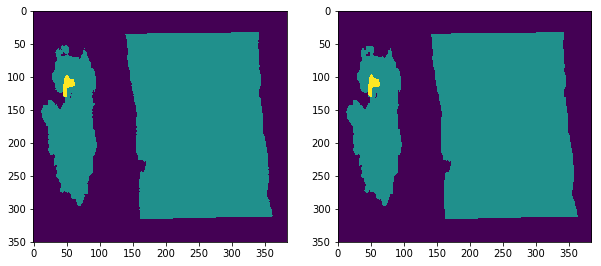

MAGNA_70_-1CL_0.000228762kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 246, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 255, Metal: 0, Groups total: 1.0


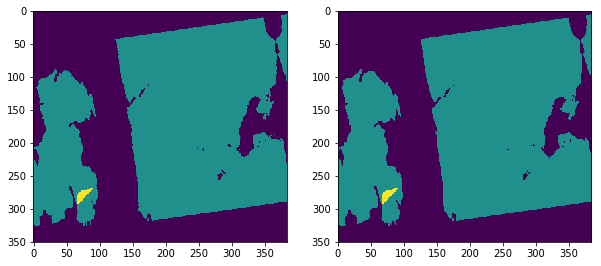

MAGNA_53_-1CL_0.323371kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 385, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 399, Metal: 0, Groups total: 1.0


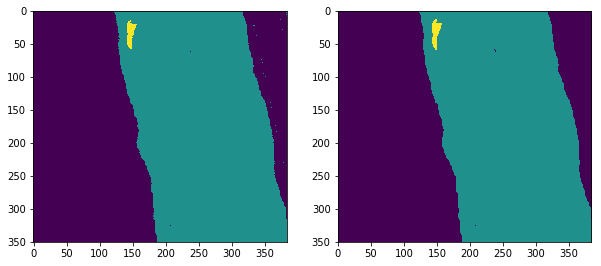

MAGNA_43_77.2917CL_3.42207kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 68, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 17, Metal: 0, Groups total: 1.0


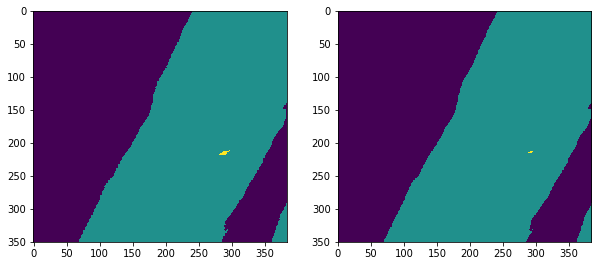

MAGNA_59_82.0885CL_3.19018kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 171, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 51, Metal: 0, Groups total: 1.0


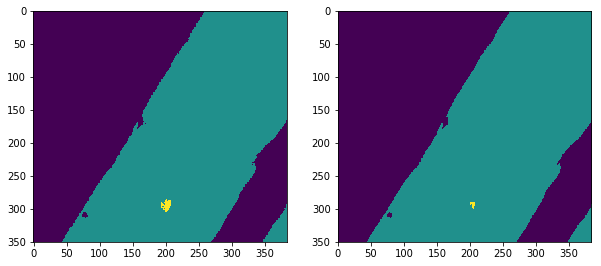

MAGNA_17_81.4874CL_3.42111kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 322, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 305, Metal: 0, Groups total: 1.0


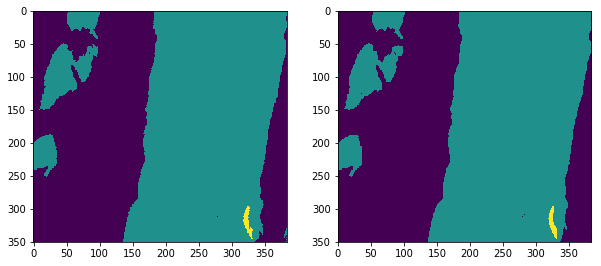

MAGNA_79_60.5525CL_3.58164kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 633, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 645, Metal: 0, Groups total: 3.0


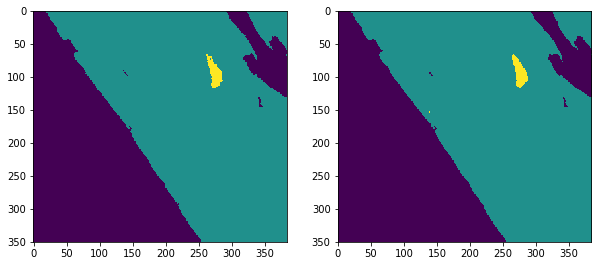

MAGNA_49_-1CL_1.16823e-05kg.tif
There is just Meat / Found just Meat
Pixel count
Ground truth -> Bone: 0, Metal: 0, Groups total: 0.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


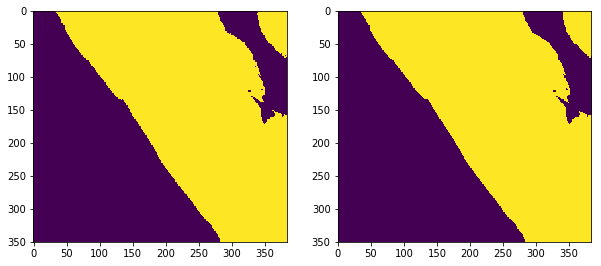

MAGNA_95_-1CL_0.0191017kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 138, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 156, Metal: 0, Groups total: 1.0


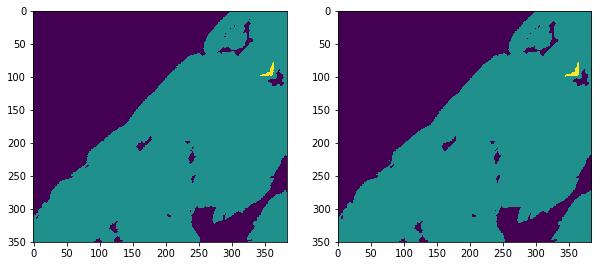

MAGNA_70_85.5342CL_3.50252kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 84, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 90, Metal: 0, Groups total: 2.0


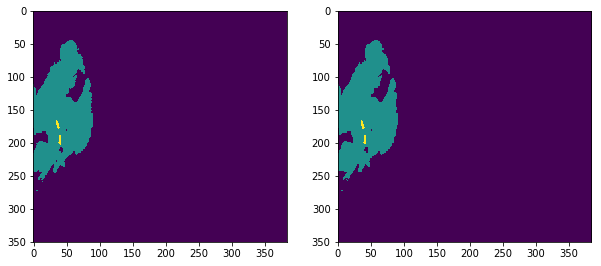

MAGNA_87_62.2273CL_2.93509kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 71, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 59, Metal: 0, Groups total: 1.0


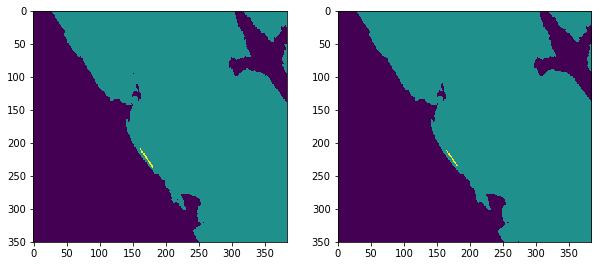

MAGNA_49_-1CL_0.015494kg.tif
There is just Meat / Found just Meat
Pixel count
Ground truth -> Bone: 0, Metal: 0, Groups total: 0.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


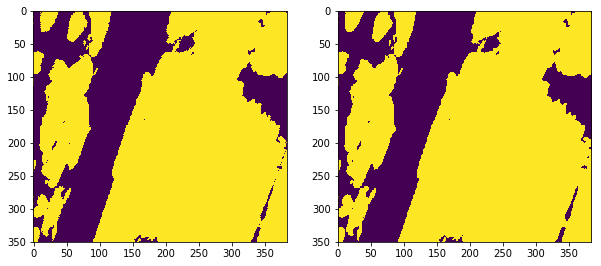

MAGNA_63_-1CL_0.791759kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 123, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 181, Metal: 0, Groups total: 2.0


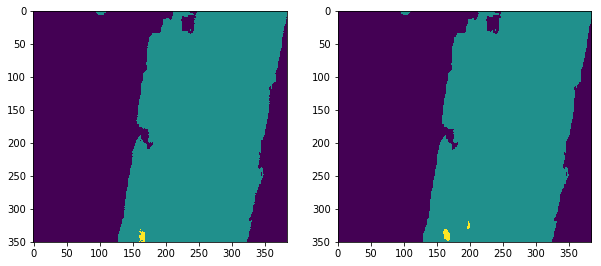

MAGNA_95_-1CL_0.530287kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 88, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 85, Metal: 0, Groups total: 1.0


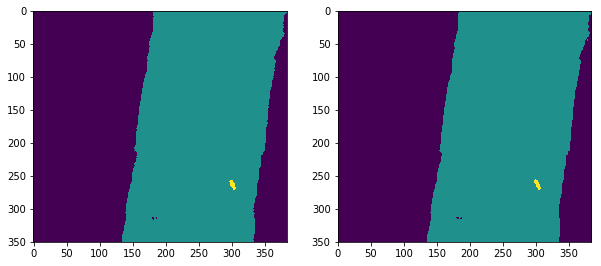

MAGNA_53_-1CL_0.00622273kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 79, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 81, Metal: 0, Groups total: 1.0


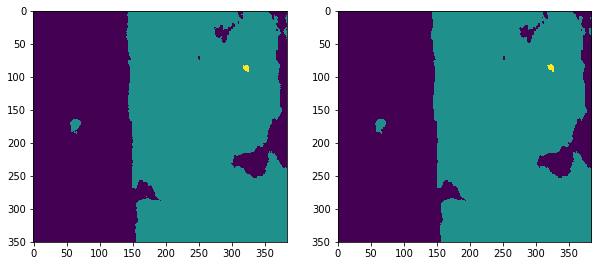

MAGNA_25_-1CL_0.490632kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 540, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 666, Metal: 0, Groups total: 20.0


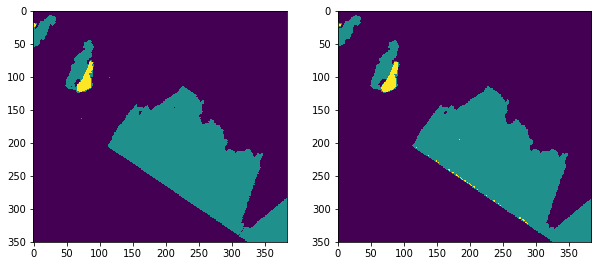

MAGNA_91_-1CL_0.210184kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 62, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 53, Metal: 0, Groups total: 1.0


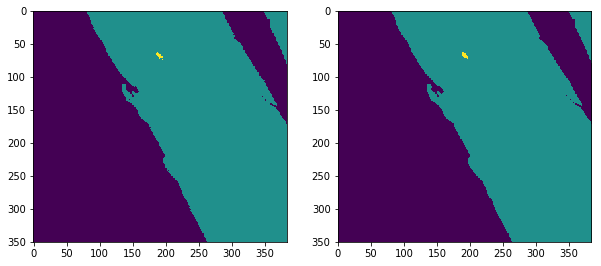

MAGNA_77_-1CL_0.213087kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 105, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 103, Metal: 0, Groups total: 1.0


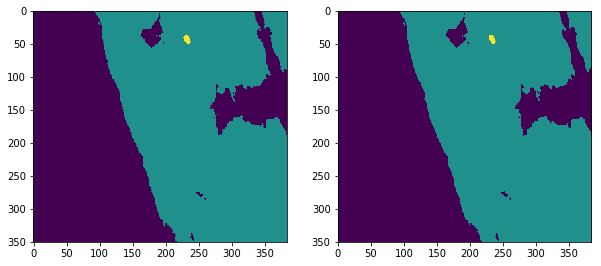

MAGNA_27_47.1477CL_3.63092kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 316, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 301, Metal: 0, Groups total: 1.0


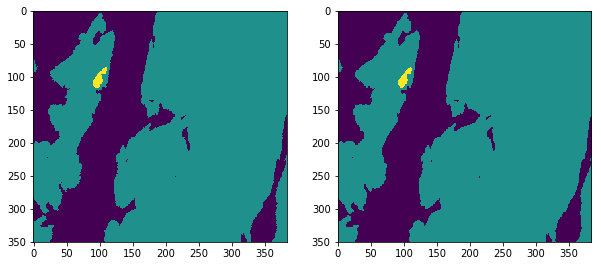

MAGNA_45_86.3739CL_3.44431kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 94, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 79, Metal: 0, Groups total: 3.0


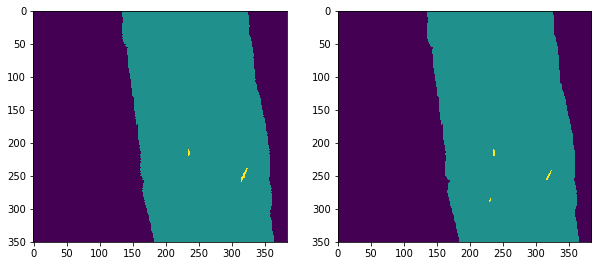

MAGNA_70_-1CL_0.549775kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 152, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 194, Metal: 0, Groups total: 2.0


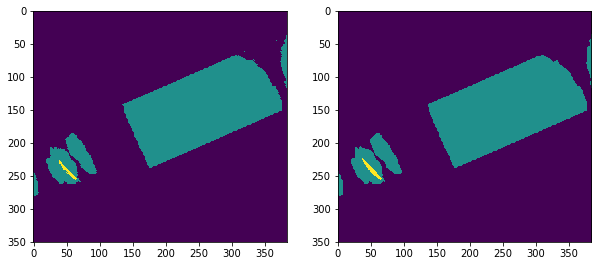

MAGNA_50_-1CL_0.457676kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 3637, Metal: 0, Groups total: 18.0
Prediction   -> Bone: 3332, Metal: 0, Groups total: 23.0


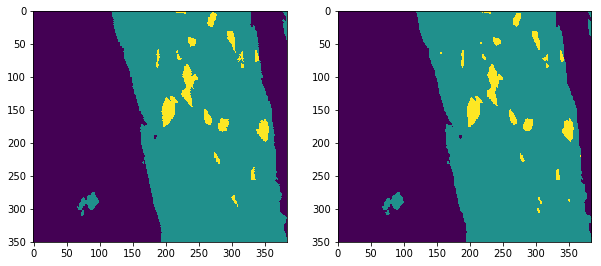

MAGNA_39_-1CL_0.000342262kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 593, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 614, Metal: 0, Groups total: 2.0


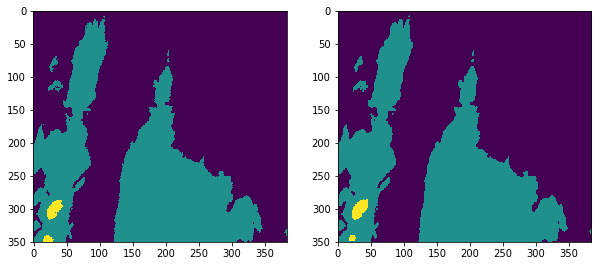

MAGNA_92_81.8555CL_3.38438kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 232, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 215, Metal: 0, Groups total: 1.0


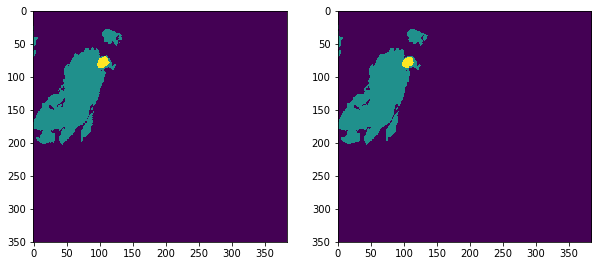

MAGNA_72_-1CL_0.0968677kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 484, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 733, Metal: 0, Groups total: 40.0


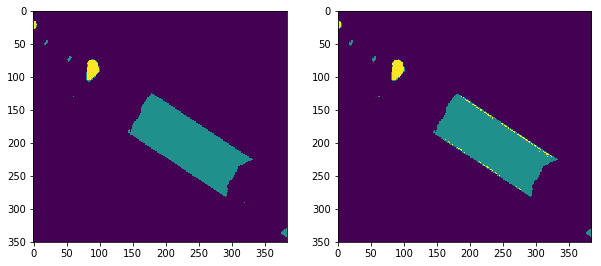

MAGNA_97_83.312CL_3.4788kg.tif
There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 6, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


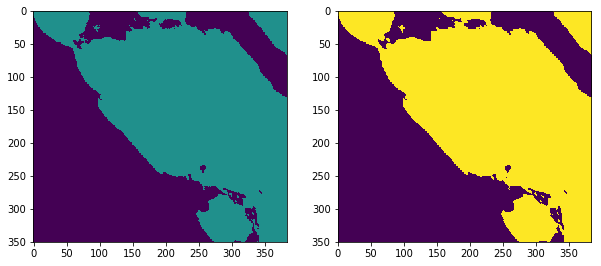

MAGNA_67_86.1498CL_3.60151kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 49, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 47, Metal: 0, Groups total: 11.0


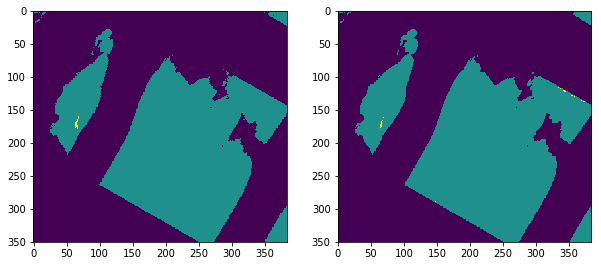

MAGNA_22_-1CL_0.131657kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 105, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 124, Metal: 0, Groups total: 15.0


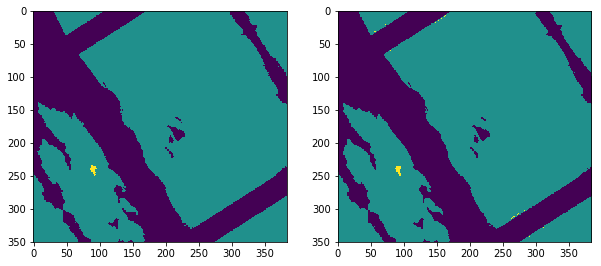

MAGNA_14_89.7756CL_3.08726kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 480, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 451, Metal: 0, Groups total: 1.0


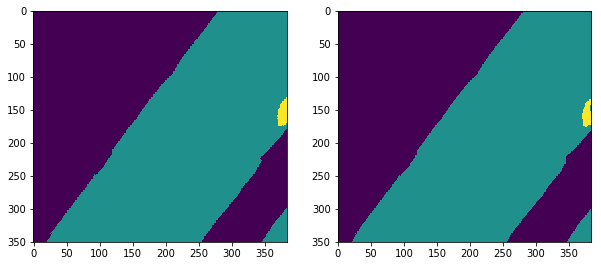

MAGNA_50_46.7794CL_3.37558kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 299, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 276, Metal: 0, Groups total: 1.0


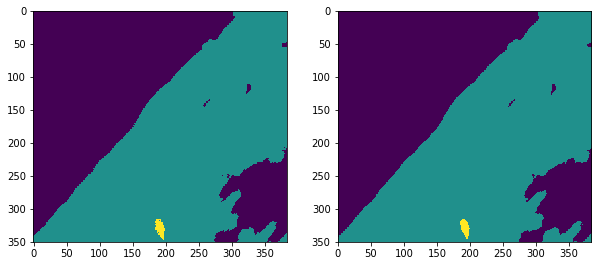

MAGNA_94_66.3127CL_3.71106kg.tif
There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 14, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


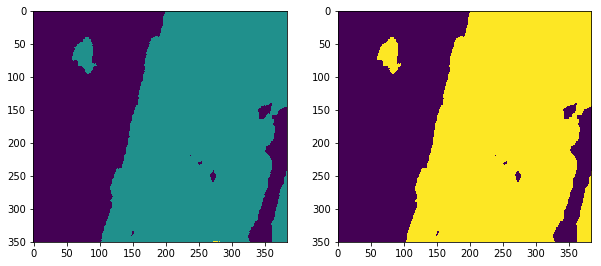

MAGNA_87_84.5863CL_3.47254kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 246, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 151, Metal: 0, Groups total: 2.0


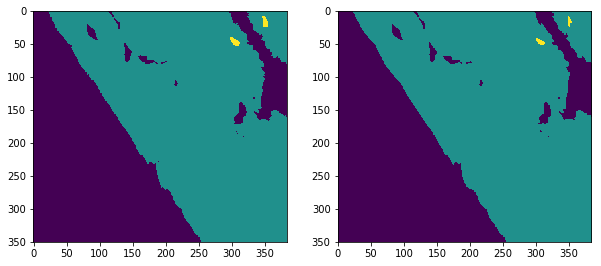

MAGNA_0_-1CL_0.111049kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 115, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 112, Metal: 0, Groups total: 1.0


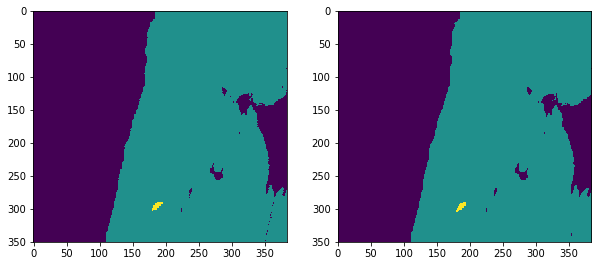

MAGNA_13_-1CL_0.115254kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 151, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 144, Metal: 0, Groups total: 1.0


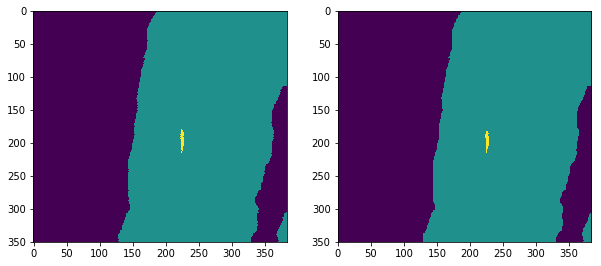

MAGNA_31_58.2673CL_2.74483kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 209, Metal: 0, Groups total: 4.0
Prediction   -> Bone: 195, Metal: 0, Groups total: 2.0


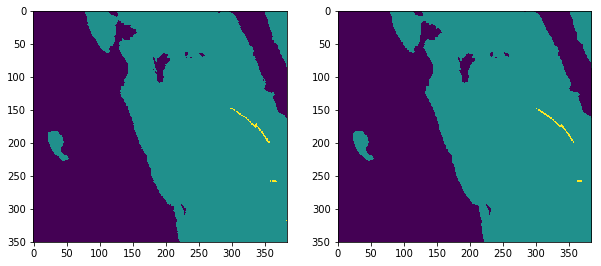

MAGNA_32_-1CL_0.180666kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 398, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 340, Metal: 0, Groups total: 2.0


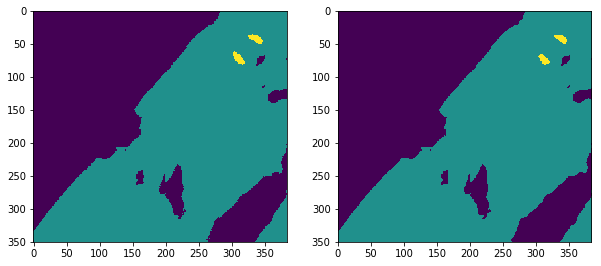

MAGNA_22_86.1166CL_3.38758kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 65, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 69, Metal: 0, Groups total: 1.0


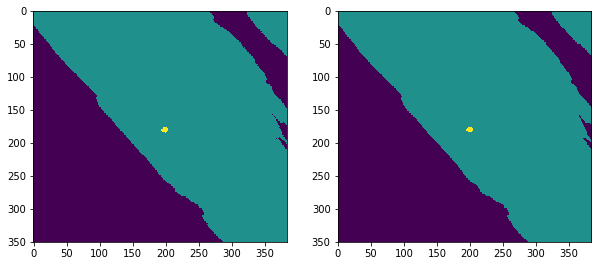

MAGNA_70_86.9493CL_3.34258kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 395, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 402, Metal: 0, Groups total: 1.0


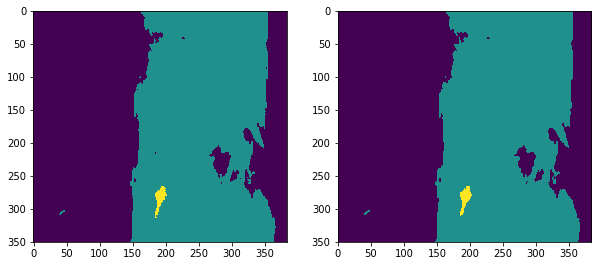

MAGNA_66_49.4765CL_3.37136kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 96, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 89, Metal: 0, Groups total: 2.0


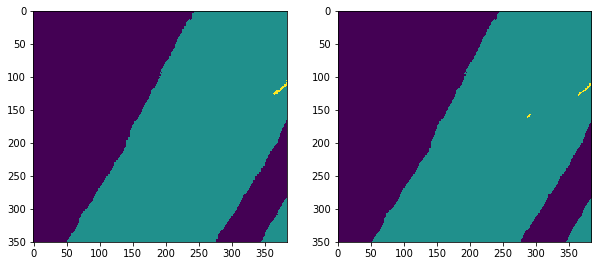

MAGNA_75_-1CL_0.511064kg.tif
There is just Meat / Found just Meat
Pixel count
Ground truth -> Bone: 0, Metal: 0, Groups total: 0.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


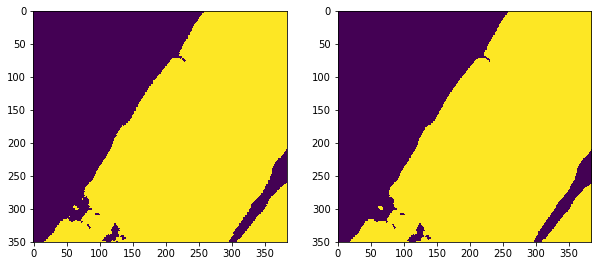

MAGNA_25_87.0871CL_3.55375kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 235, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 229, Metal: 0, Groups total: 1.0


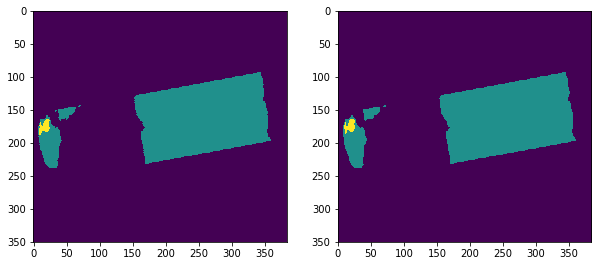

MAGNA_8_89.7751CL_3.15224kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 56, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 57, Metal: 0, Groups total: 1.0


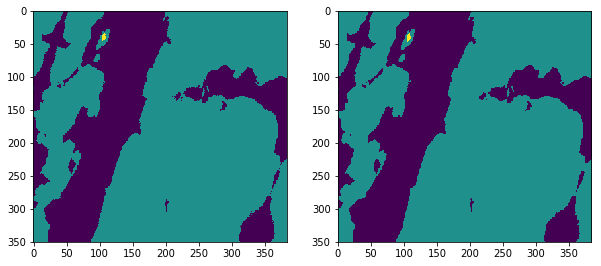

MAGNA_12_85.1966CL_3.11871kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 202, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 149, Metal: 0, Groups total: 3.0


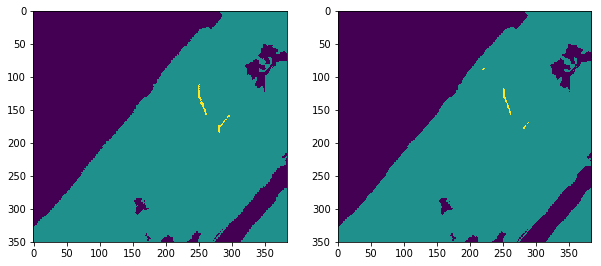

MAGNA_97_69.0055CL_2.90033kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 133, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 113, Metal: 0, Groups total: 1.0


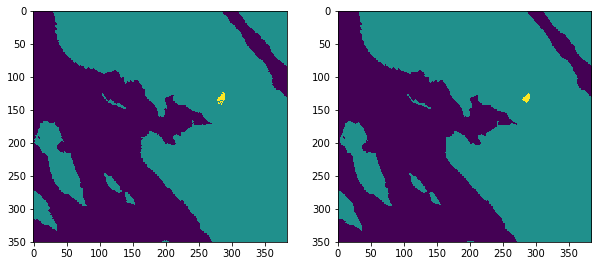

MAGNA_94_81.3513CL_3.42068kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 66, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 81, Metal: 0, Groups total: 1.0


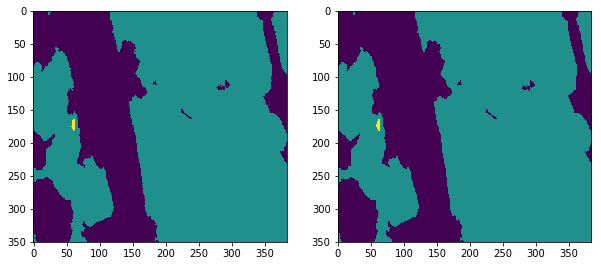

MAGNA_20_-1CL_0.0824719kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 91, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 92, Metal: 0, Groups total: 1.0


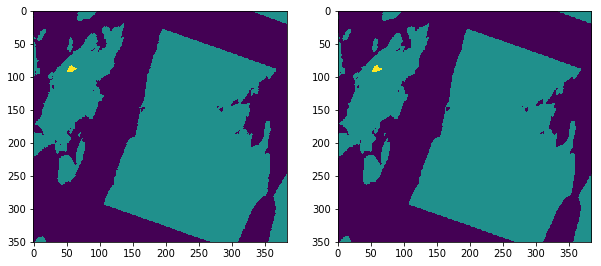

MAGNA_85_-1CL_0.370942kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 90, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 123, Metal: 0, Groups total: 4.0


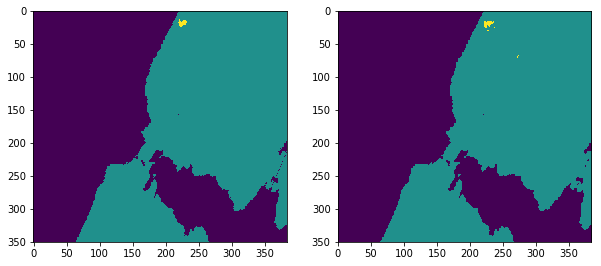

MAGNA_58_-1CL_0.36493kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 281, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 634, Metal: 0, Groups total: 14.0


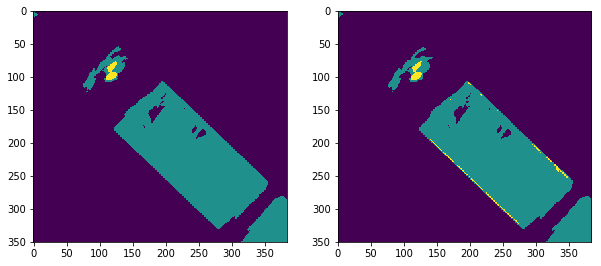

MAGNA_20_83.5793CL_3.55414kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 57, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 53, Metal: 0, Groups total: 1.0


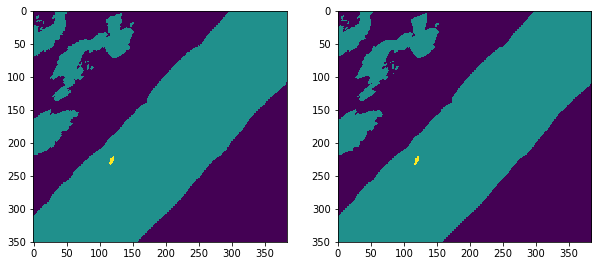

MAGNA_47_-1CL_0.970134kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 172, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 183, Metal: 0, Groups total: 1.0


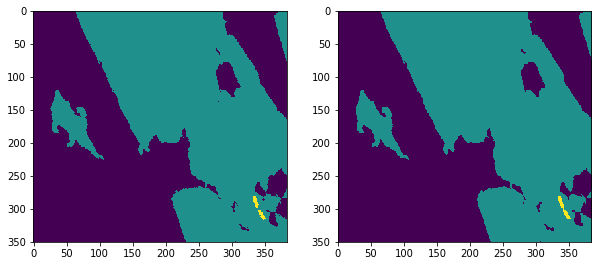

MAGNA_26_88.0521CL_3.34556kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 54, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 40, Metal: 0, Groups total: 1.0


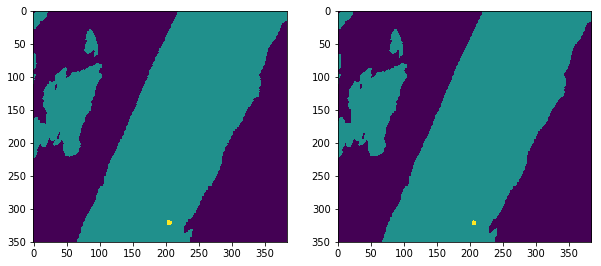

MAGNA_71_83.6821CL_2.16415kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 542, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 484, Metal: 0, Groups total: 1.0


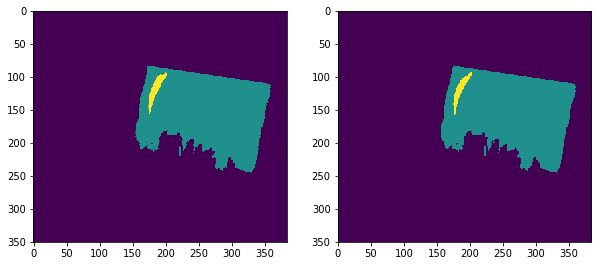

MAGNA_57_71.1818CL_3.52932kg.tif
There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 38, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


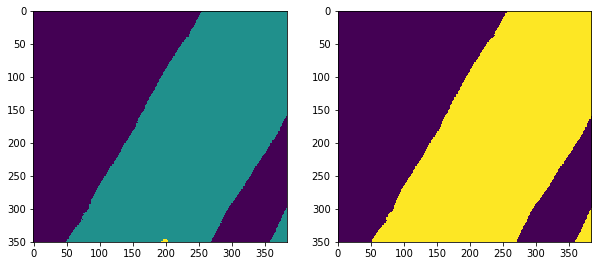

MAGNA_78_-1CL_0.103279kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 368, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 367, Metal: 0, Groups total: 2.0


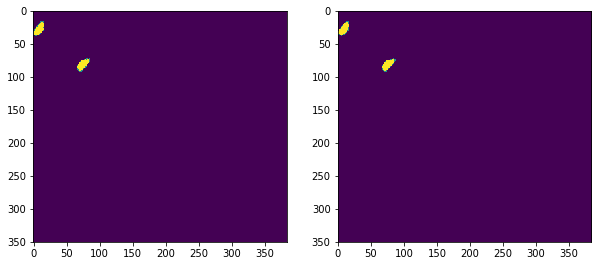

MAGNA_65_-1CL_0.422152kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 357, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 433, Metal: 0, Groups total: 23.0


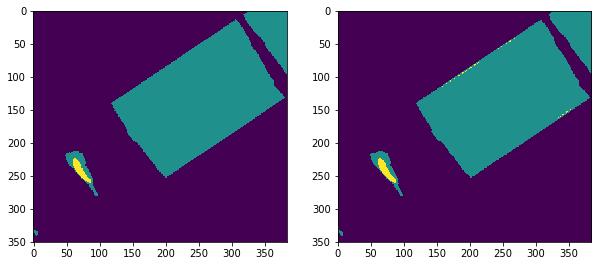

MAGNA_18_-1CL_0.294985kg.tif
There is Bone / Found just Meat
Pixel count
Ground truth -> Bone: 166, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


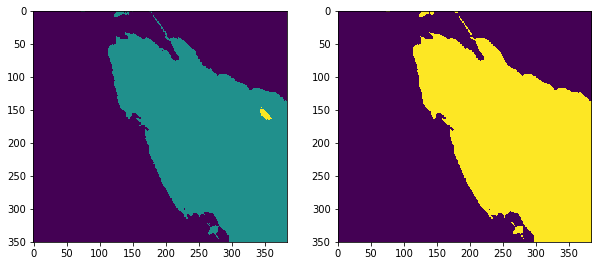

MAGNA_8_-1CL_0.0901028kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 113, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 107, Metal: 0, Groups total: 1.0


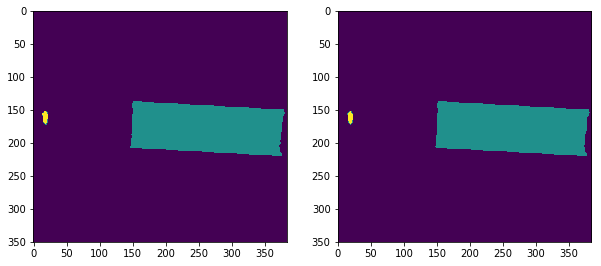

MAGNA_12_-1CL_0.377521kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 167, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 98, Metal: 0, Groups total: 2.0


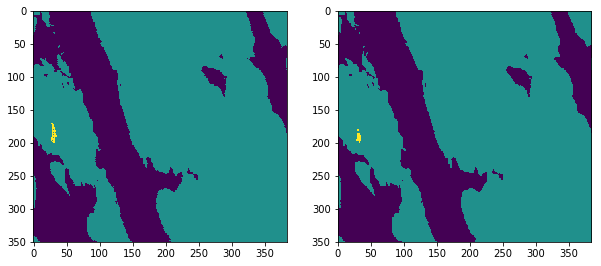

MAGNA_5_-1CL_0.480311kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 55, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 49, Metal: 0, Groups total: 1.0


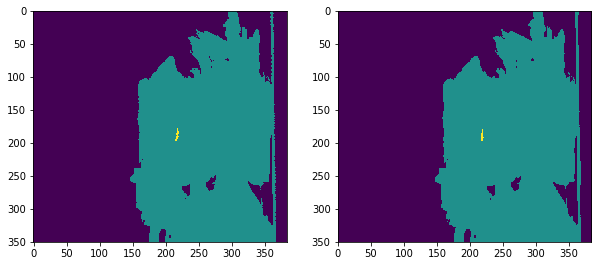

MAGNA_93_-1CL_0.553237kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 181, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 181, Metal: 0, Groups total: 1.0


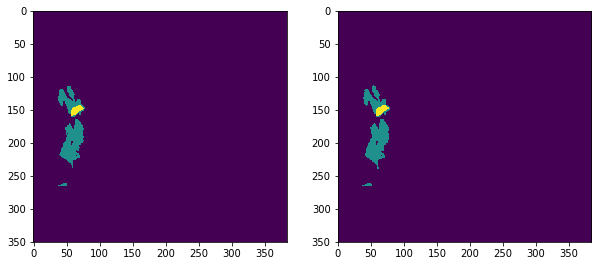

MAGNA_65_86.7001CL_3.5688kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 41, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 41, Metal: 0, Groups total: 1.0


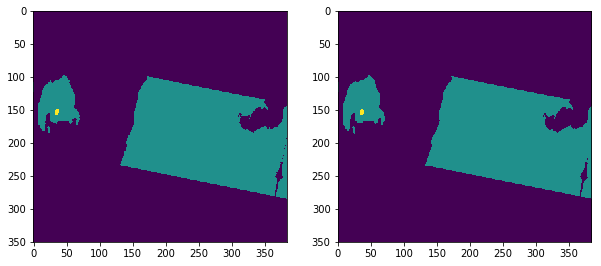

MAGNA_37_73.0456CL_3.79131kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 465, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 448, Metal: 0, Groups total: 2.0


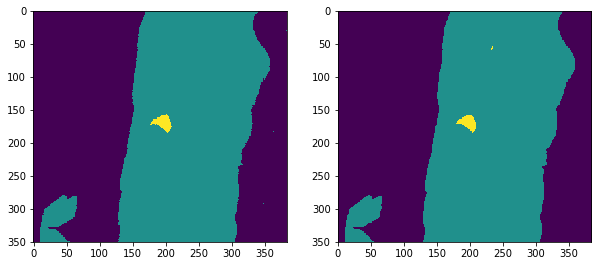

MAGNA_85_-1CL_0.187774kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 548, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 1052, Metal: 0, Groups total: 19.0


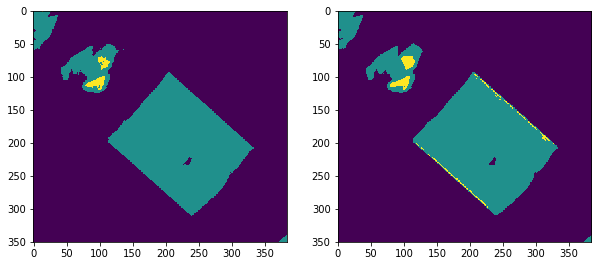

MAGNA_16_-1CL_0.0559194kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 113, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 106, Metal: 0, Groups total: 1.0


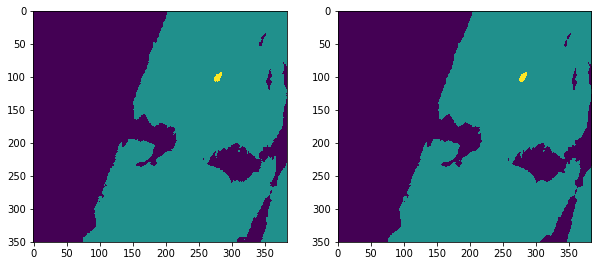

MAGNA_1_65.9464CL_3.47639kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 838, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 813, Metal: 0, Groups total: 2.0


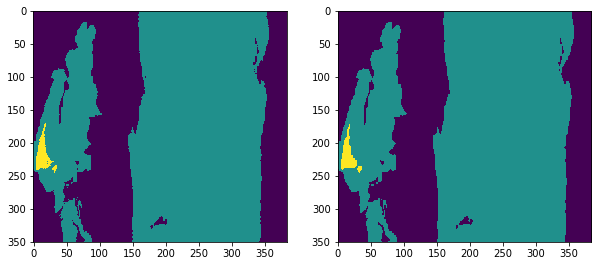

MAGNA_63_-1CL_0.482063kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 101, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 116, Metal: 0, Groups total: 1.0


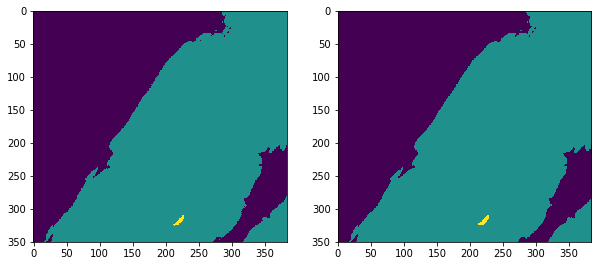

MAGNA_21_-1CL_0.437626kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 42, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 110, Metal: 0, Groups total: 20.0


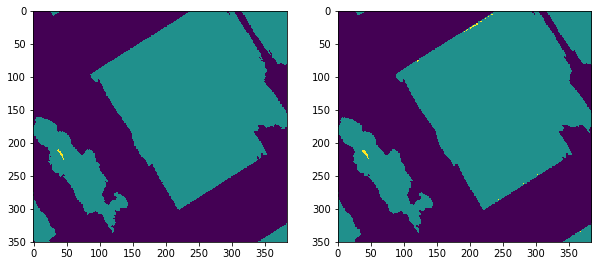

MAGNA_58_82.2071CL_3.69341kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 200, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 167, Metal: 0, Groups total: 2.0


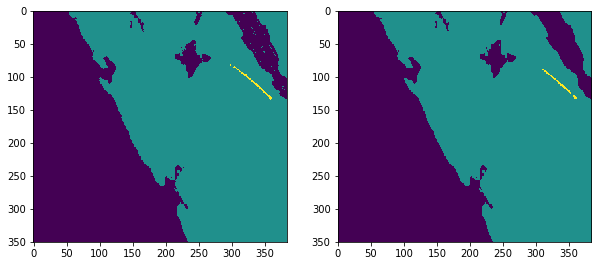

MAGNA_93_-1CL_0.413419kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 886, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 870, Metal: 0, Groups total: 4.0


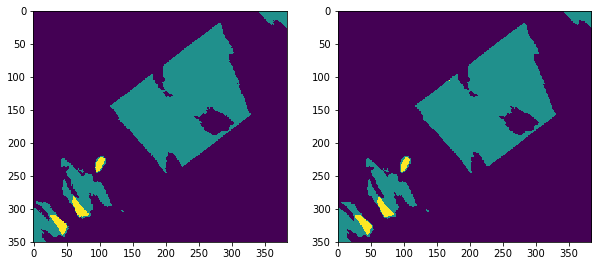

MAGNA_56_-1CL_0.446517kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 118, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 117, Metal: 0, Groups total: 1.0


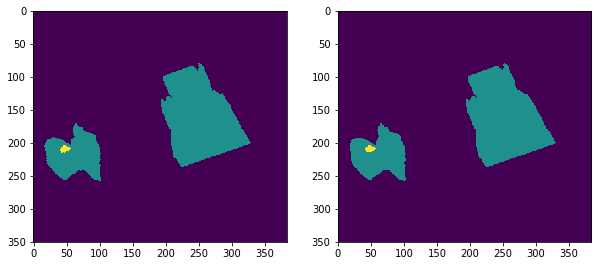

MAGNA_61_83.7706CL_3.88116kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 85, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 94, Metal: 0, Groups total: 2.0


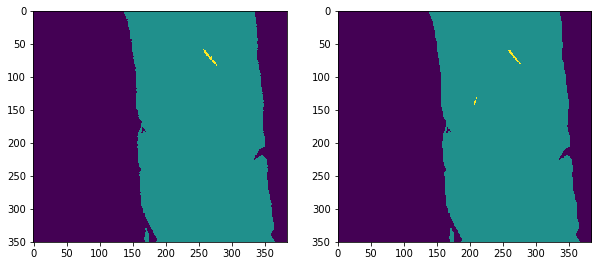

MAGNA_54_-1CL_0.441927kg.tif
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 234, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 242, Metal: 0, Groups total: 1.0


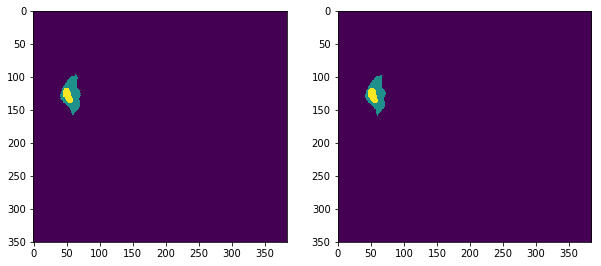

In [30]:
y = torch.squeeze(y)
print("########################")
print("Ground truth / Predictions")
print("########################")
for i in range(preds.shape[0]):
    prediction = preds.argmax(dim=1)[i]
    print(validation_files[i])
    print("There is {} / Found {}".format(getContanimentInfo(y[i]), getContanimentInfo(prediction)))
    fig=plt.figure(figsize=(10,20))
    fig.add_subplot(1, 2, 1)
    plt.imshow(y[i])
    fig.add_subplot(1, 2, 2)
    plt.imshow(prediction)
    print("Pixel count")
    print("Ground truth -> Bone: {}, Metal: {}, Groups total: {}".format(len(y[i][y[i] == 2]), len(y[i][y[i] == 3]), numb_contaminants(y[i])))
    print("Prediction   -> Bone: {}, Metal: {}, Groups total: {}".format(len(prediction[prediction == 2]), len(prediction[prediction == 3]), numb_contaminants(prediction)))
    plt.show()
    

Time for prediction: 0.8668739795684814 seconds
There is Metal / Found Bone
Pixel count
Ground truth -> Bone: 0, Metal: 10
Prediction   -> Bone: 3, Metal: 0


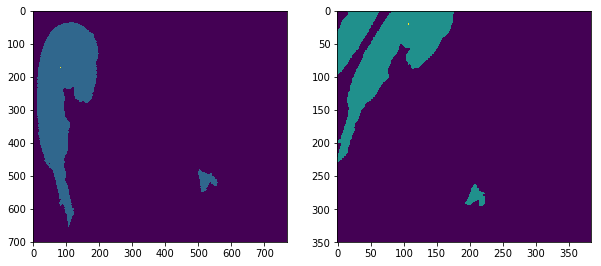

Time for prediction: 0.8000500202178955 seconds
There is Metal / Found Bone
Pixel count
Ground truth -> Bone: 0, Metal: 4
Prediction   -> Bone: 9, Metal: 0


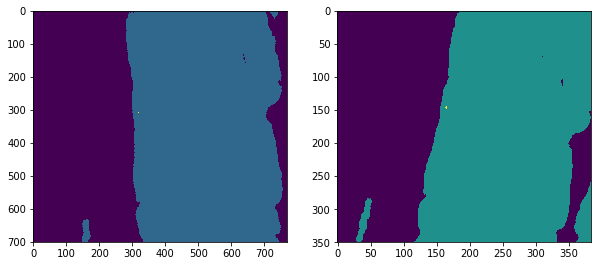

Time for prediction: 0.7876389026641846 seconds
There is Metal / Found just Meat
Pixel count
Ground truth -> Bone: 0, Metal: 5
Prediction   -> Bone: 0, Metal: 0


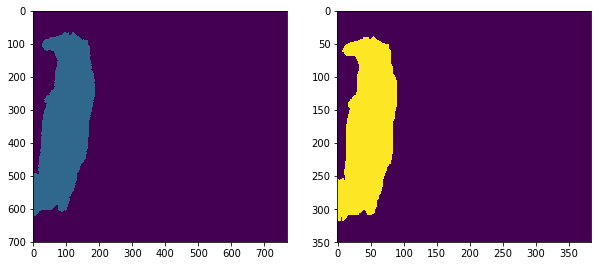

In [31]:
import time

# validation_metal = ['MAGNA_56_-1CL_0.446517kg.tif', 'MAGNA_61_83.7706CL_3.88116kg.tif',
#                              'MAGNA_54_-1CL_0.441927kg.tif']
for name in validation_metal:
    groundTruth = open_image(path / ('masks/' + name), div=False).data[0, :, :]
    t = time.time()
    preds = learn.predict(open_image(path / ('images/' + name)))
    elapsed = time.time() - t
    print("Time for prediction: {} seconds".format(elapsed))

    prediction = preds[1][0, :, :]
    print("There is {} / Found {}".format(getContanimentInfo(groundTruth), getContanimentInfo(prediction)))
    fig=plt.figure(figsize=(10,20))
    fig.add_subplot(1, 2, 1)
    plt.imshow(groundTruth)
    fig.add_subplot(1, 2, 2)
    plt.imshow(prediction)
    print("Pixel count")
    print("Ground truth -> Bone: {}, Metal: {}".format(len(groundTruth[groundTruth == 2]), len(groundTruth[groundTruth == 3])))
    print("Prediction   -> Bone: {}, Metal: {}".format(len(prediction[prediction == 2]), len(prediction[prediction == 3])))
    plt.show()